# EPL Event Study
### Question: how do associated DMR effluent values respond after a facility is issued an EPL?
<i> Ryan Treves

Related: `event_study.ipynb`, `violation_limit_crosswalk.ipynb`, `EPL_exploratory.ipynb`, `mmp_sample_identification.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
import seaborn as sns

In [2]:
dmr_unique = ['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'value_type_code', 'statistical_base_code', 'statistical_base_type_code']

In [3]:
# Set file paths
data_path = '~/sherlock_oak/EPA/Data/manual/california/'

# Load in data
violations = pd.read_excel(data_path + 'violations_export_2021-10-26.xlsx')
enforcements = pd.read_csv(data_path + 'enf_actions_export.csv')
enf_viol_links = pd.read_excel(data_path + 'EnfActionToViolationRships.xlsx')
viol_limit_links = pd.read_excel('viol_limit_matching/treatment_viols_matched.xlsx', dtype={'matched_parameter_code': object, 'matched_outfall': object})

date_vars = ['limit_begin_date', 'limit_end_date', 'monitoring_period_end_date']
CA_dmrs = pd.read_csv(data_path + 'CA_dmrs.csv', dtype={
    'parameter_code': object,
    'perm_feature_nmbr': object,
    'percent_removal_flag': object,
    'stay_type_code': object,
    'monitoring_location_code': object,
    'limit_unit_code': object,
    'standard_unit_code': object,
    'rnc_resolution_code': object
}, parse_dates=date_vars, date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

Let's start by narrowing down to the types of EPL actions we're interested in (see `mmp_sample_identification.ipynb` for more details)

In [4]:
# EPL enforcement actions
epl_enforcements = enforcements[
                                # Either have a valid ACL issuance date and some mention of an EPL in the enforcement action
                                (((enforcements['ENFORCEMENT ACTION TYPE']=='Expedited Payment Letter') |
                              (enforcements['TITLE'].str.contains('Expedited Payment Letter')) |
                              (enforcements['TITLE'].str.contains('EPL'))) &
                              (~pd.isna(enforcements['ACL ISSUANCE DATE']))) |

                                # Or have a valid EPL issuance date
                                 (~(pd.isna(enforcements['EPL ISSUANCE DATE'])))
                 ]

# Filter out EPLs with no MMP violations
epl_enforcements = epl_enforcements[epl_enforcements['TOTAL MMP VIOLATIONS #']>0]

# Remove EPLs that were only drafted, or were withdrawn
valid_epl_enforcements = epl_enforcements[epl_enforcements['STATUS.1'].apply(lambda x: x not in list(['Withdrawn', 'Draft']))]

# Remove EPLs sent to non-NPDES facilities
npdes_programs = ['DODNPDESSW','DODNPDESWW','NPDESWW','NPDINDLRG','NPDINDSML','NPDMINING','NPDMUNILRG','NPDMUNIOTH','NPDNONMUNIPRCS']
valid_epl_enforcements_npdes = valid_epl_enforcements[valid_epl_enforcements['PROGRAM'].apply(lambda x: x in npdes_programs)]
len(valid_epl_enforcements_npdes)

# Estimate the date the EPL was sent out
valid_epl_enforcements_npdes['ACL ISSUANCE DATE'] = pd.to_datetime(valid_epl_enforcements_npdes['ACL ISSUANCE DATE'], errors='coerce')
valid_epl_enforcements_npdes['EPL ISSUANCE DATE'] = pd.to_datetime(valid_epl_enforcements_npdes['EPL ISSUANCE DATE'], errors='coerce')
valid_epl_enforcements_npdes['estimated_EPL_date'] = valid_epl_enforcements_npdes[['EPL ISSUANCE DATE', 'ACL ISSUANCE DATE']].min(axis=1,
                                                                                                          skipna=True)

Now let's merge these EPLs with their associated violations using the table provided to us by Erin at CA SWRCB:

In [5]:
valid_epl_enforcements_npdes = enf_viol_links.merge(valid_epl_enforcements_npdes, how='right', left_on='Reg Measure ID', right_on='ENFORCEMENT ID (EID)' )
valid_epl_enforcements_npdes.drop('Reg Measure ID', axis=1, inplace=True)

Next, let's take violations from our treatment group (again, see `mmp_sample_identification.ipynb` for more details) that we manually linked to ICIS-NPDES parameter & outfall values, and merge them with the EPL x violations table:

In [6]:
valid_epl_enforcements_npdes.rename(columns={'Violation ID':'VIOLATION ID (VID)'}, inplace=True)
epl_viols_merged = valid_epl_enforcements_npdes.merge(viol_limit_links, on='VIOLATION ID (VID)', how='right')
epl_viols_merged = epl_viols_merged.merge(violations[['VIOLATION ID (VID)', 'NPDES# CA#']], on='VIOLATION ID (VID)', how='left')
len(epl_viols_merged)

834

Finally, let's create a dictionary linking each violation with a set of associated DMRs in order to create an event-study analysis:

In [7]:
matches_dict = {}
for i in range(0, len(epl_viols_merged)):
    vid = epl_viols_merged.iloc[i]['VIOLATION ID (VID)']
    npdes_id = epl_viols_merged.iloc[i]['NPDES# CA#']
    parameter = epl_viols_merged.iloc[i]['matched_parameter_code']
    outfall = epl_viols_merged.iloc[i]['matched_outfall']
    if vid not in matches_dict.keys():
        matches_dict[vid] = CA_dmrs[(CA_dmrs['npdes_permit_id']==npdes_id) & (CA_dmrs['parameter_code']==parameter)]

    # This else accounts for cases in which one violation has multiple potential parameter matches - we want to keep all of them
    else:
        matches_dict[vid] = pd.concat([matches_dict[vid], CA_dmrs[(CA_dmrs['npdes_permit_id']==npdes_id) & (CA_dmrs['parameter_code']==parameter)]])

    # If we have linkable outfall data, use it
    if (not pd.isna(outfall)) and (outfall in matches_dict[vid]['perm_feature_nmbr']):
        matches_dict[vid] = matches_dict[vid][matches_dict[vid]['perm_feature_nmbr']==outfall]

    # Calculate time since EPL
    matches_dict[vid]['months_since_EPL'] = matches_dict[vid]['monitoring_period_end_date'].dt.to_period('M').astype('int')-epl_viols_merged.iloc[[i]]['estimated_EPL_date'].dt.to_period('M').astype('int')[i]

    # Remove rows missing DMR values
    matches_dict[vid] = matches_dict[vid].dropna(subset='dmr_value_standard_units')

    # Remove the violation from the dict if it doesn't contain data from both before and after the EPL
    if not (matches_dict[vid]['months_since_EPL'].min()<0) & (matches_dict[vid]['months_since_EPL'].max()>0):
        matches_dict.pop(vid)

In [8]:
len(matches_dict.keys())

218

TODO: why is this number of retained violations so low?

In [9]:
# Define plotting function
def plot_epl(matches, vid, viols):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    data = matches[vid][(matches[vid]['monitoring_period_end_date'] > pd.to_datetime(viols[viols['VIOLATION ID (VID)']==vid]['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION']).reset_index(drop=True).iloc[0]) & (matches[vid]['months_since_EPL'] < 24)]
    if not data.empty:
        plt.figure(figsize=(10,6), dpi=300)
        data_grouped = data.drop_duplicates(dmr_unique)
        for i in range(0, len(data_grouped)):
            to_plot = data.merge(data_grouped.iloc[[i]][dmr_unique], on=dmr_unique, how='inner')
            to_plot.sort_values('months_since_EPL', inplace=True)
            plt.plot(to_plot['months_since_EPL'], to_plot['dmr_value_standard_units'],
                     label='DMR Value (' + to_plot.iloc[0]['statistical_base_code'] + ',' + to_plot.iloc[0]['limit_value_type_code'] + ')', color=colors[len(data_grouped) % (i + 1)])
            plt.scatter(to_plot['months_since_EPL'], to_plot['dmr_value_standard_units'], color=colors[len(data_grouped) % (i + 1)])
            plt.plot(to_plot['months_since_EPL'], to_plot['limit_value_standard_units'], color=colors[len(data_grouped) % (i + 1)], linestyle='--')
        plt.axvline(x=0, label='EPL Date', linestyle=':', color='silver')

        # Plot oldest linked violation
        oldest_viol_diff = pd.to_datetime(viols[viols['VIOLATION ID (VID)']==vid]['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION']).dt.to_period('M').astype('int')-viols[viols['VIOLATION ID (VID)']==vid]['estimated_EPL_date'].dt.to_period('M').astype('int')
        plt.axvline(x=oldest_viol_diff.reset_index(drop=True).iloc[0], label='Oldest linked violation date', linestyle=':', color='orange')

        plt.legend()
        plt.xlabel('Months since EPL')
        plt.ylabel(data.iloc[0]['parameter_desc'])
        plt.title('Facility: ' + str(int(viols[viols['VIOLATION ID (VID)']==vid].iloc[0]['FACILITY ID'])) + ' \n (Assessed amount: $' + str(int(viols[viols['VIOLATION ID (VID)']==vid].iloc[0]['TOTAL ASSESSMENT AMOUNT']))+ ', Region ' + viols[viols['VIOLATION ID (VID)']==vid].iloc[0]['REGION'] + ')')

In [10]:
epl_viols_merged_dedupped = epl_viols_merged.drop_duplicates(['NPDES# CA#', 'matched_parameter_code', 'matched_outfall'])
epl_viols_merged_dedupped = epl_viols_merged_dedupped[epl_viols_merged_dedupped['VIOLATION ID (VID)'].apply(lambda x: x in matches_dict.keys())]

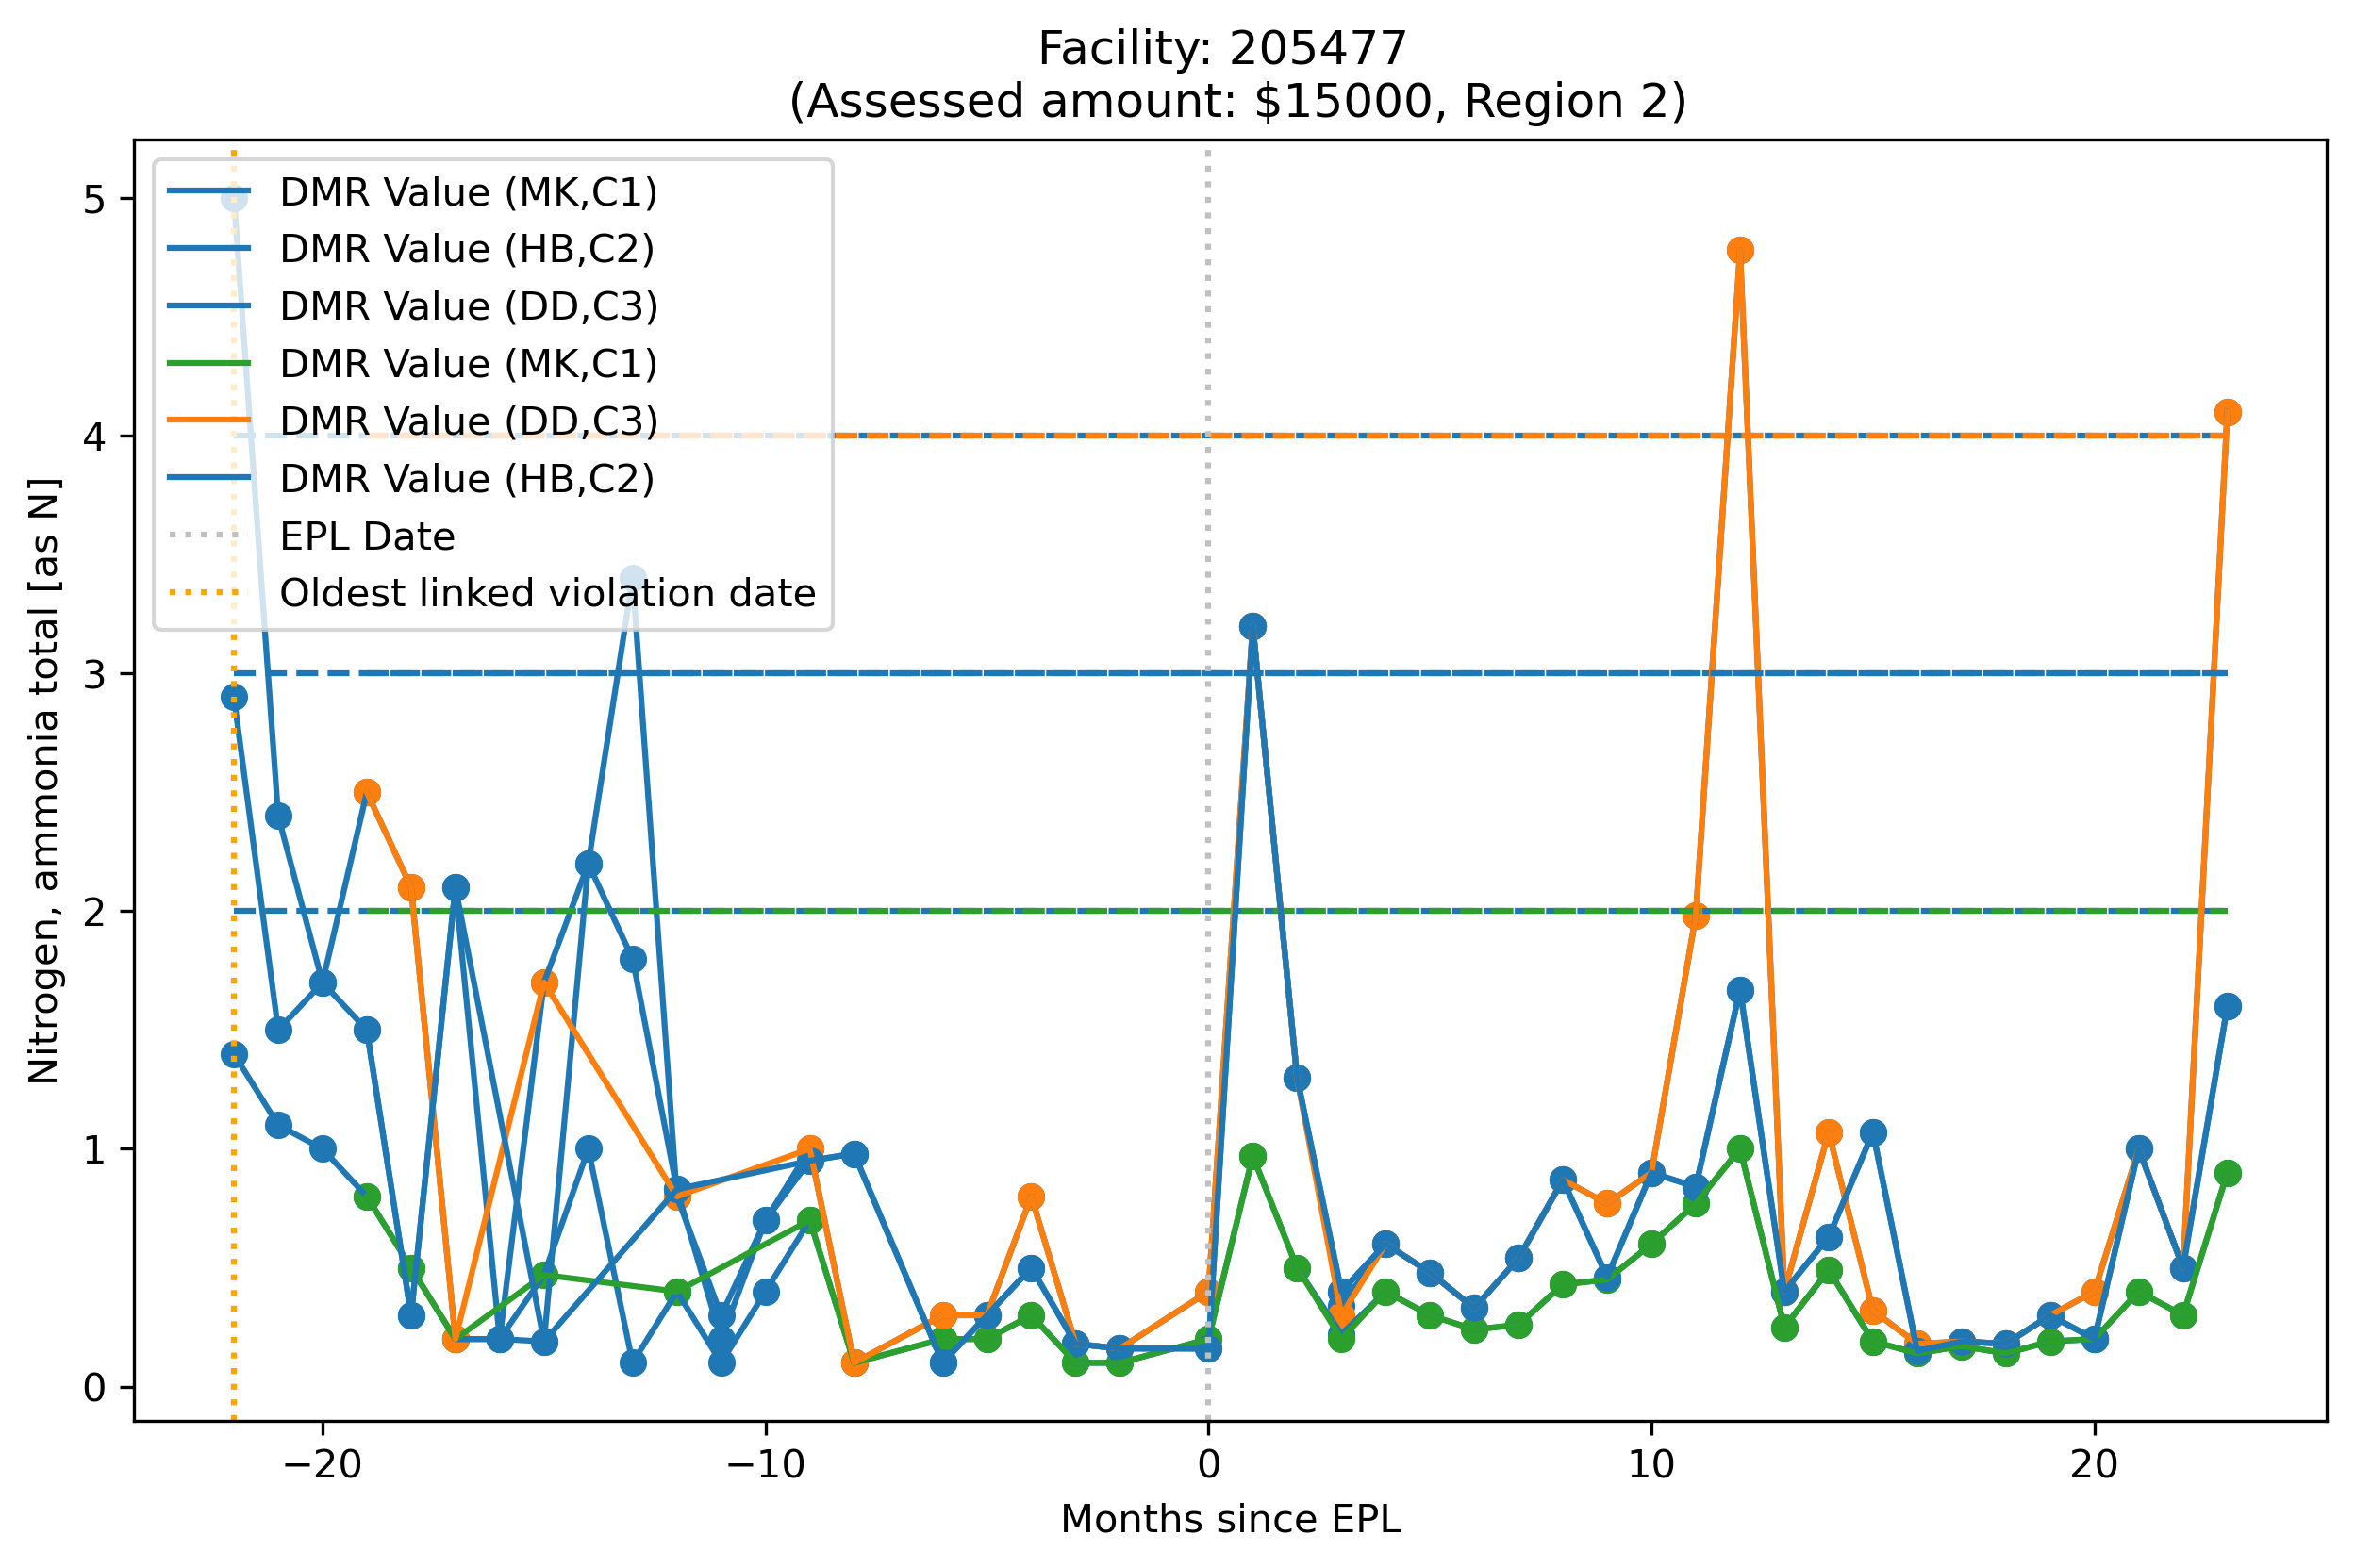

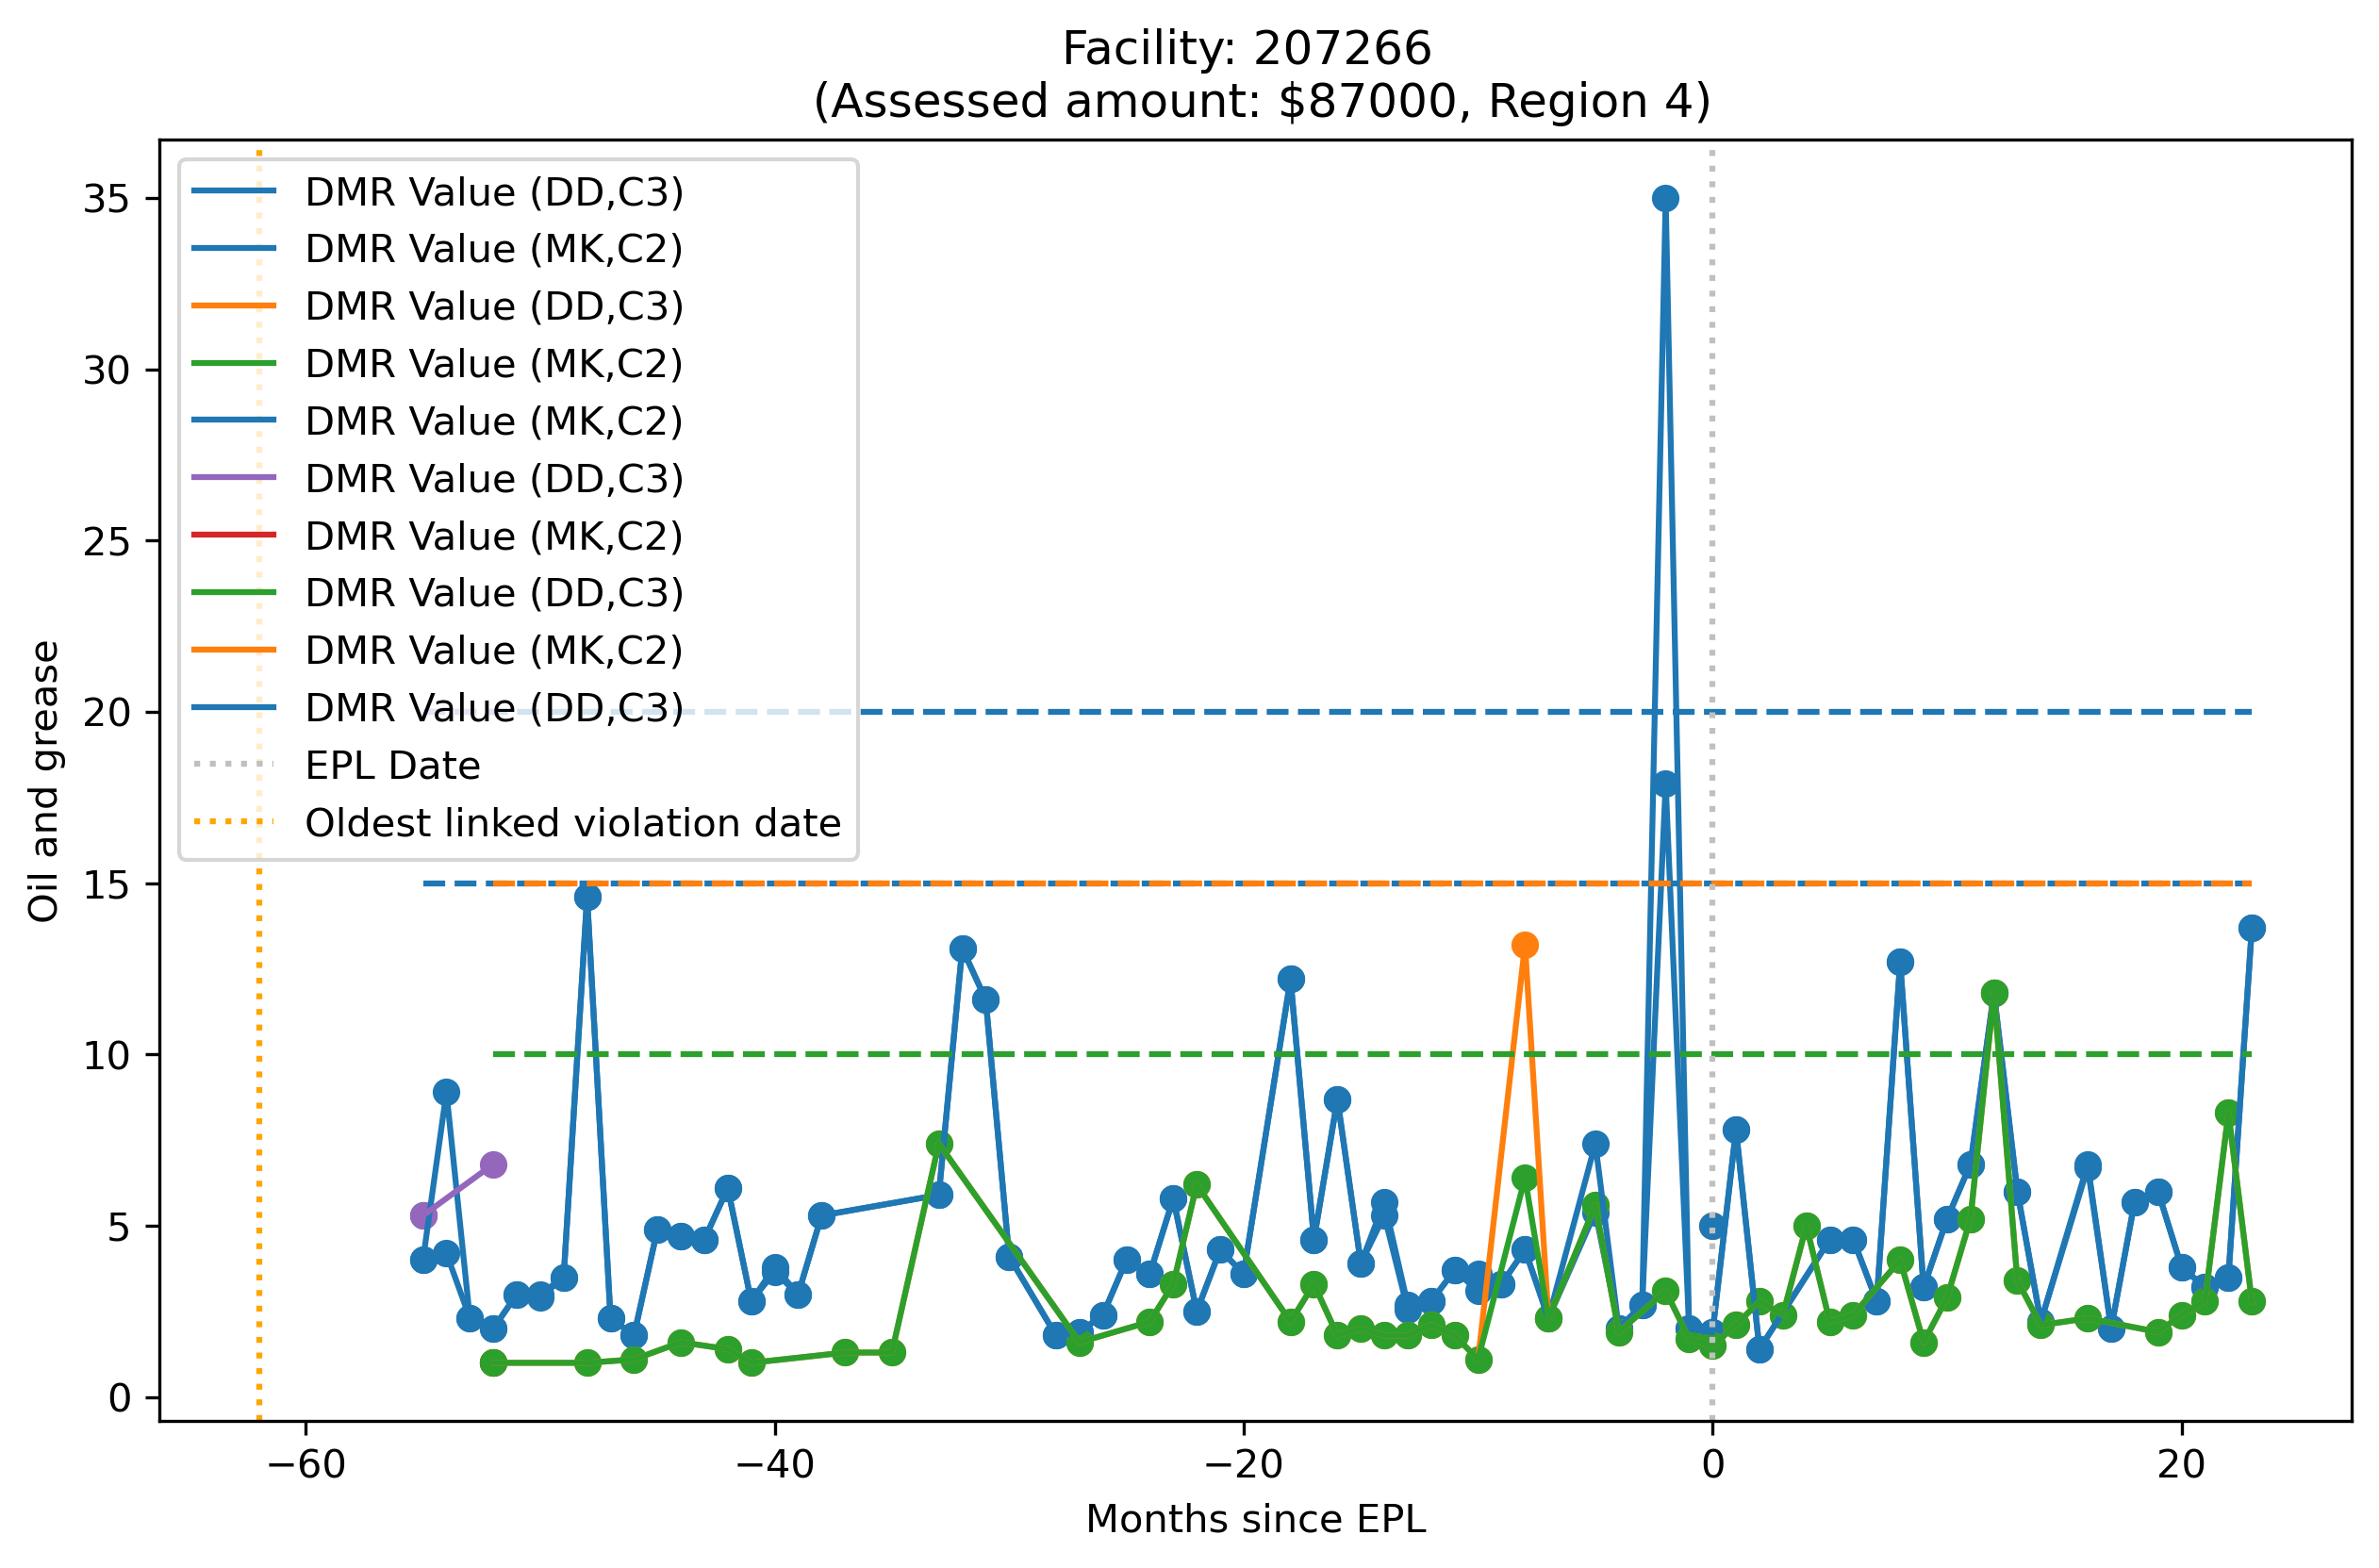

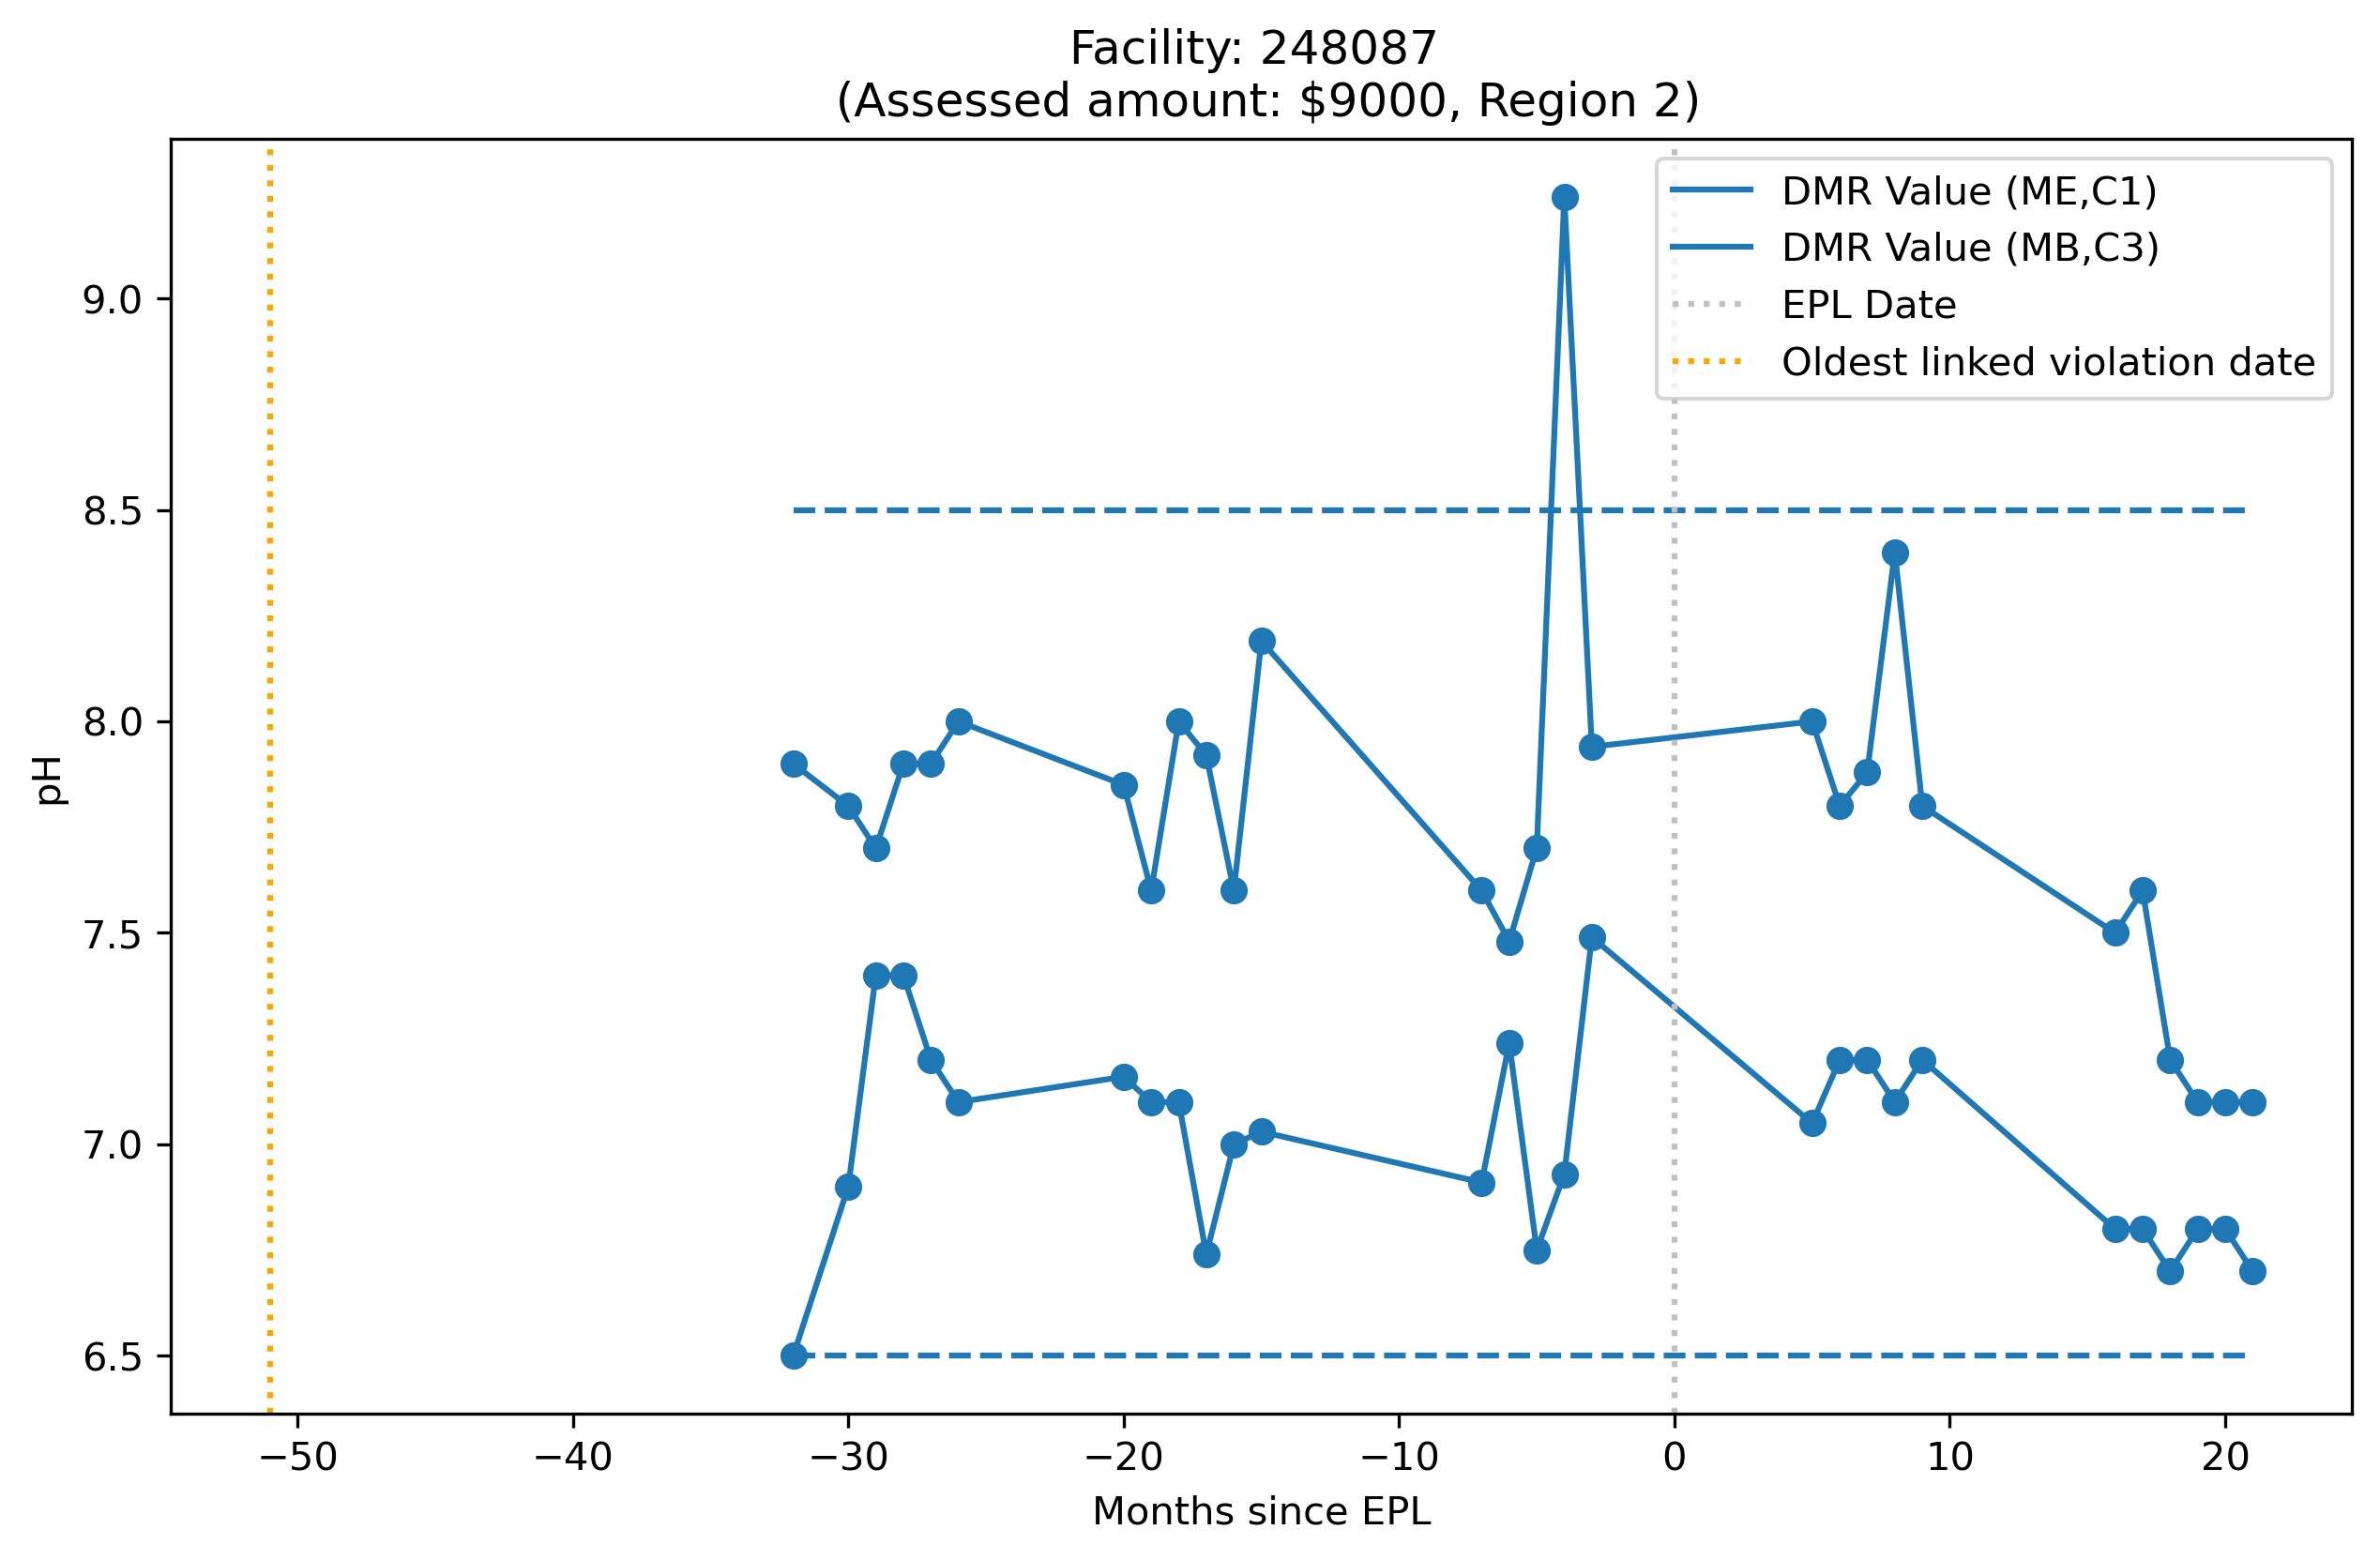

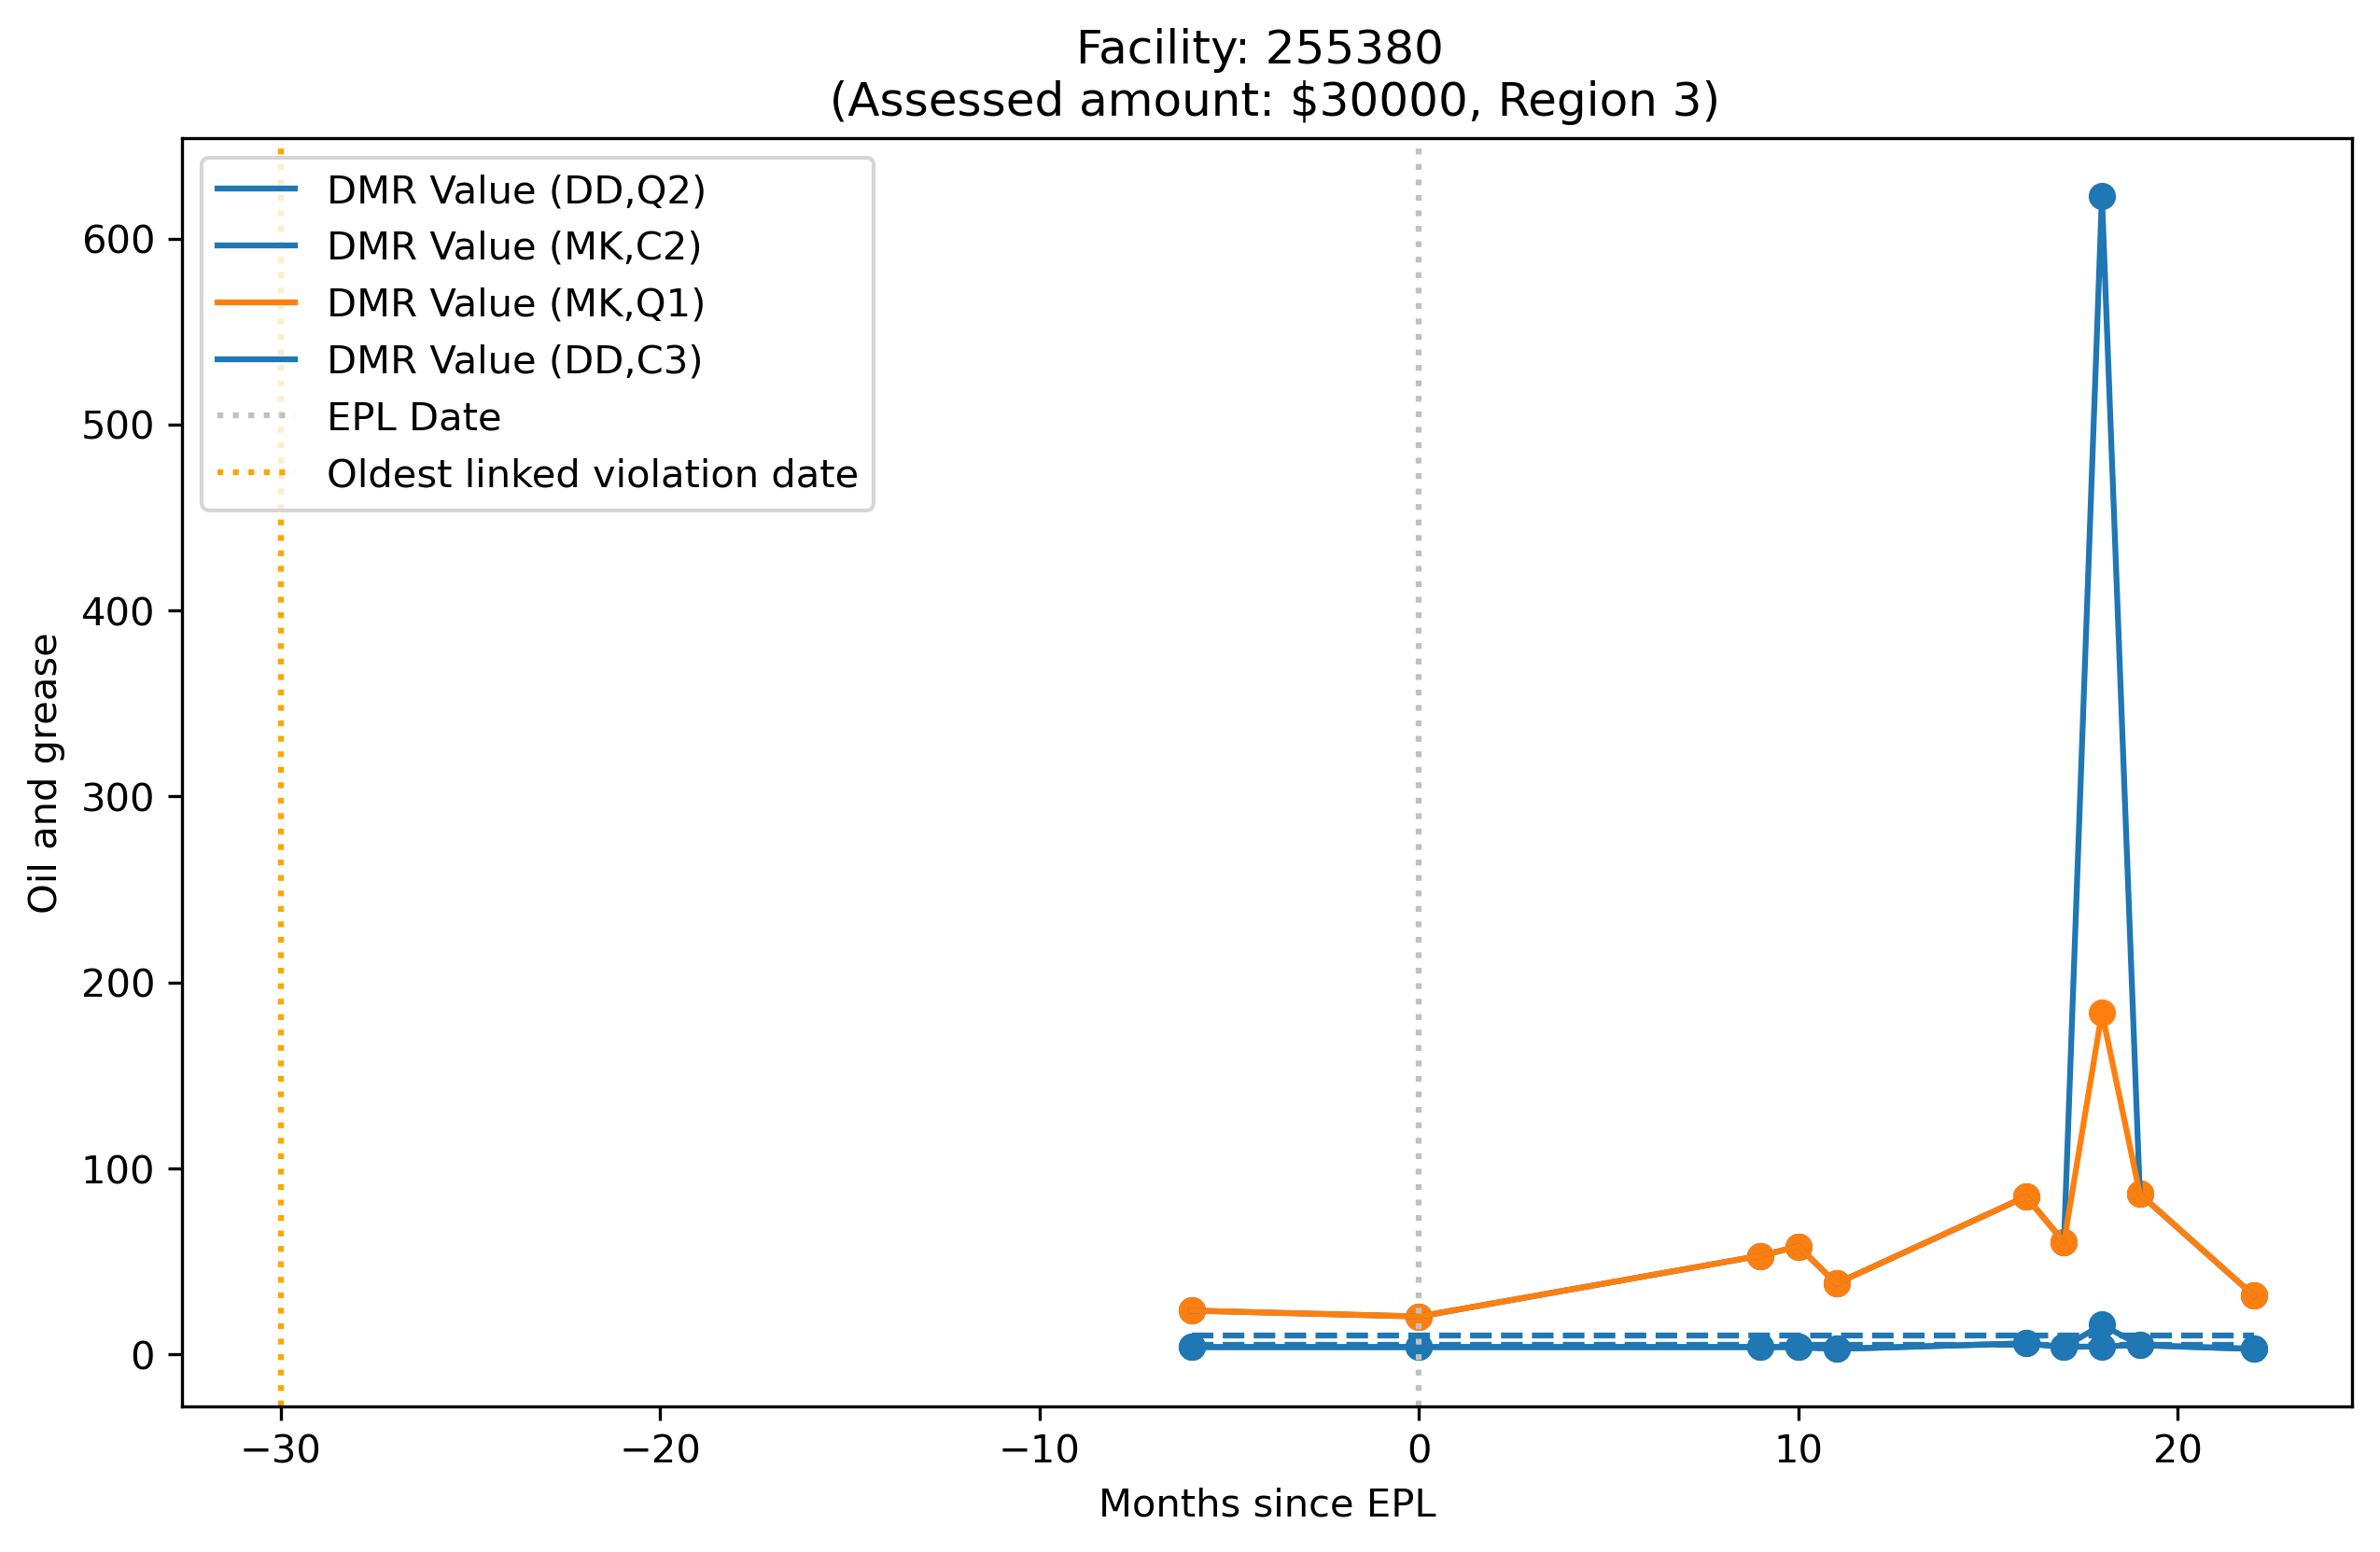

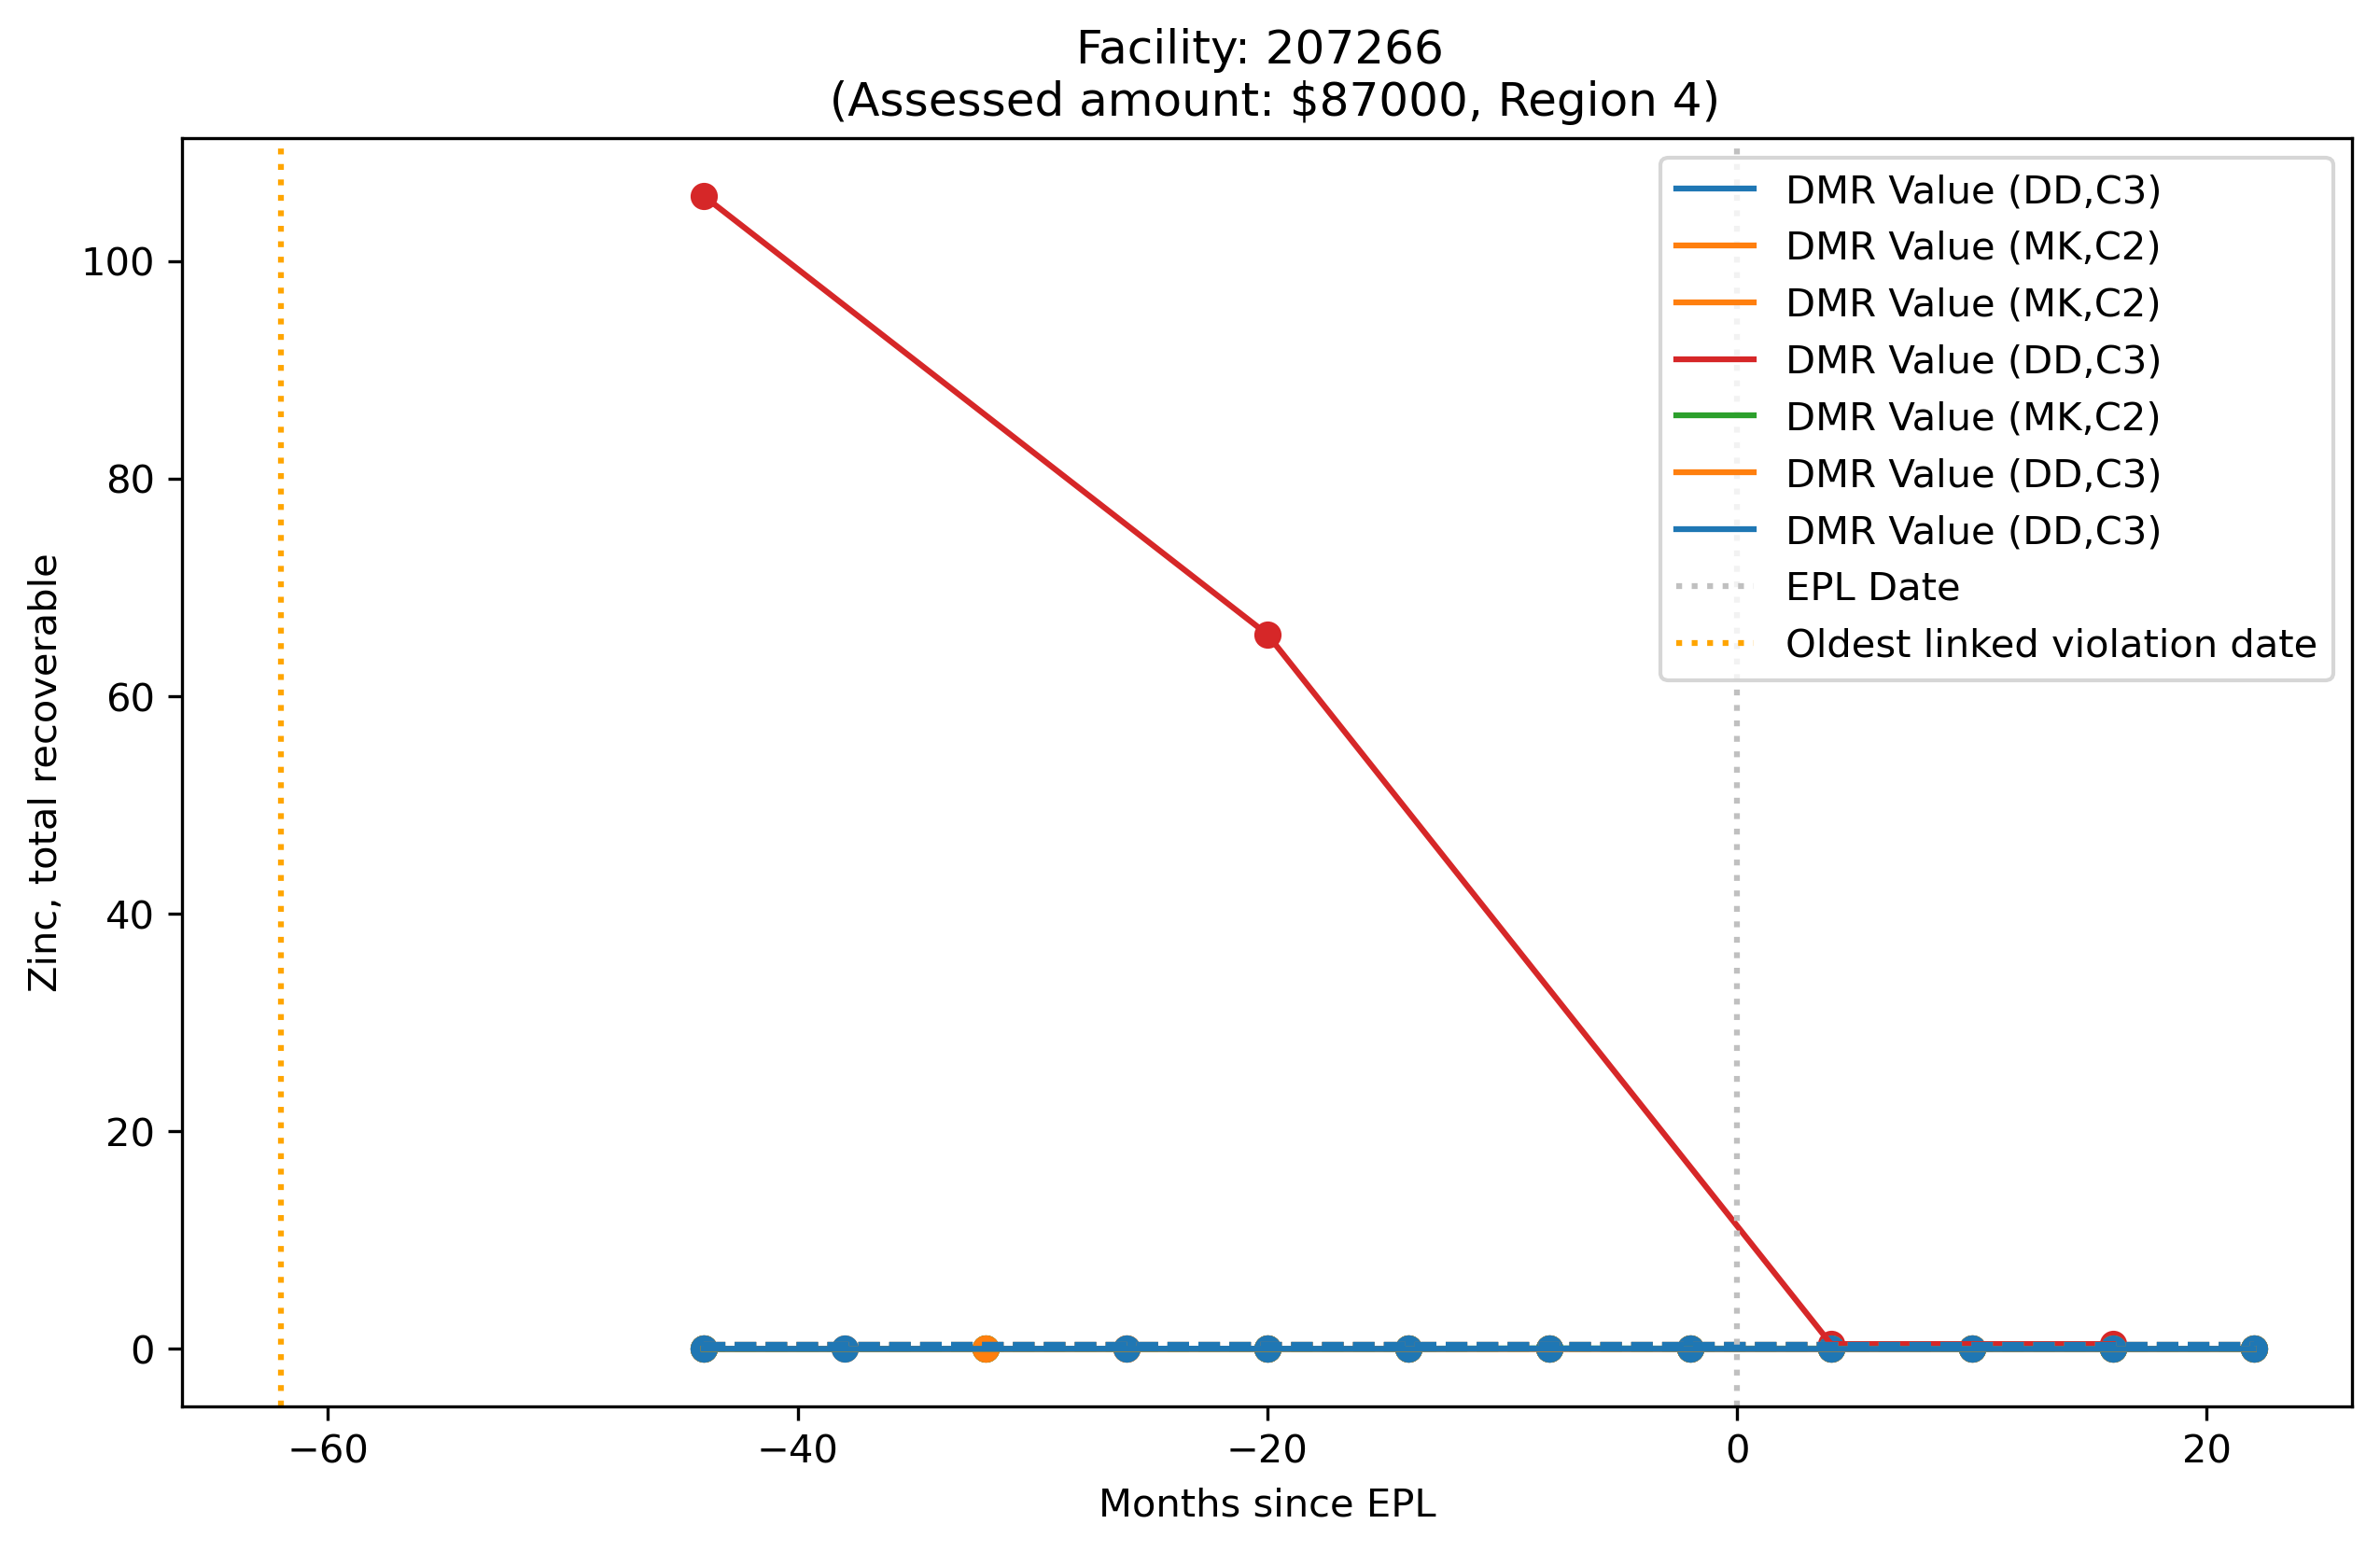

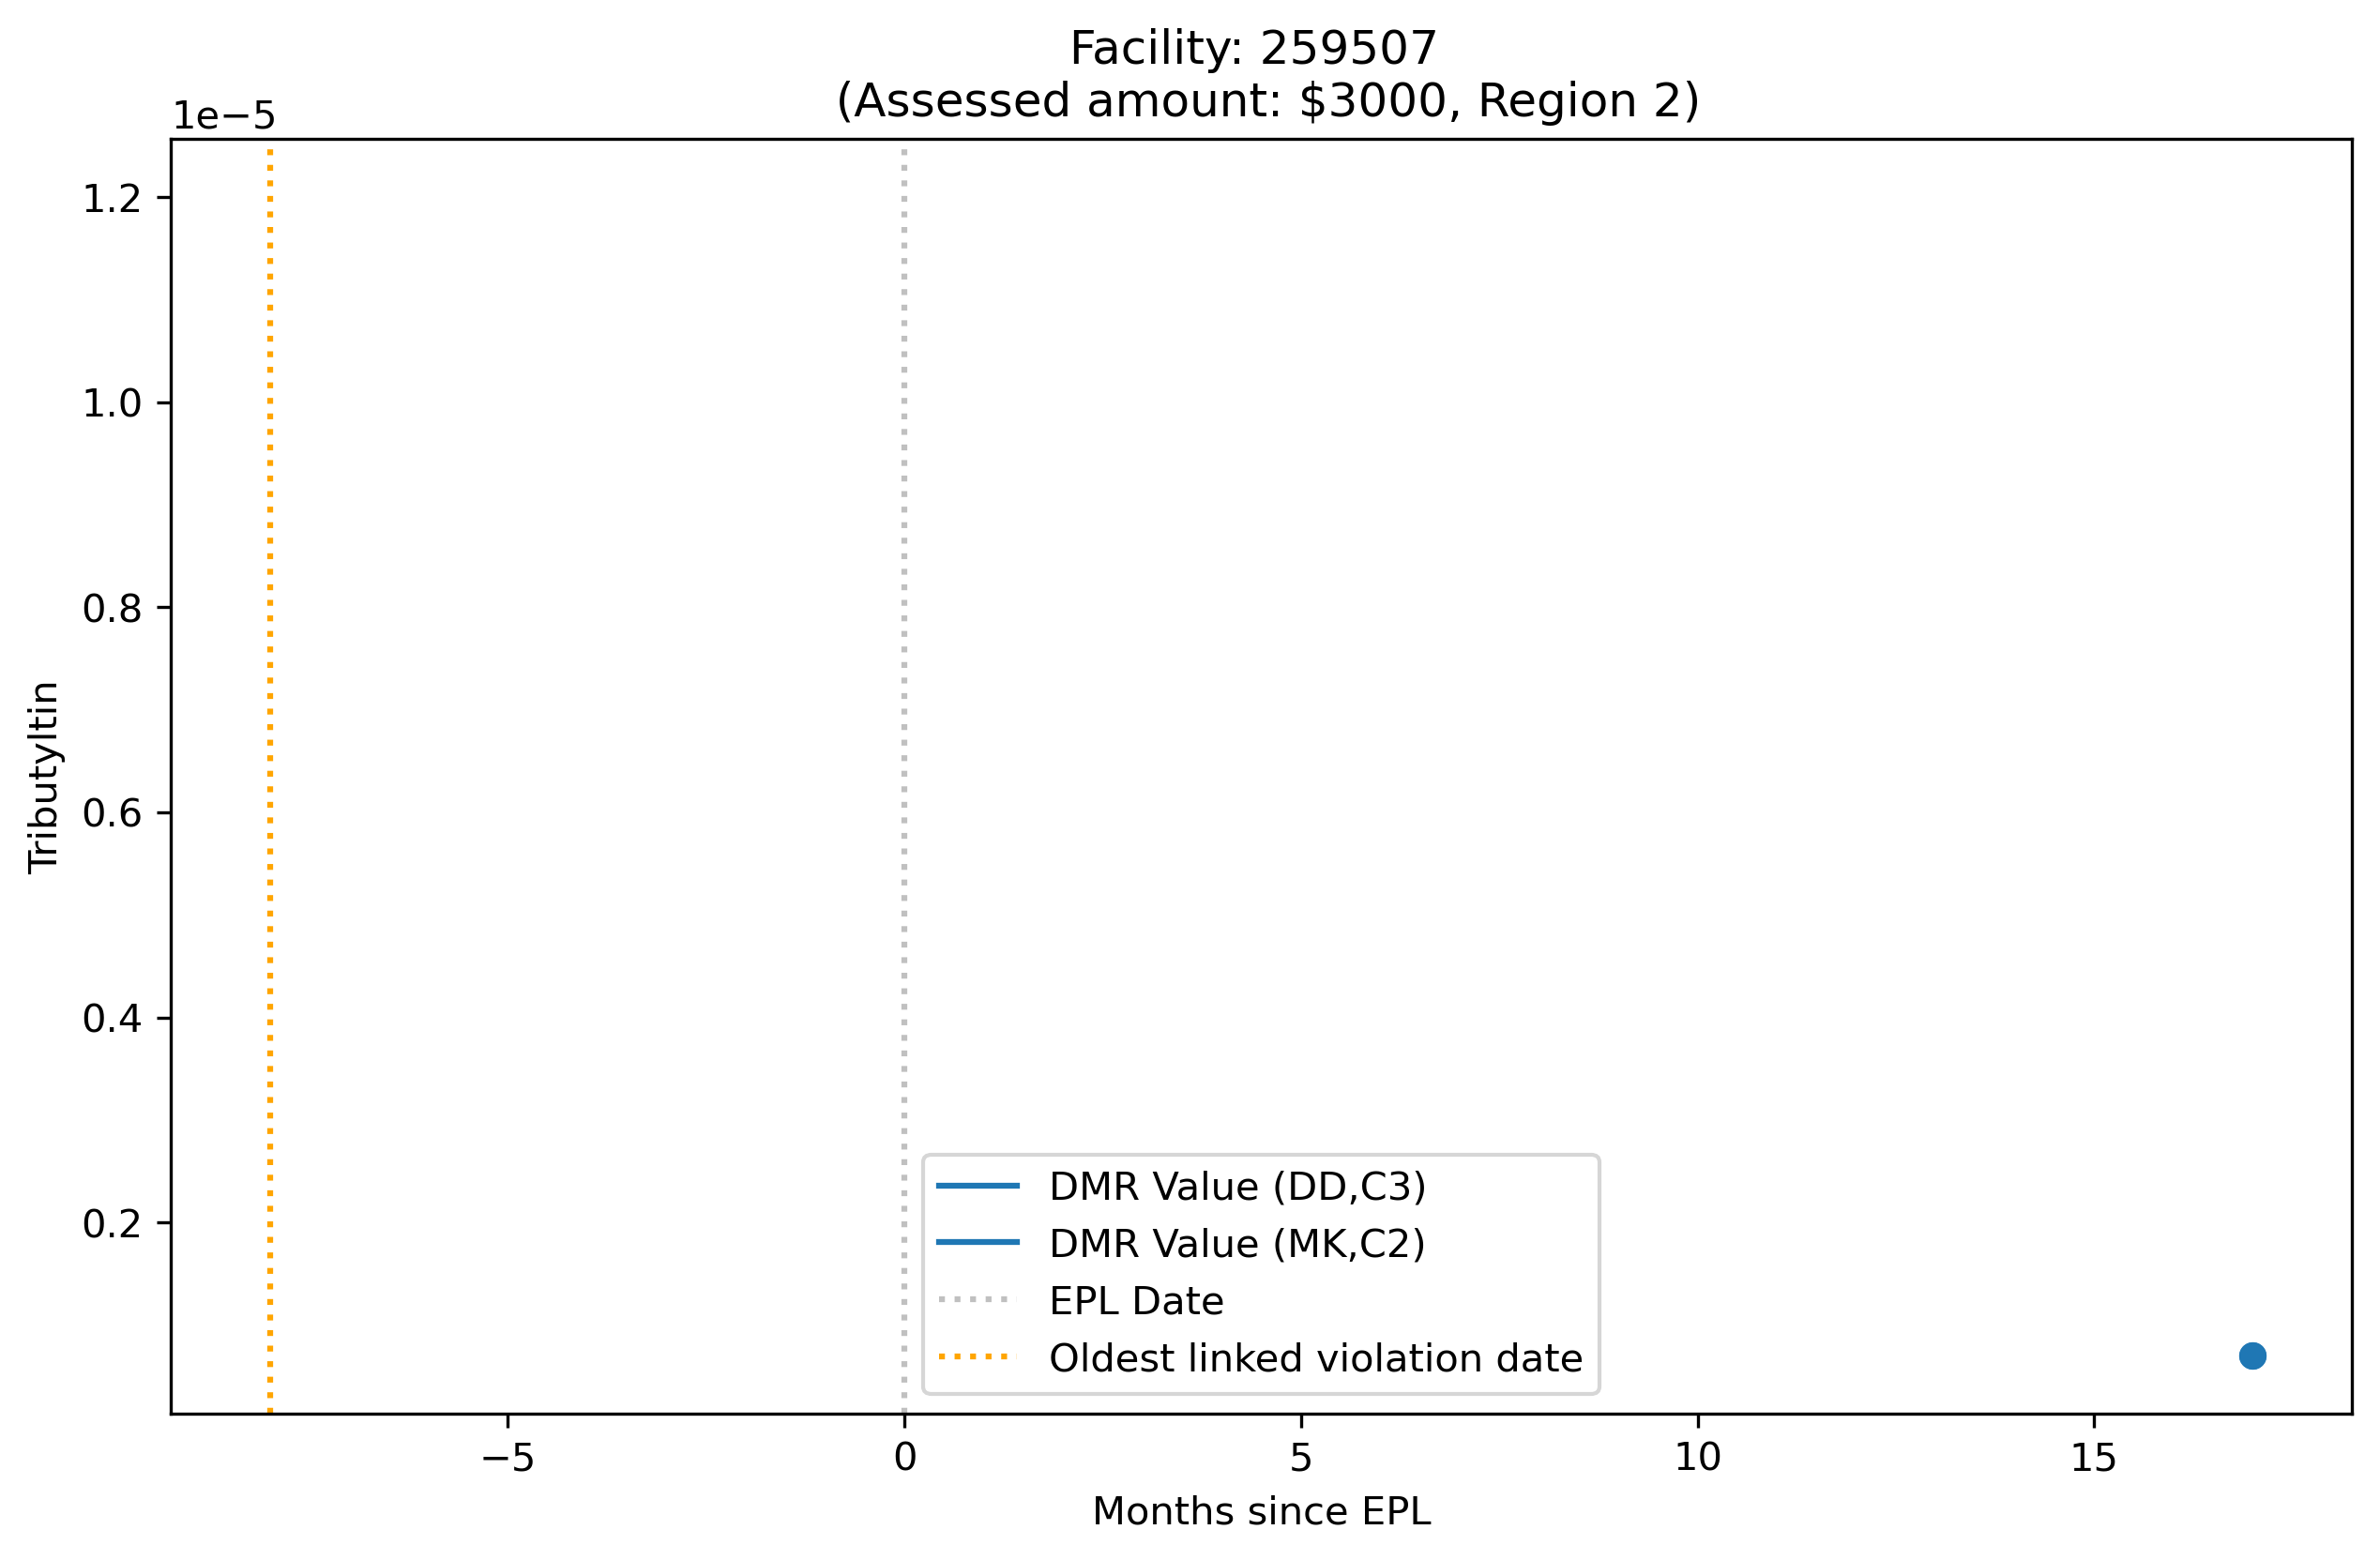

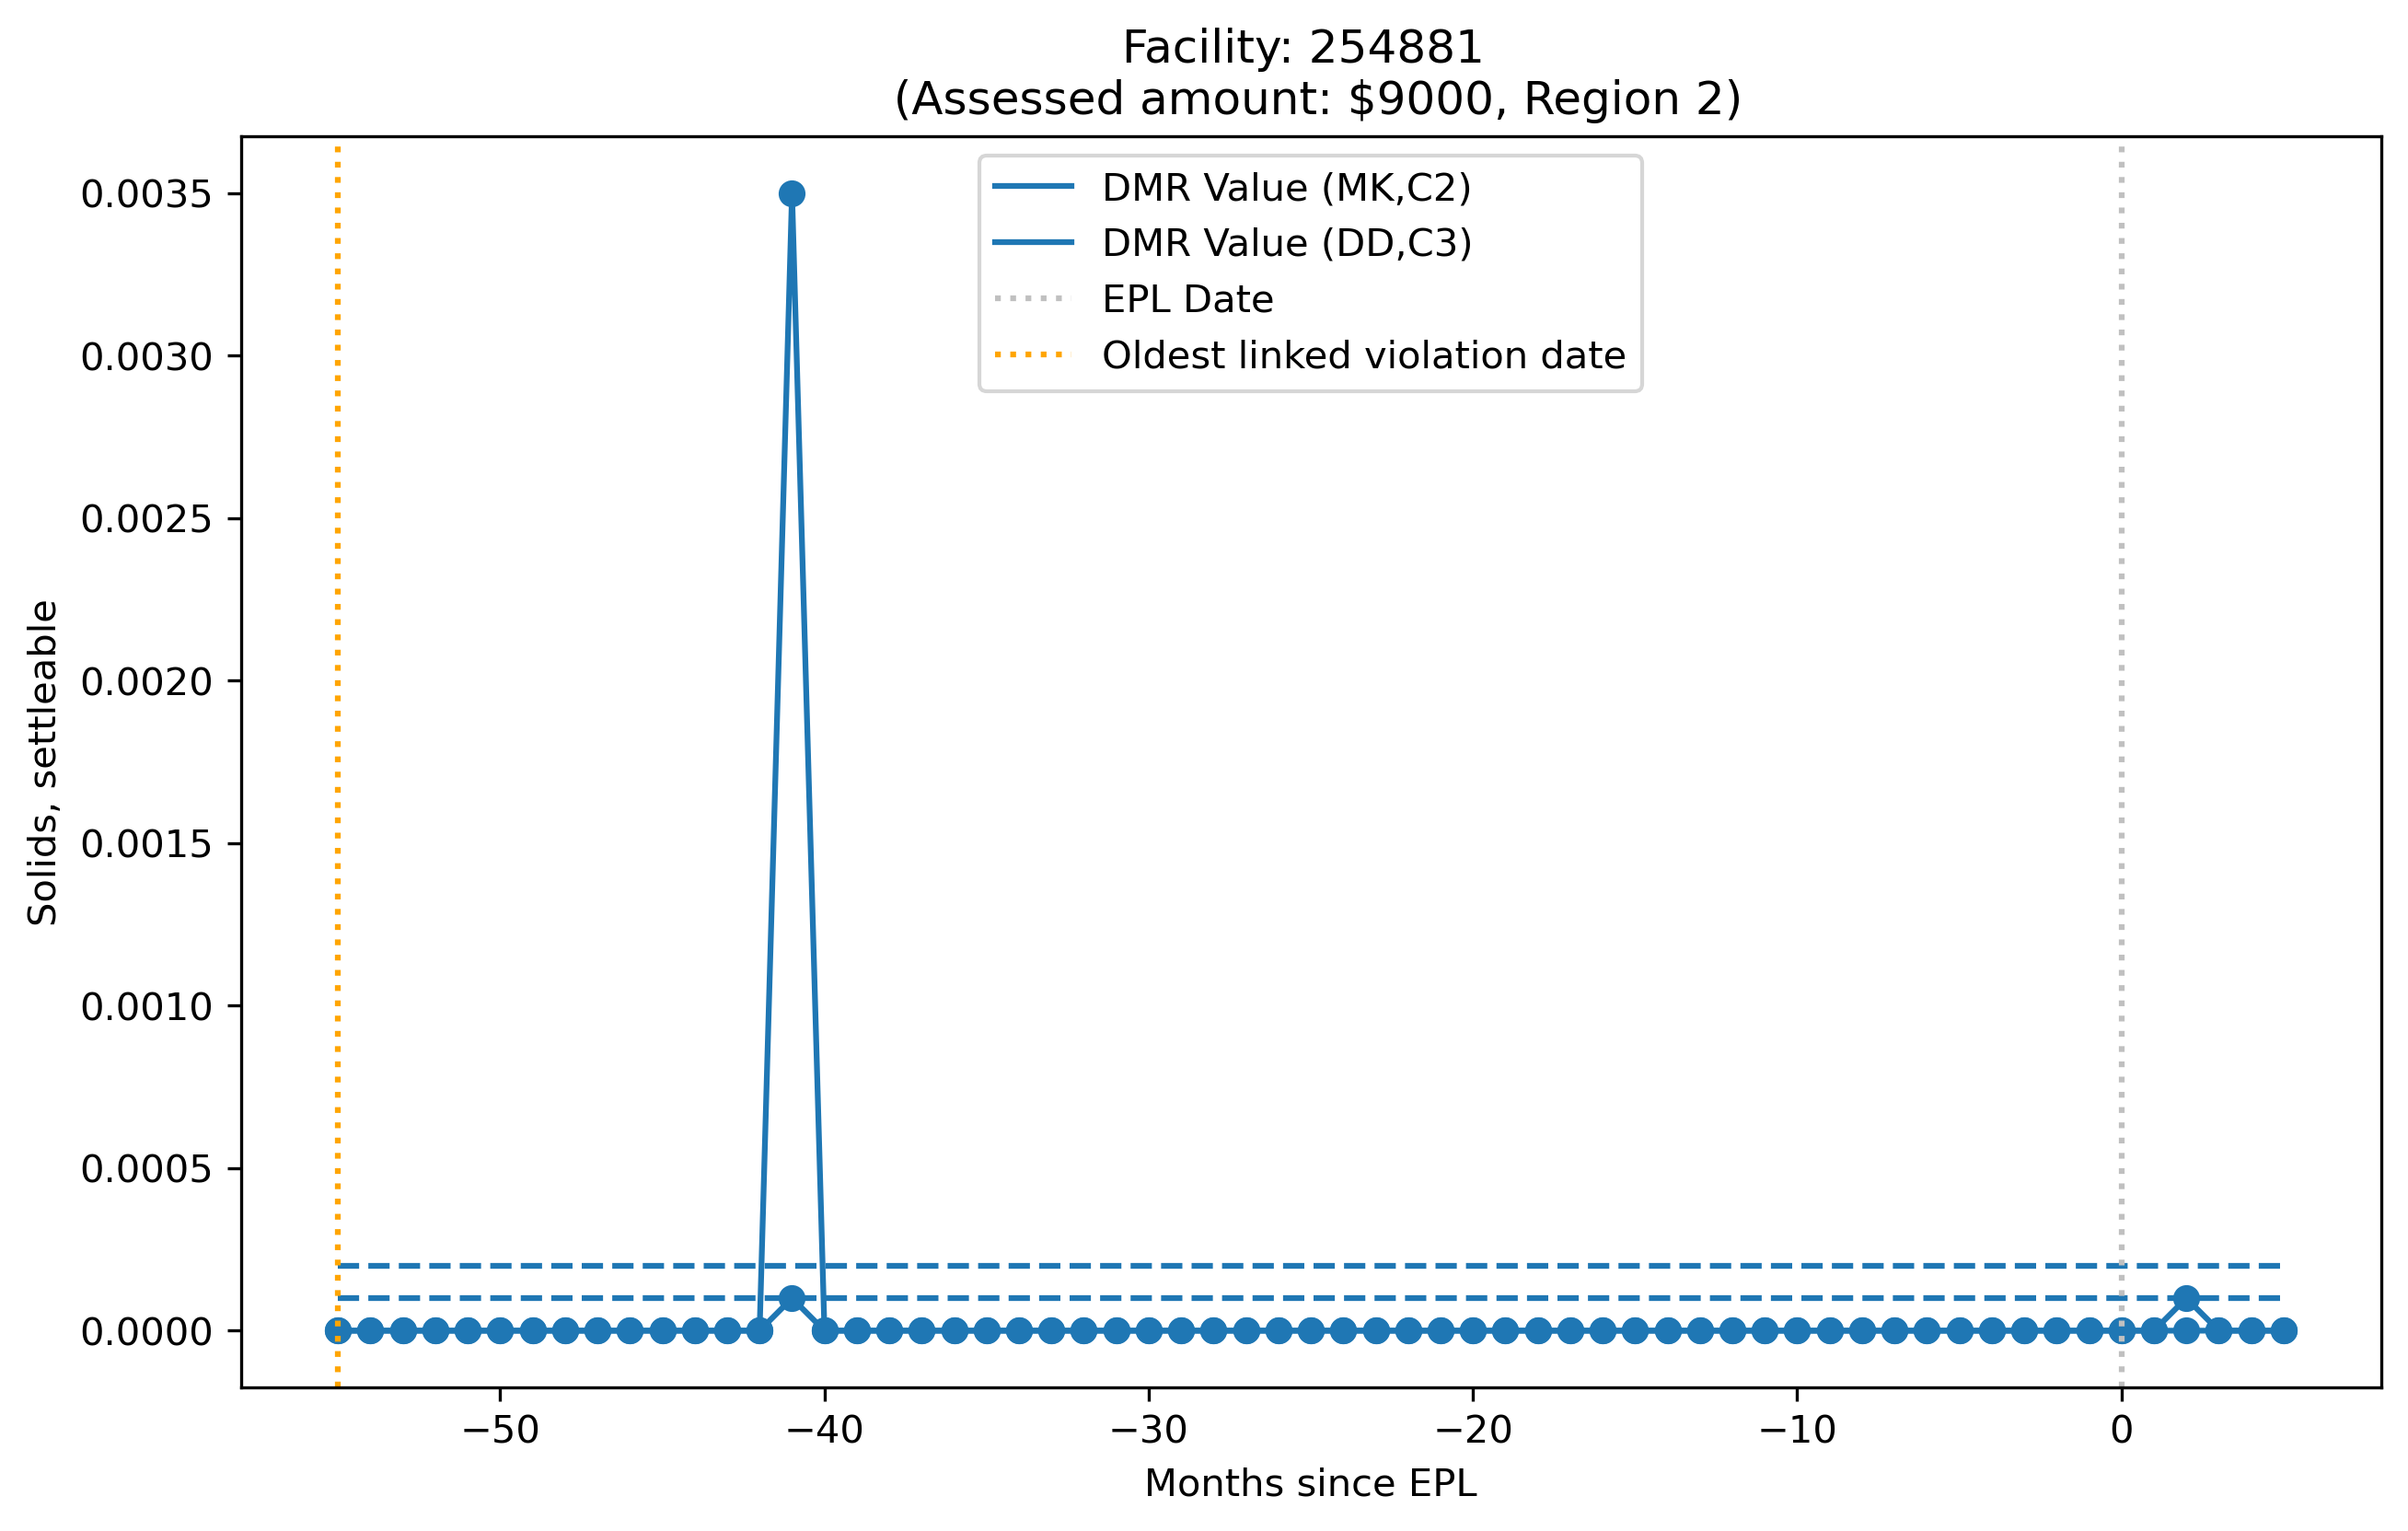

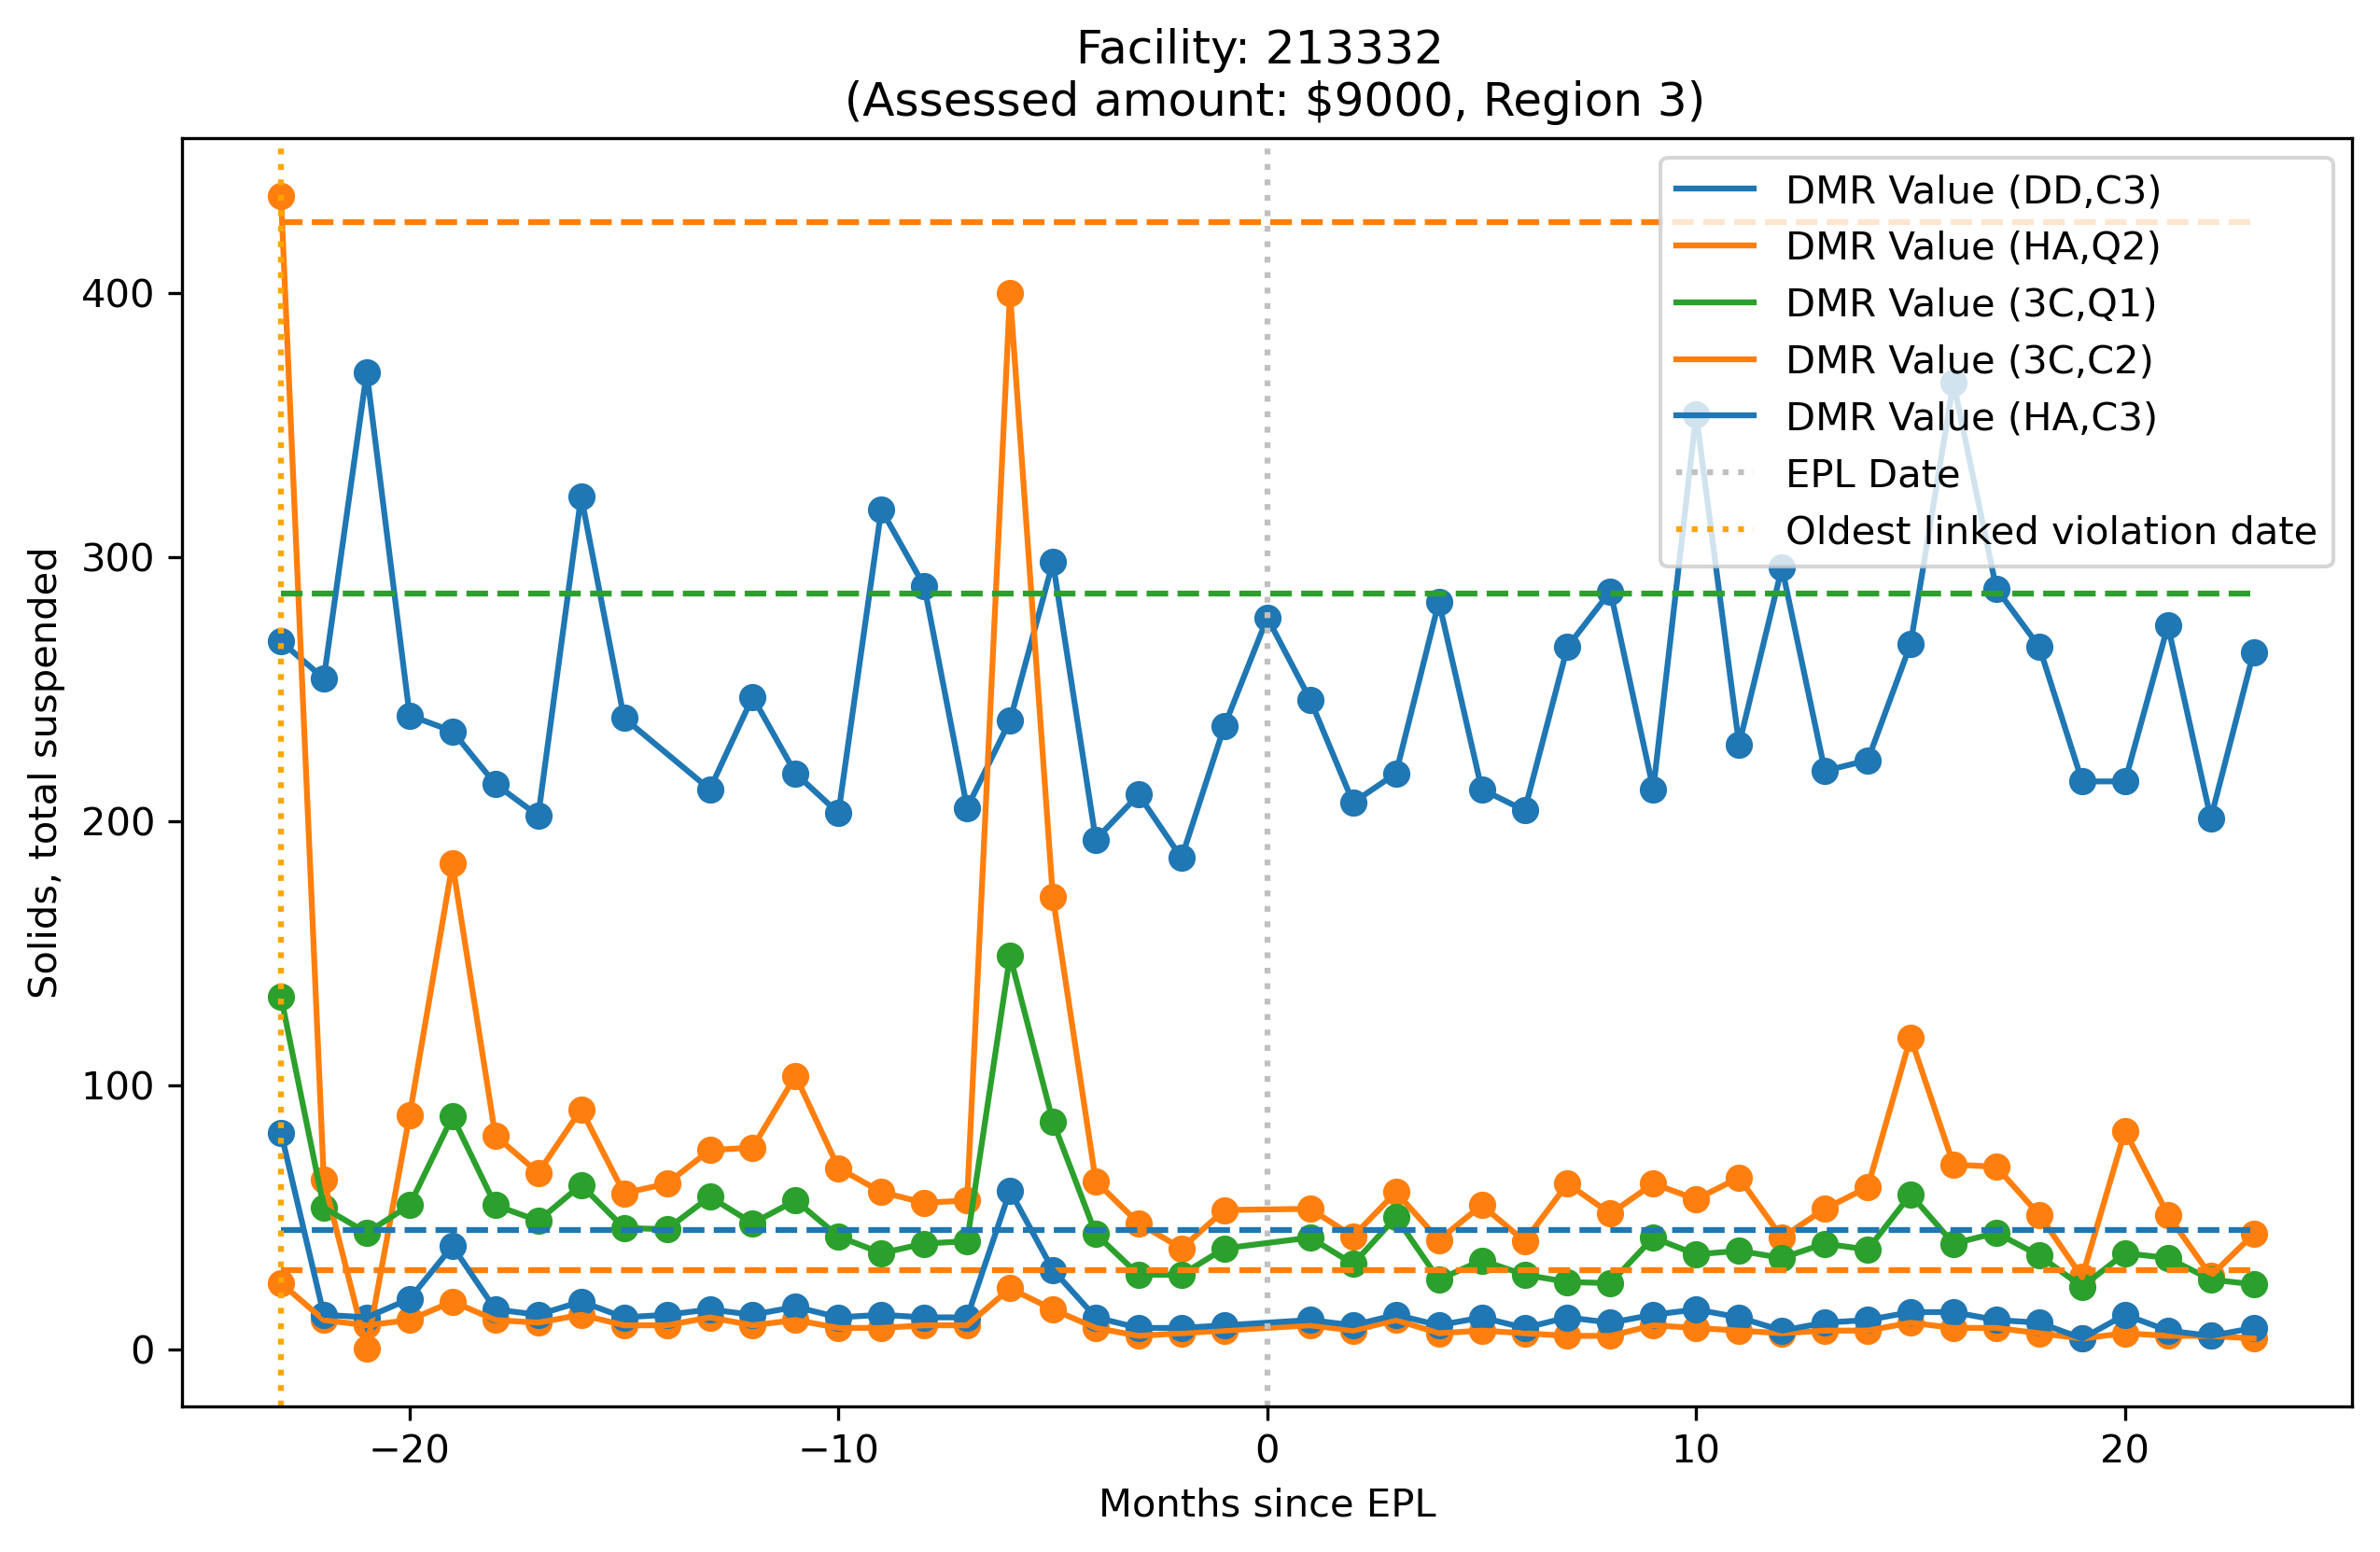

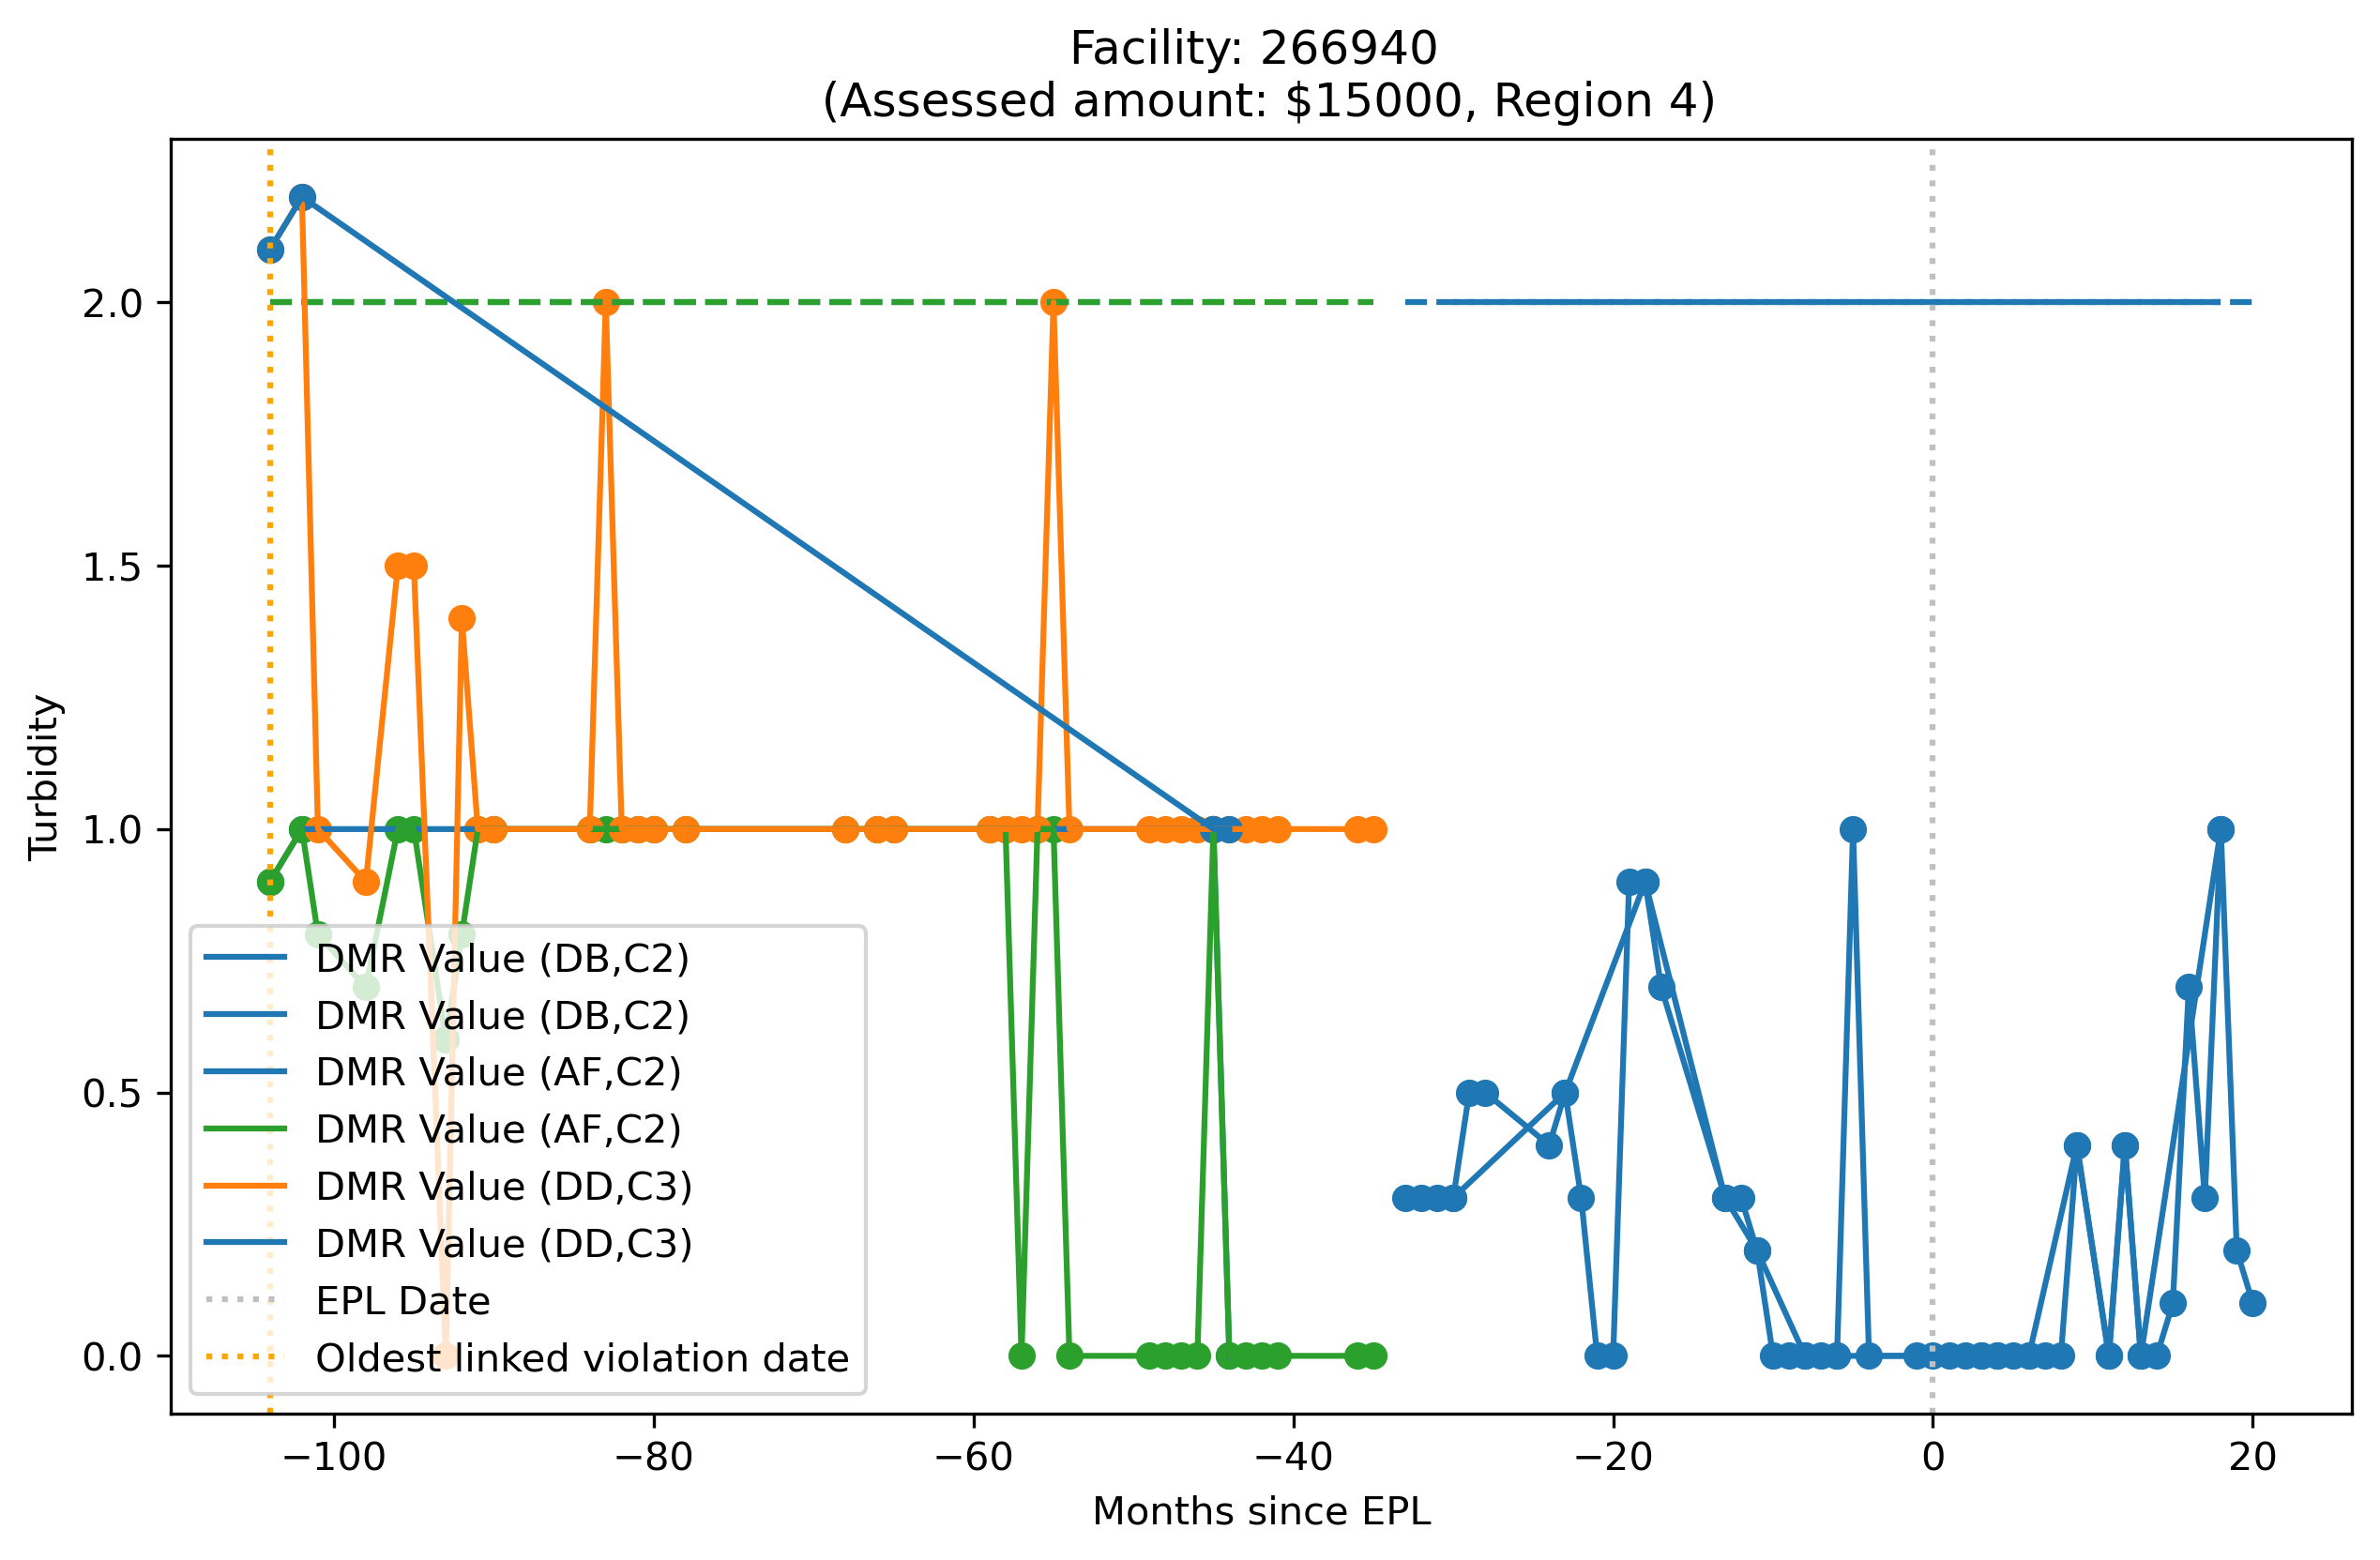

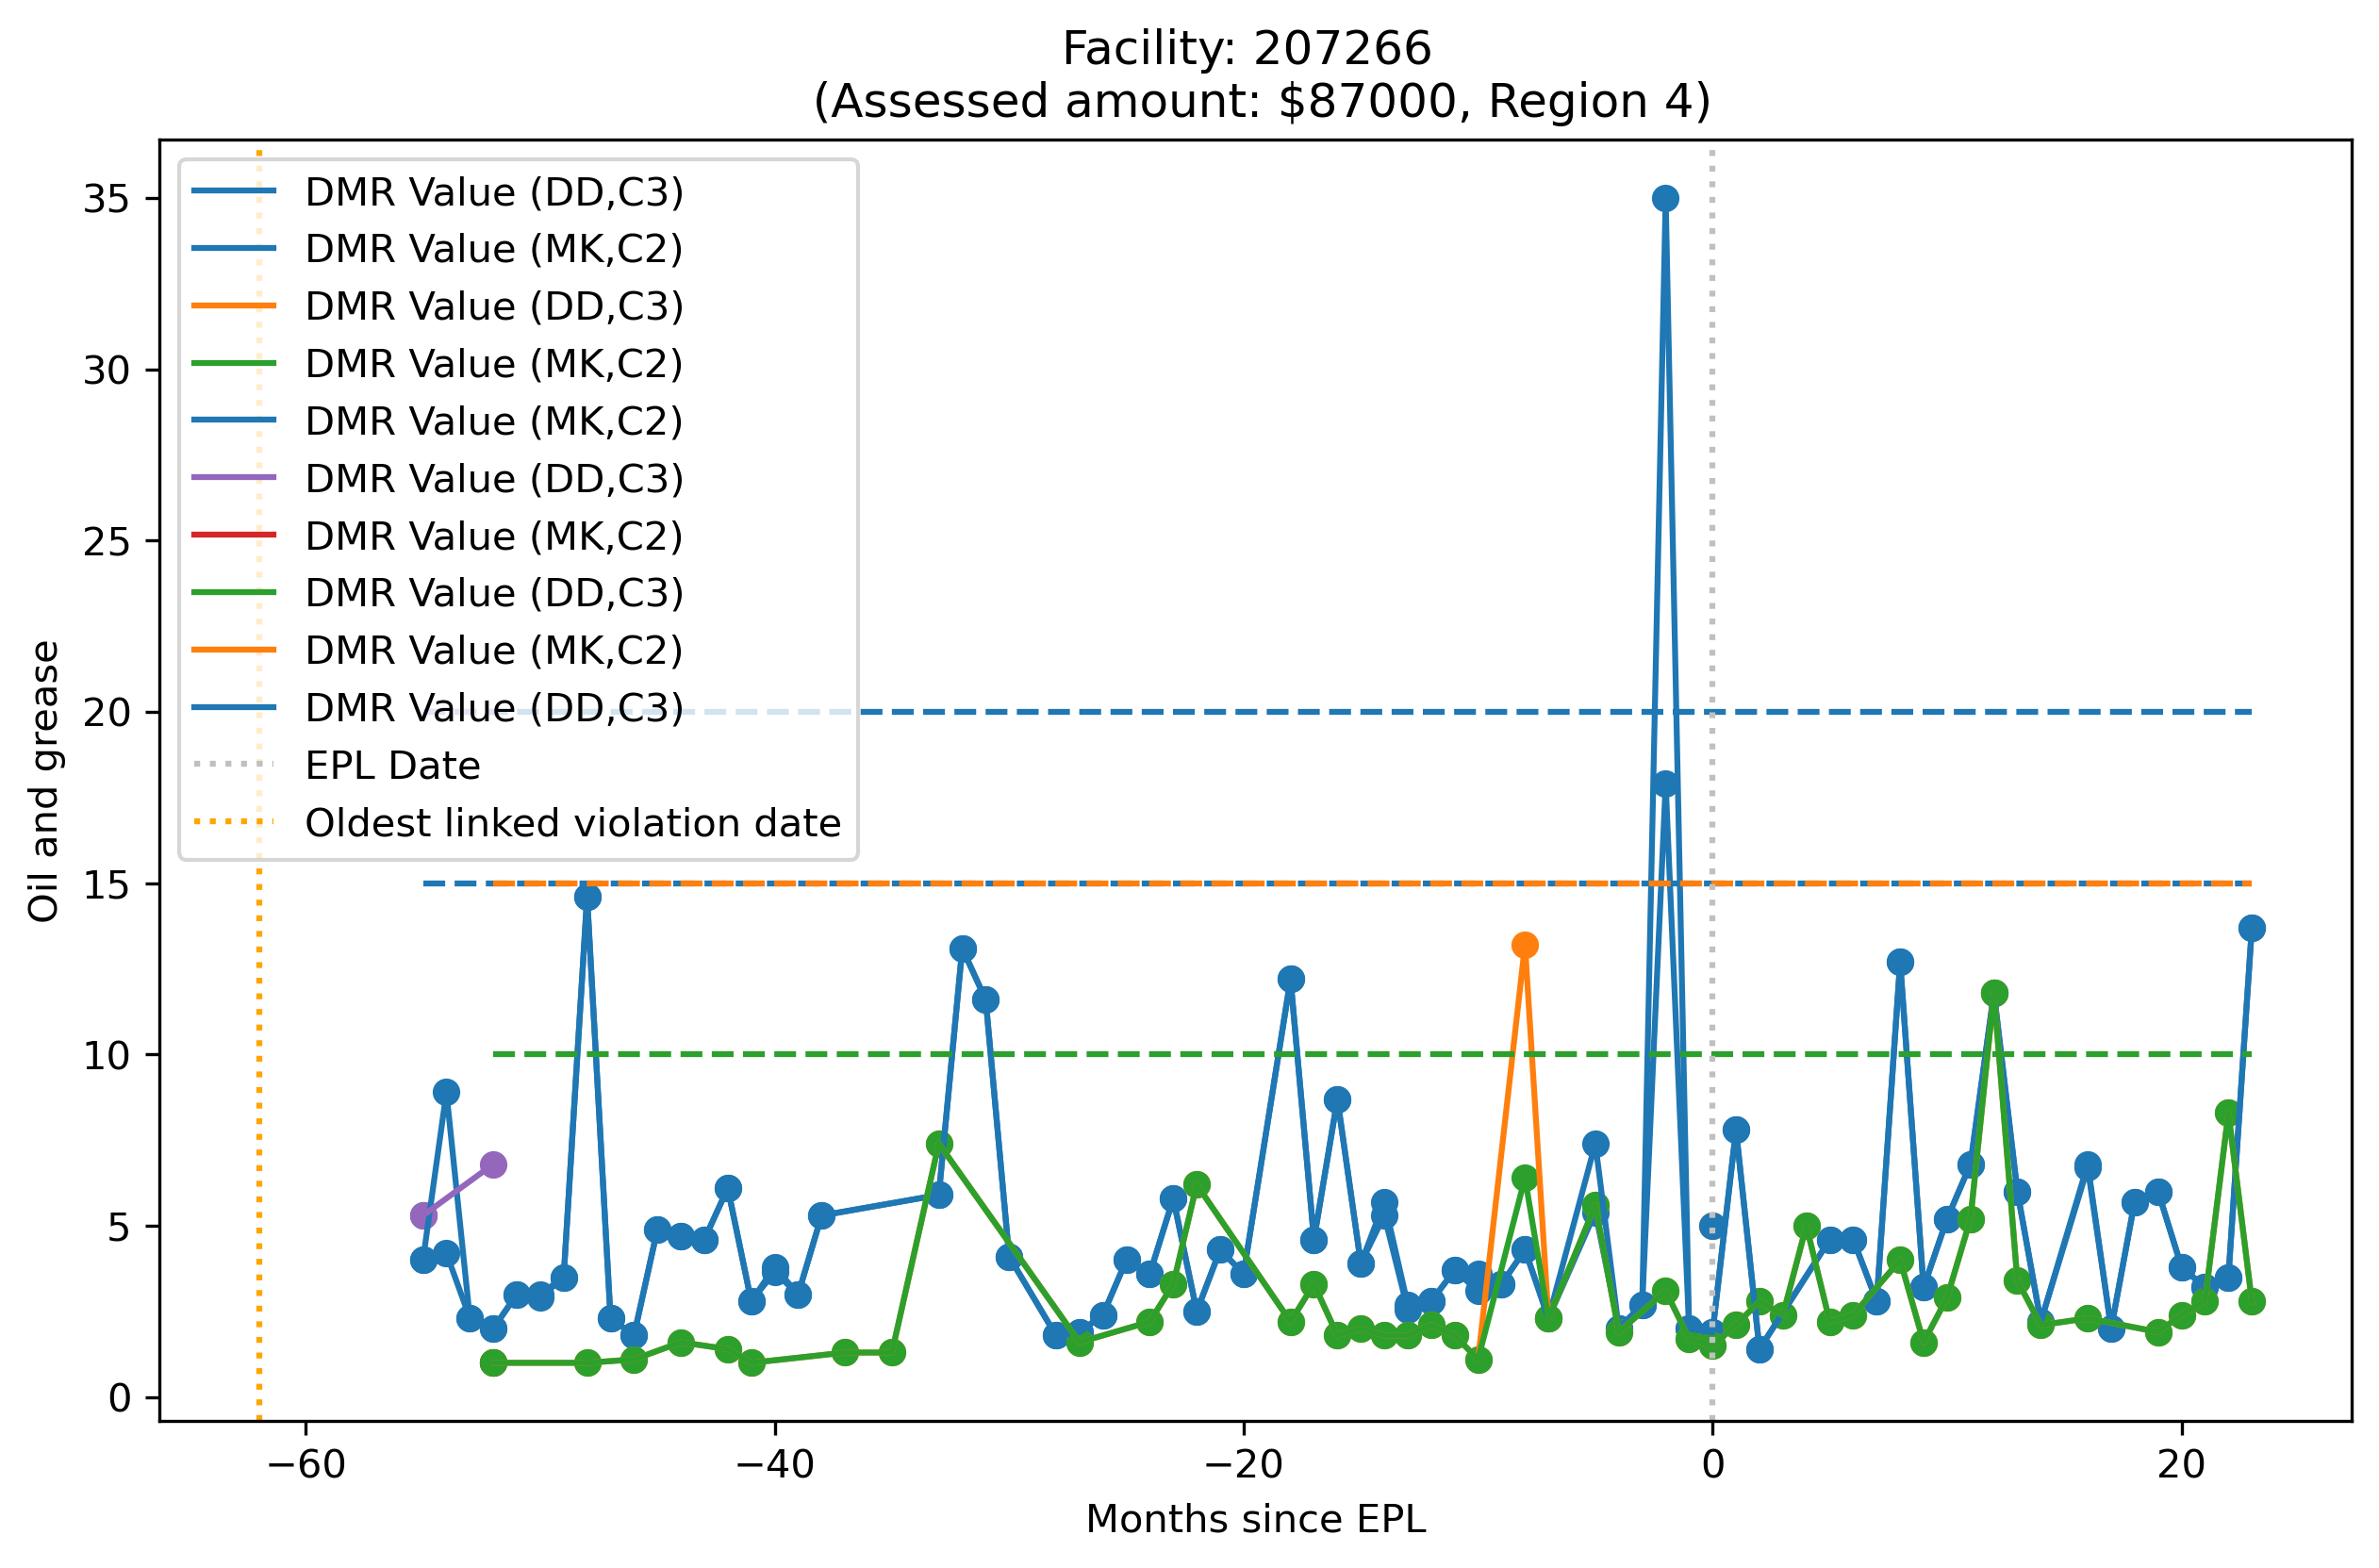

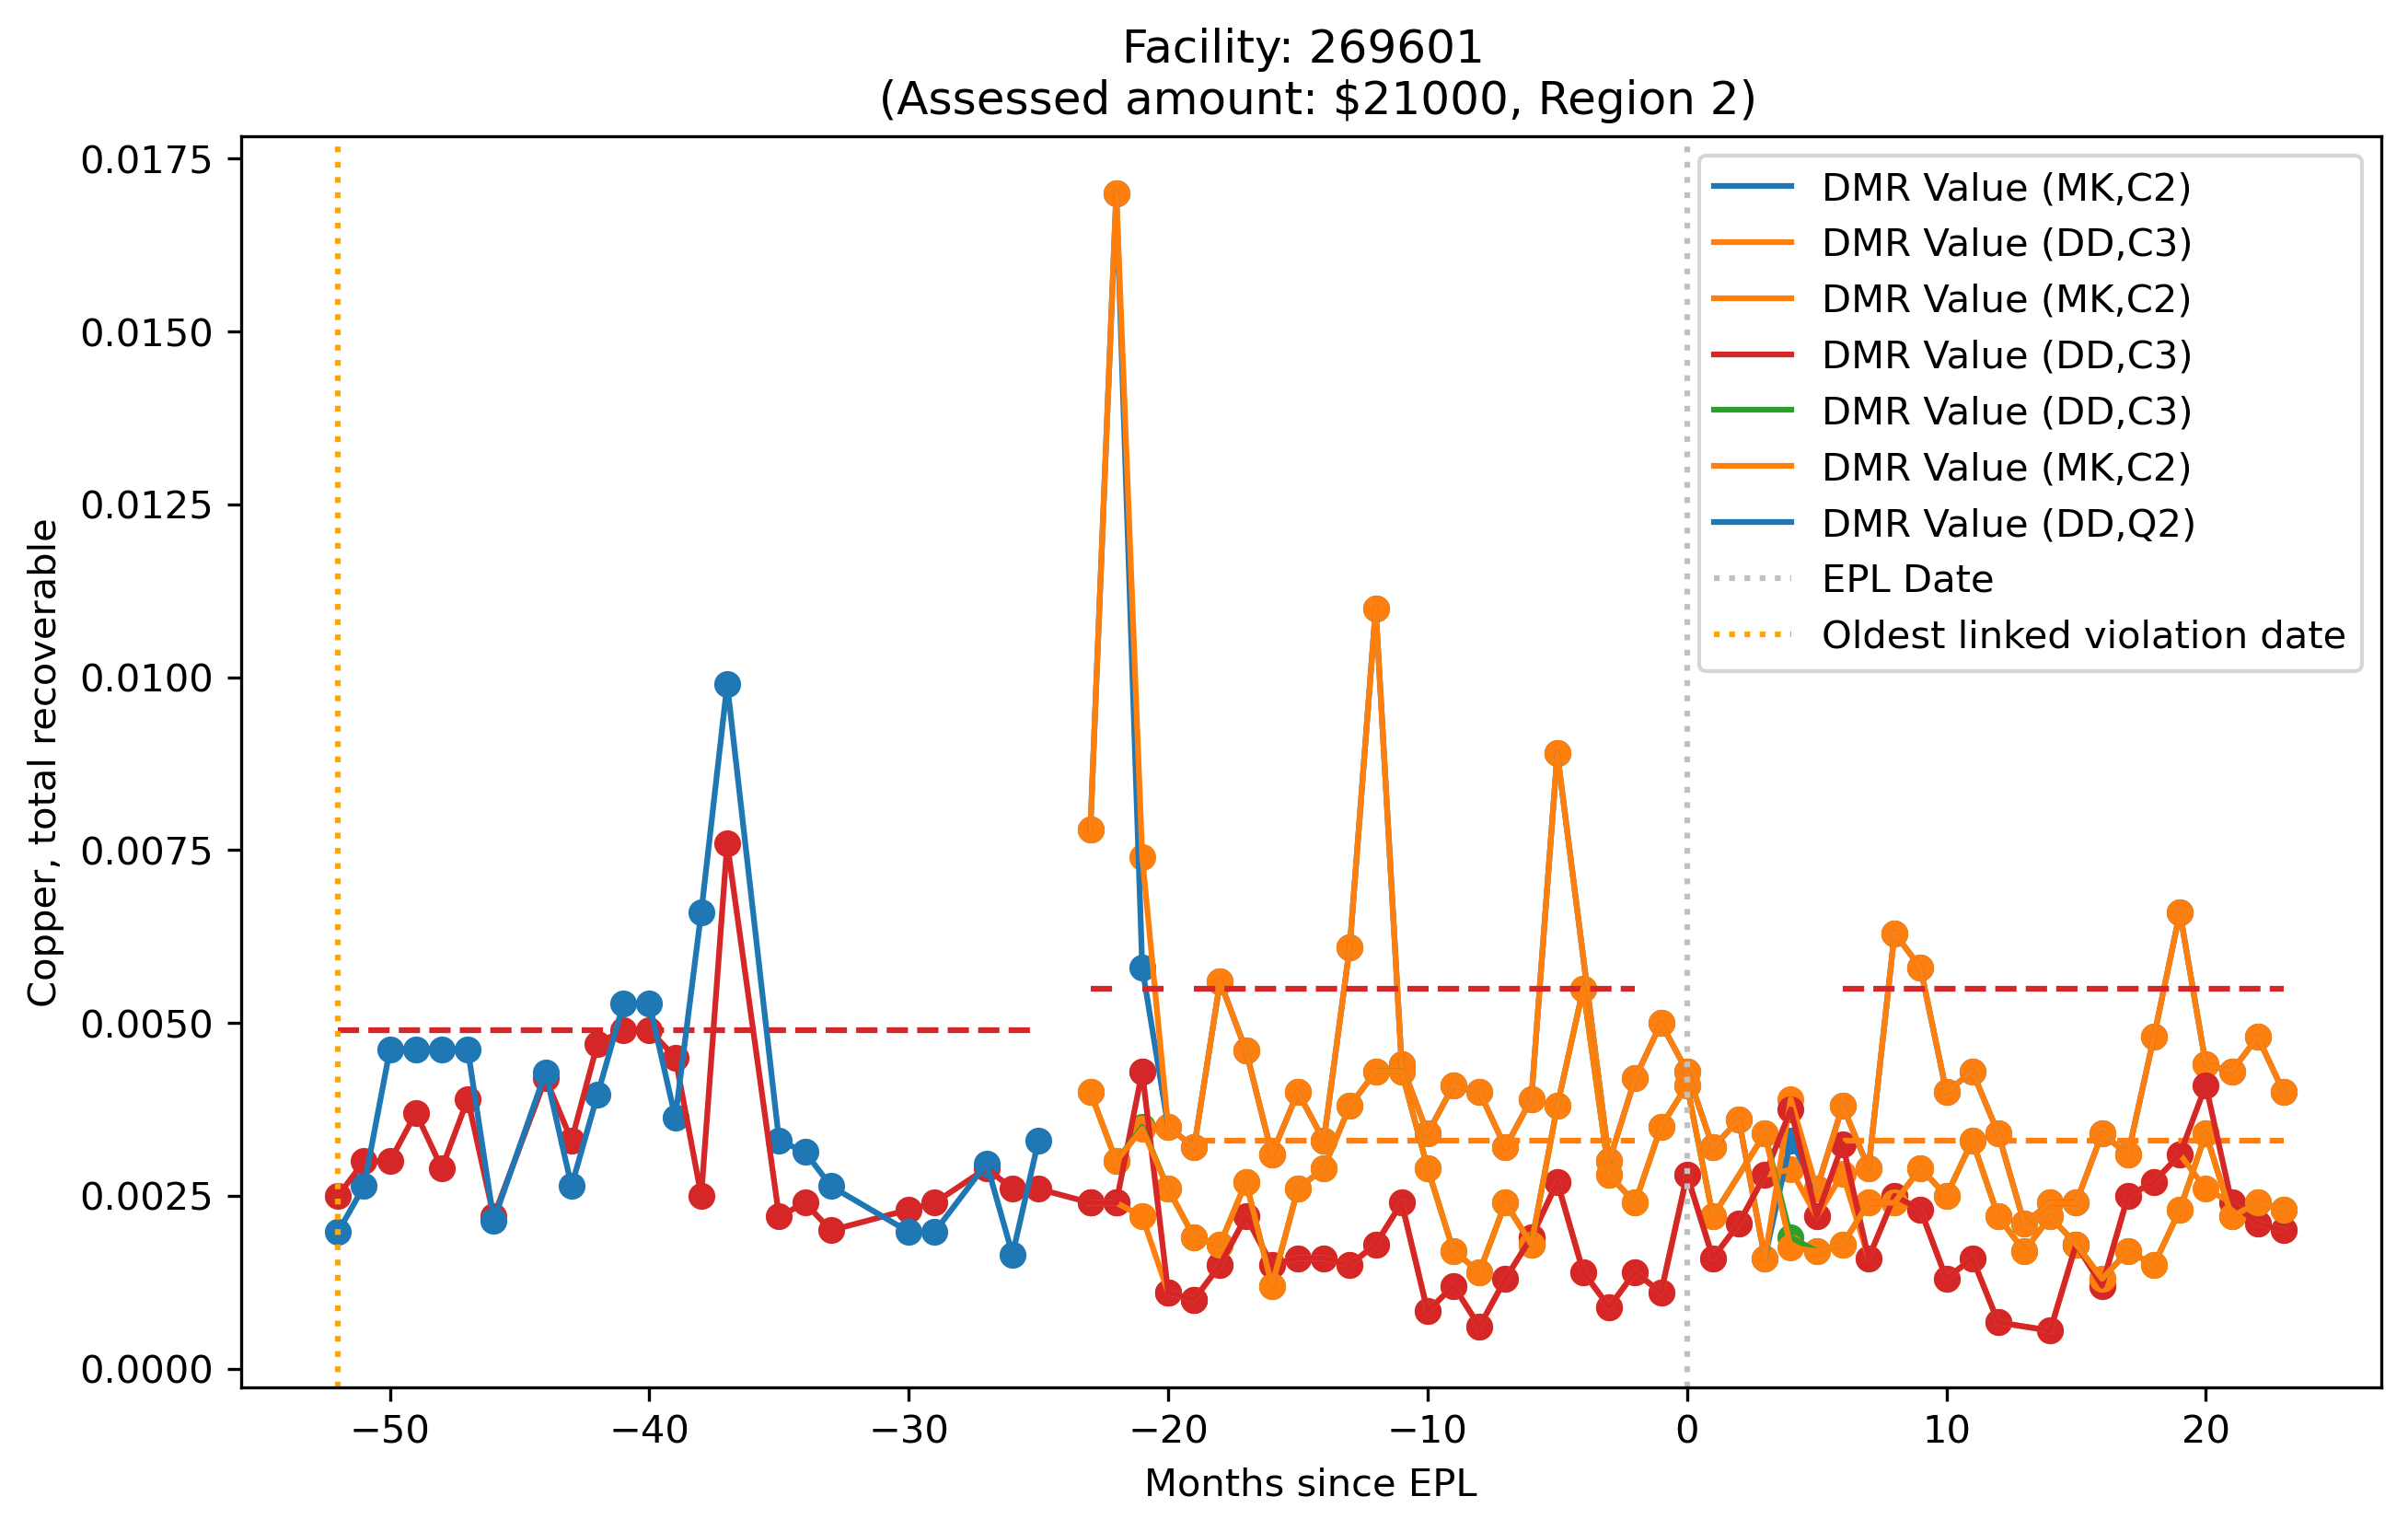

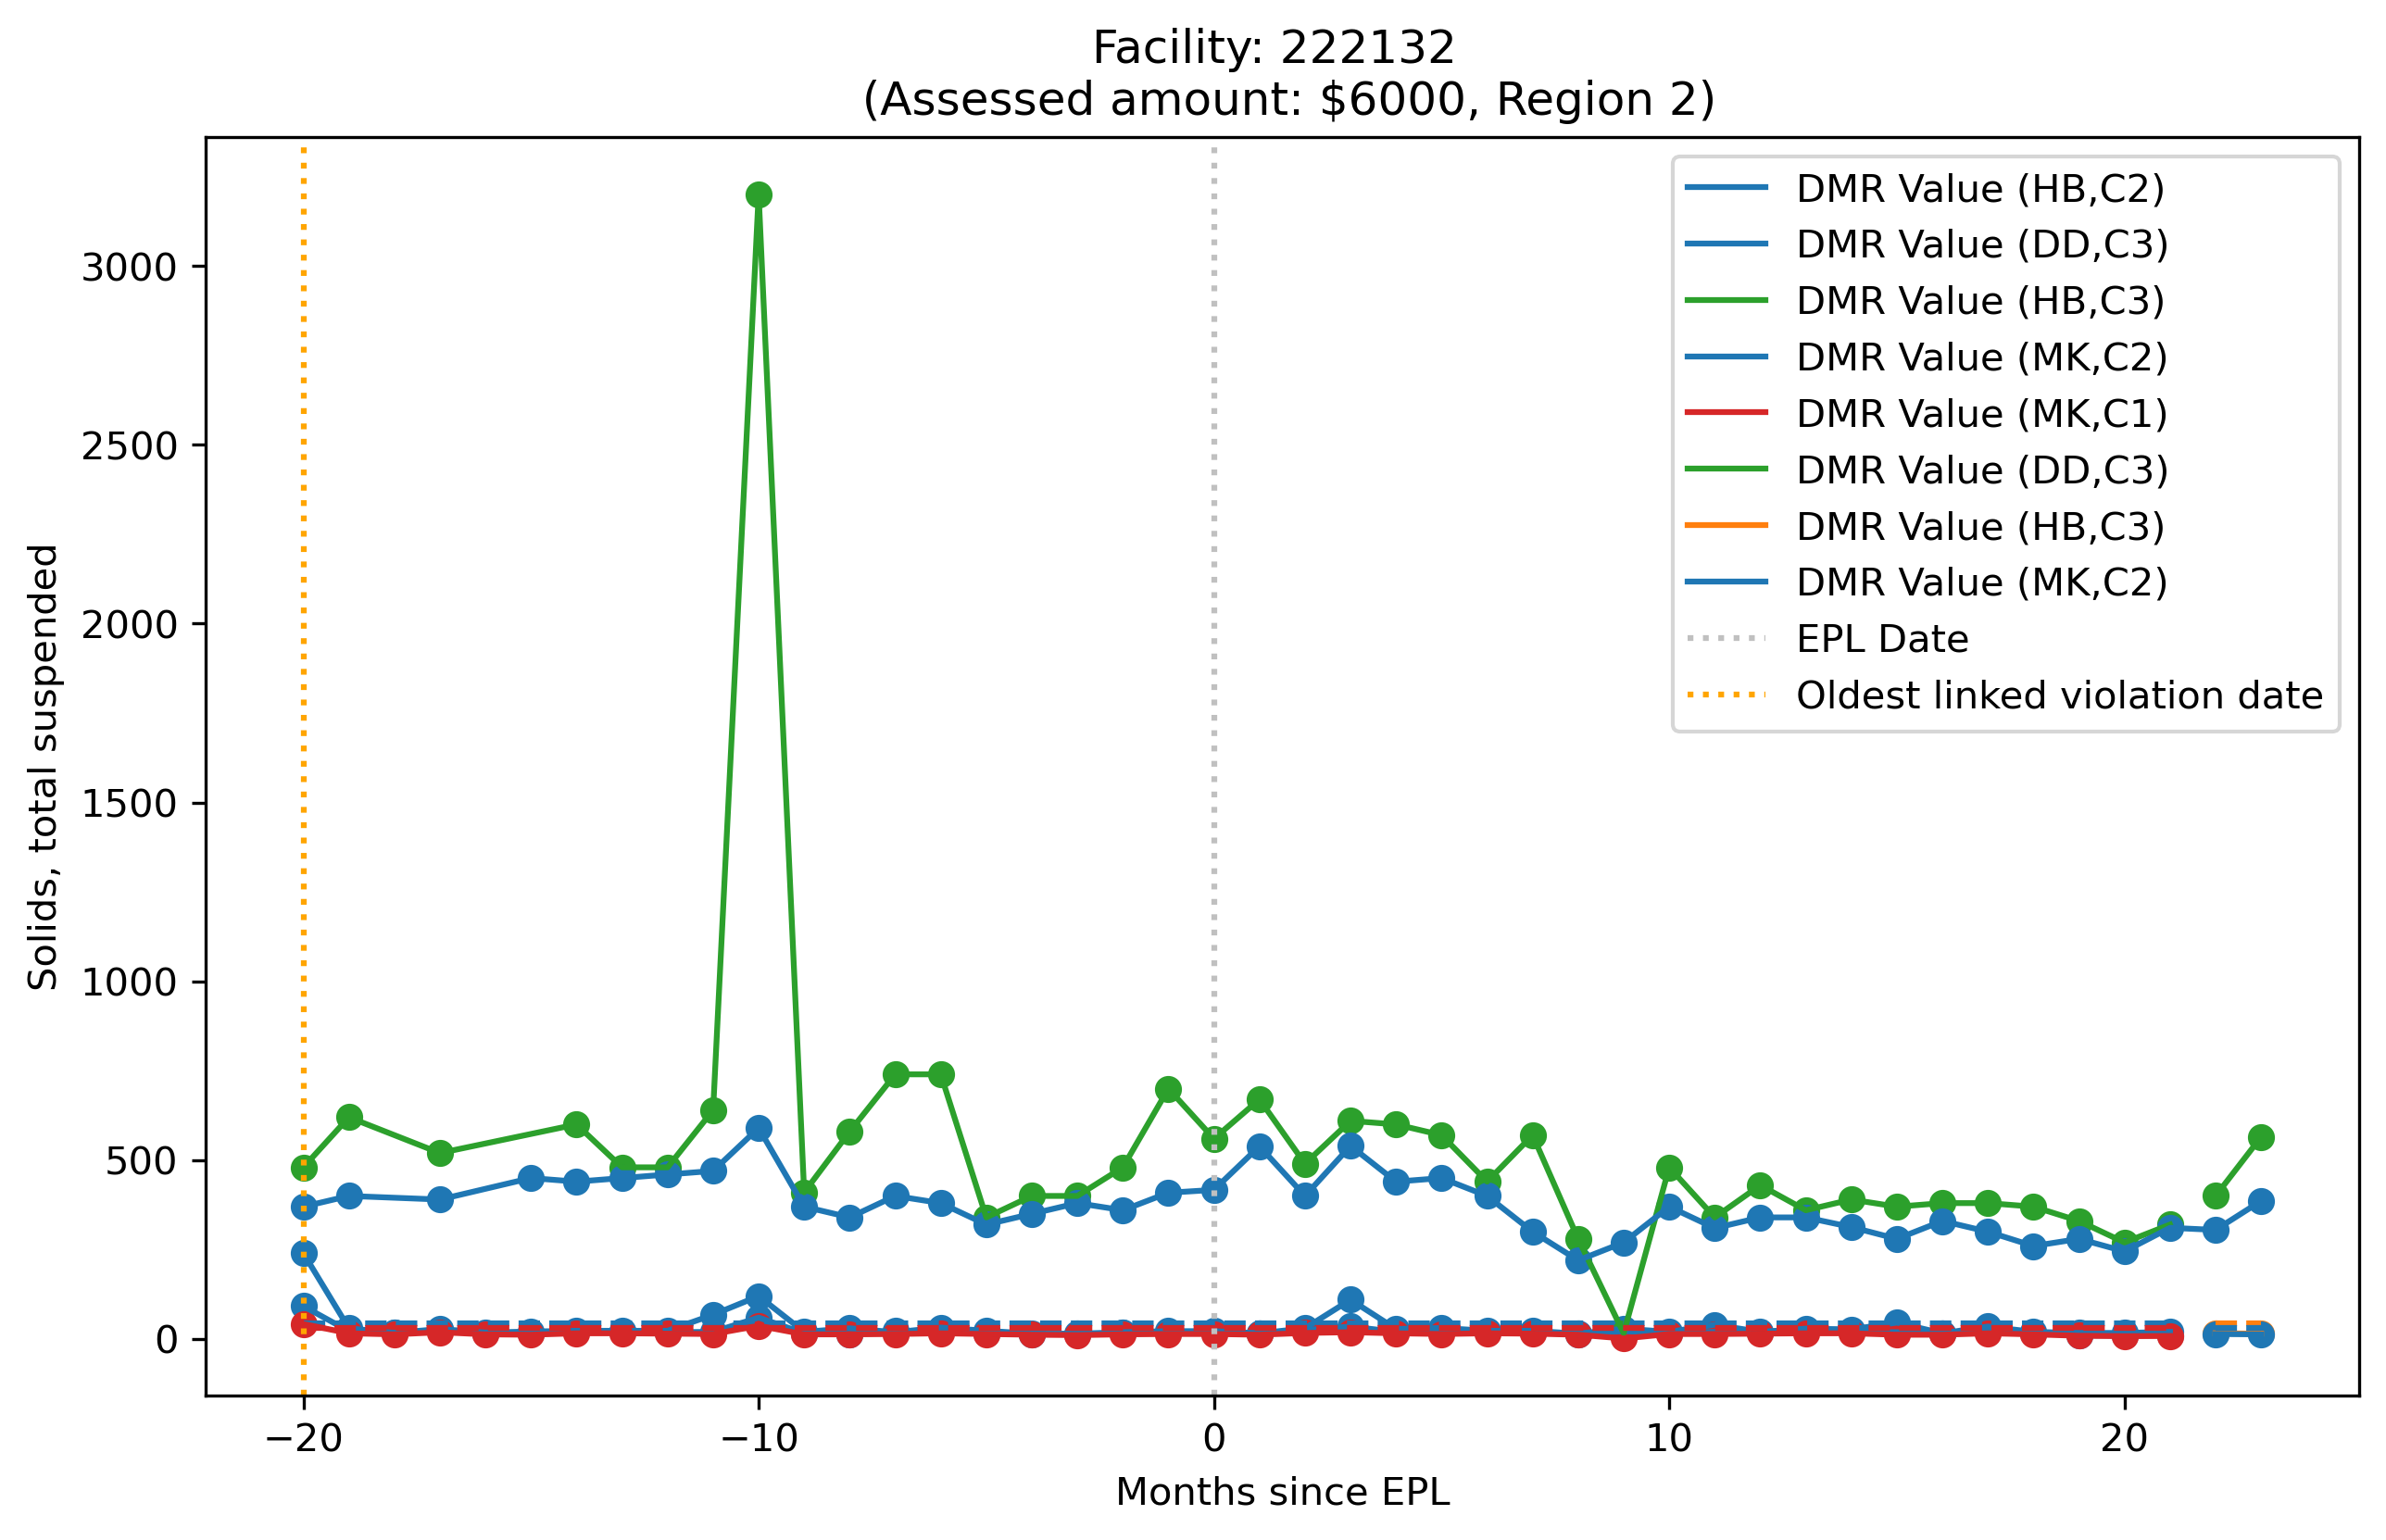

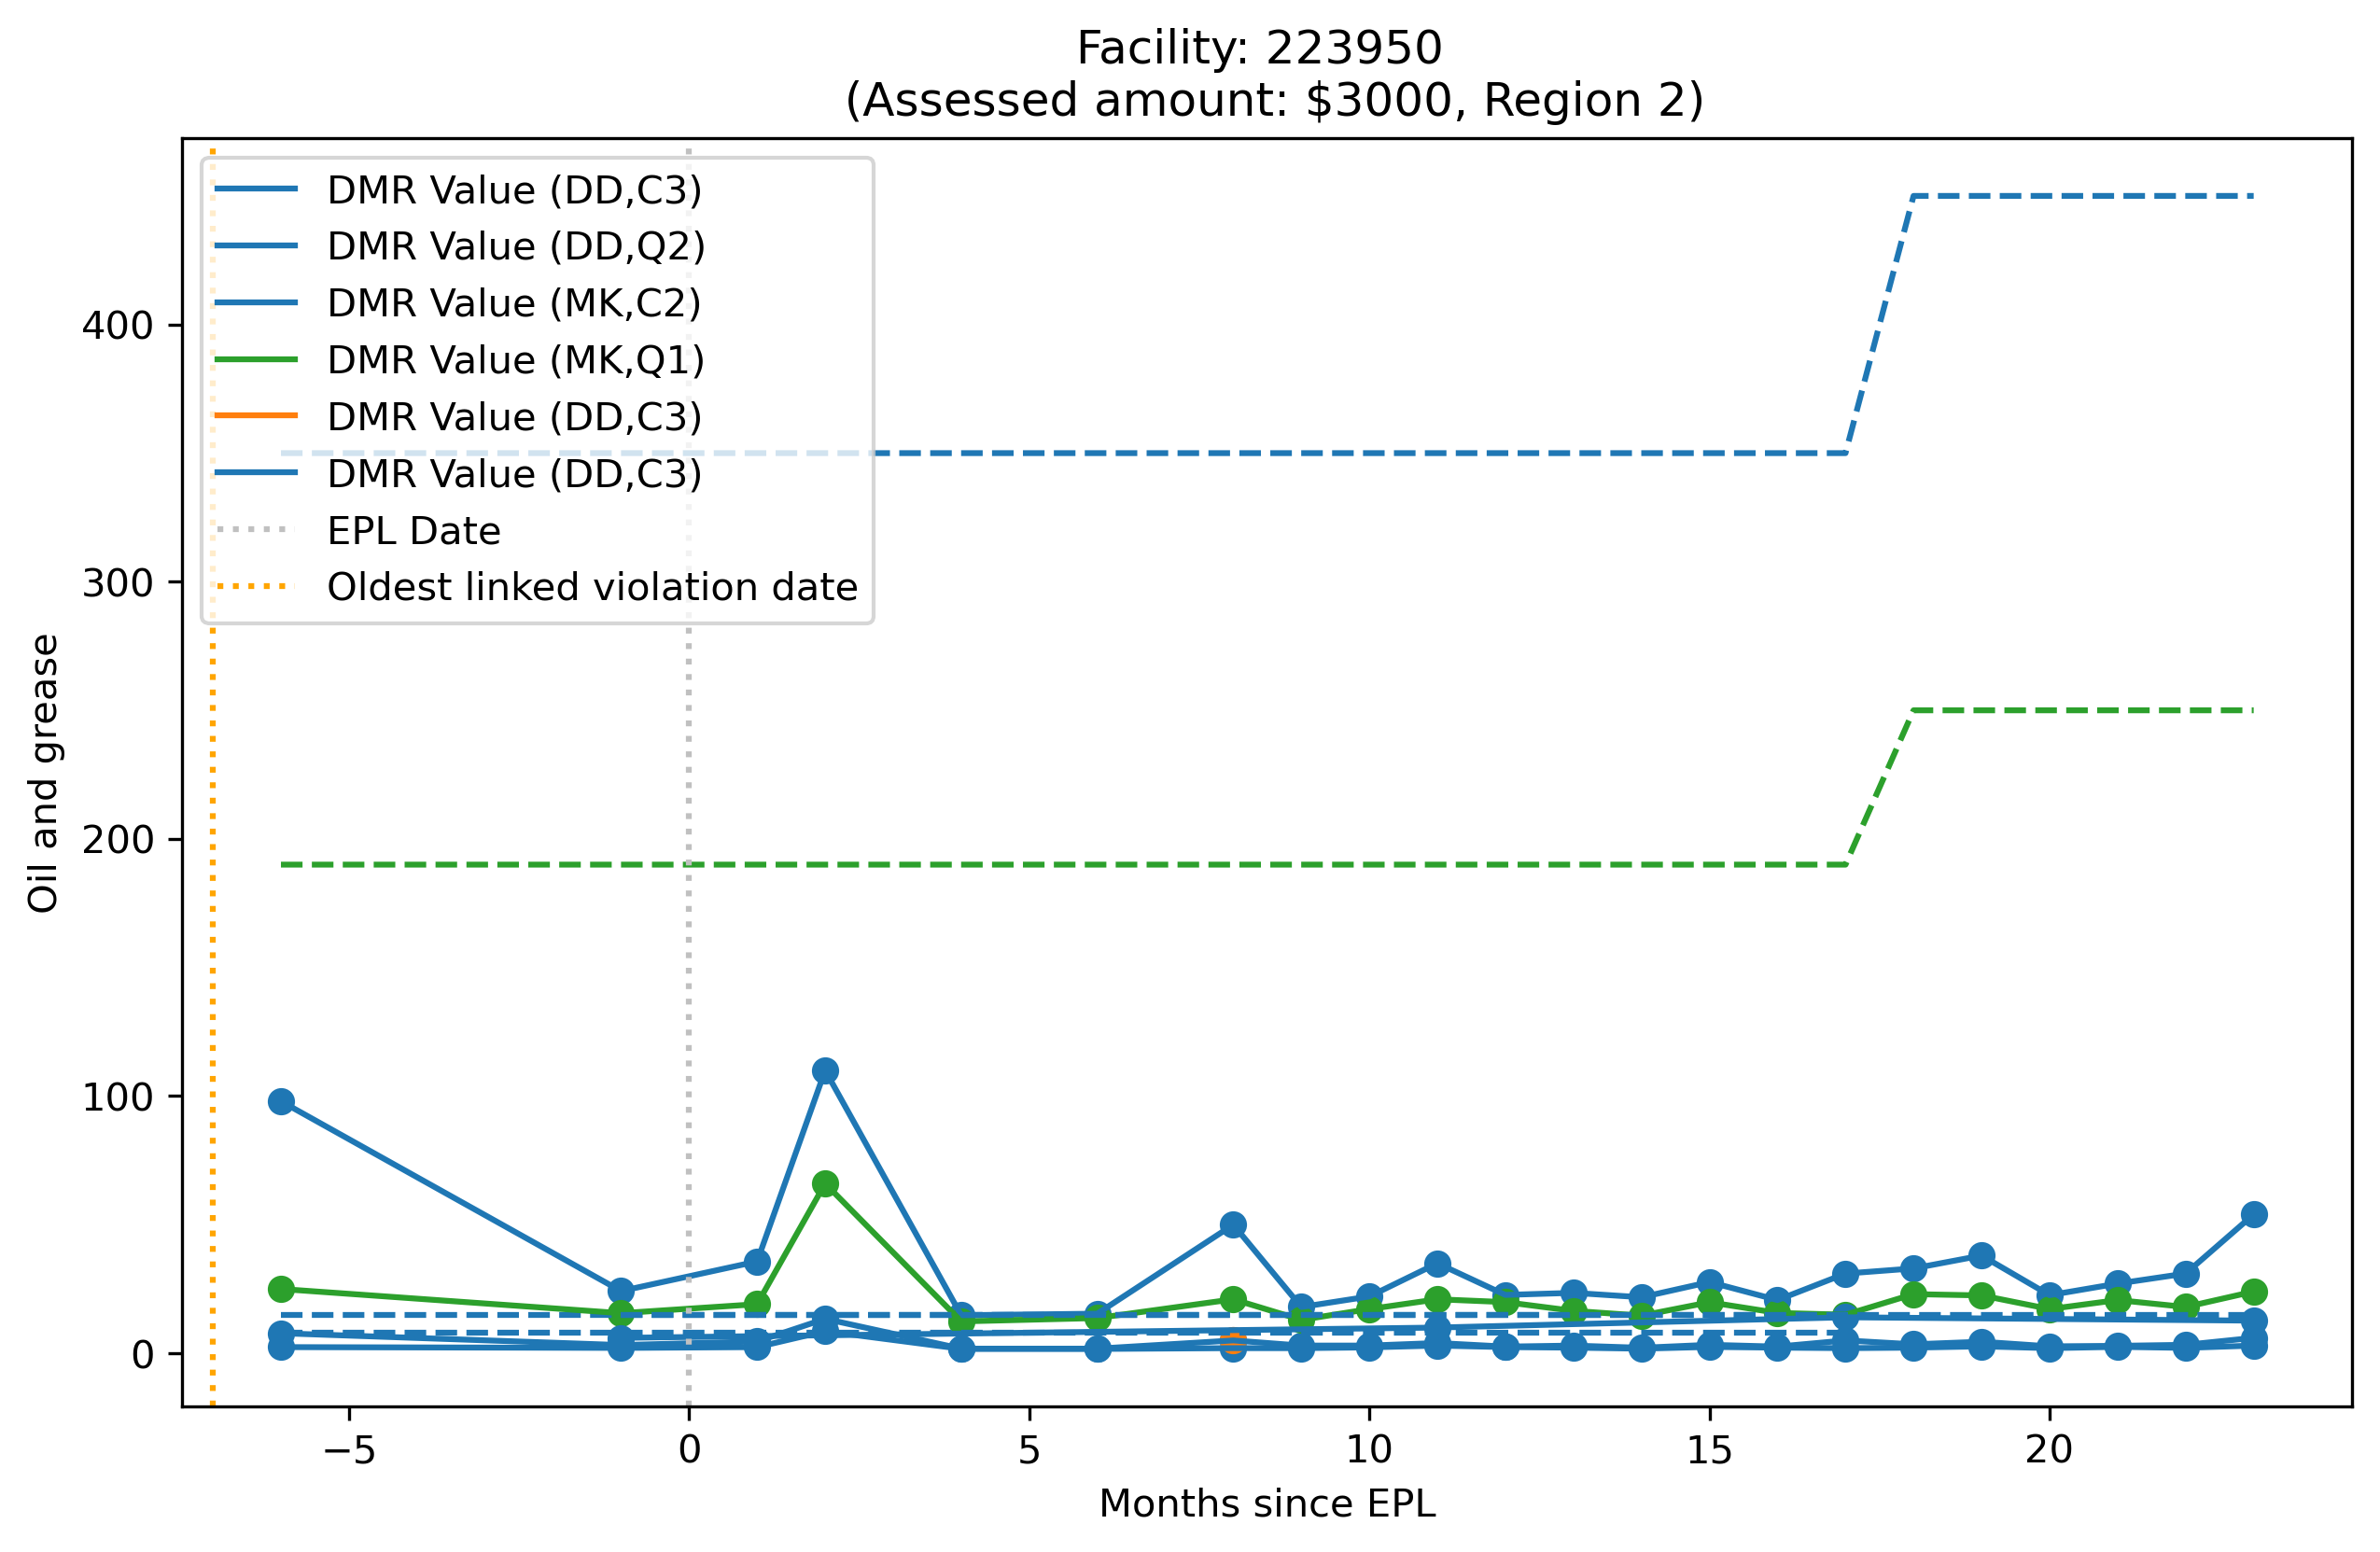

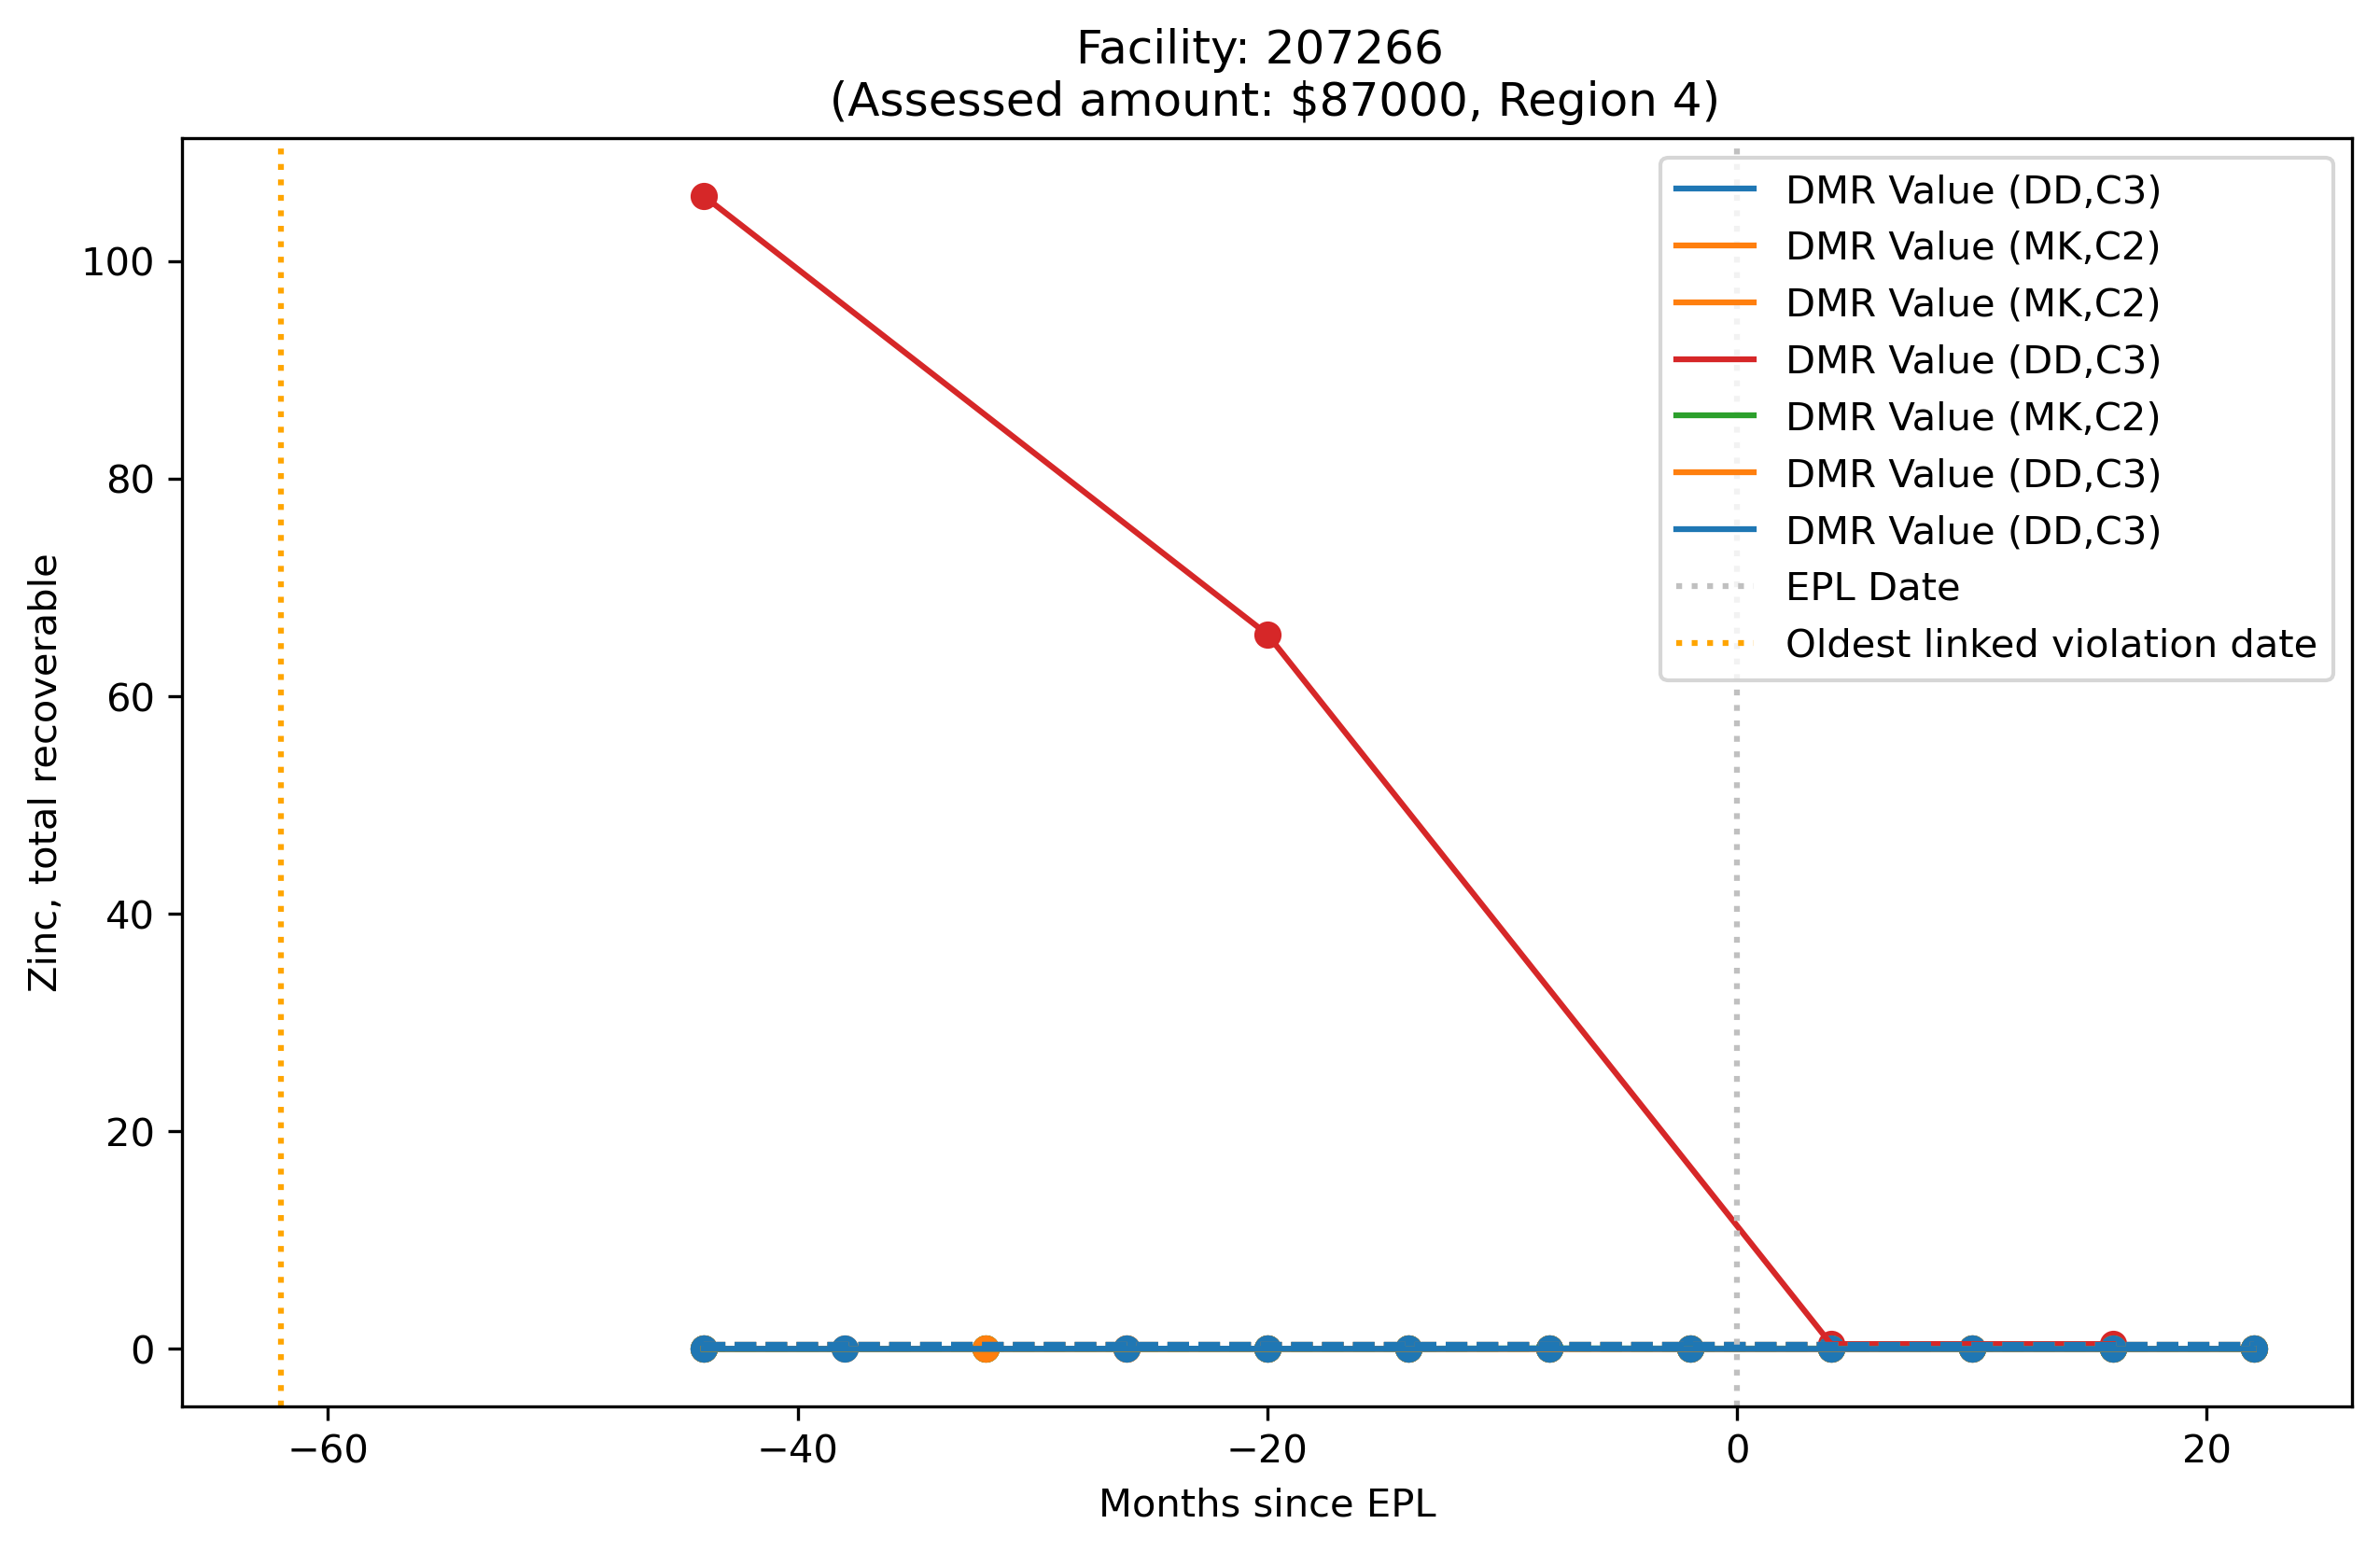

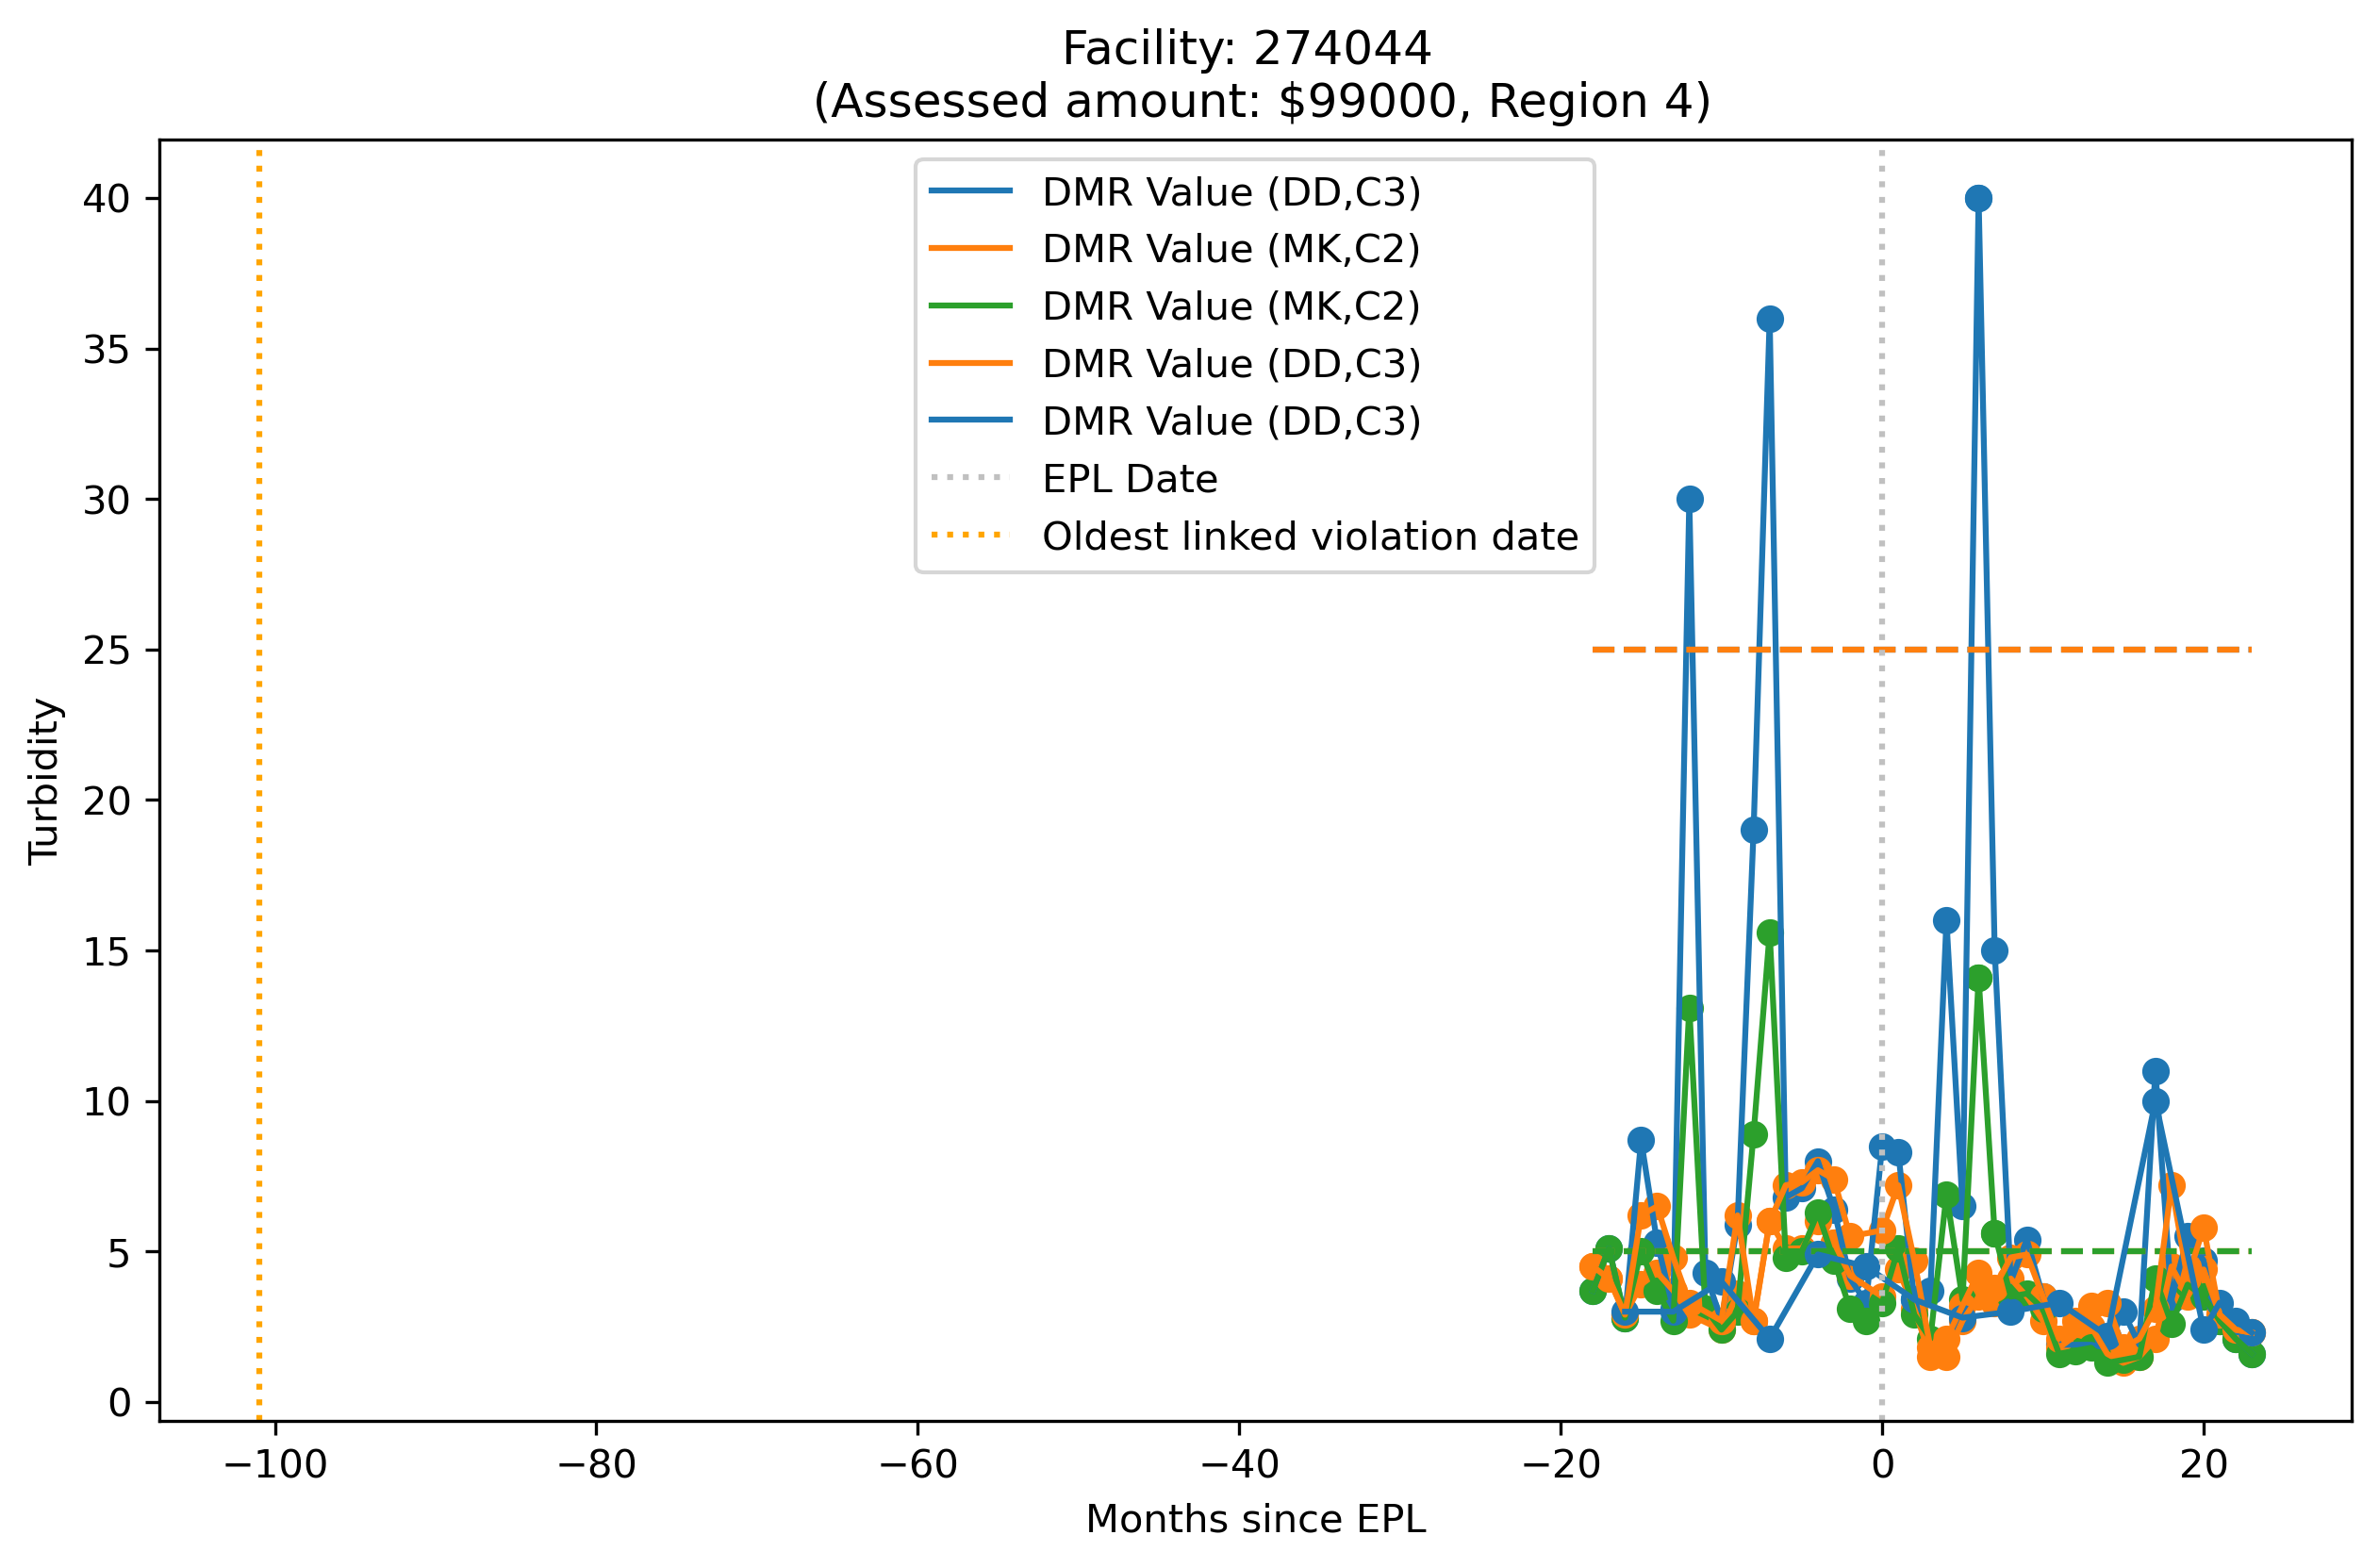

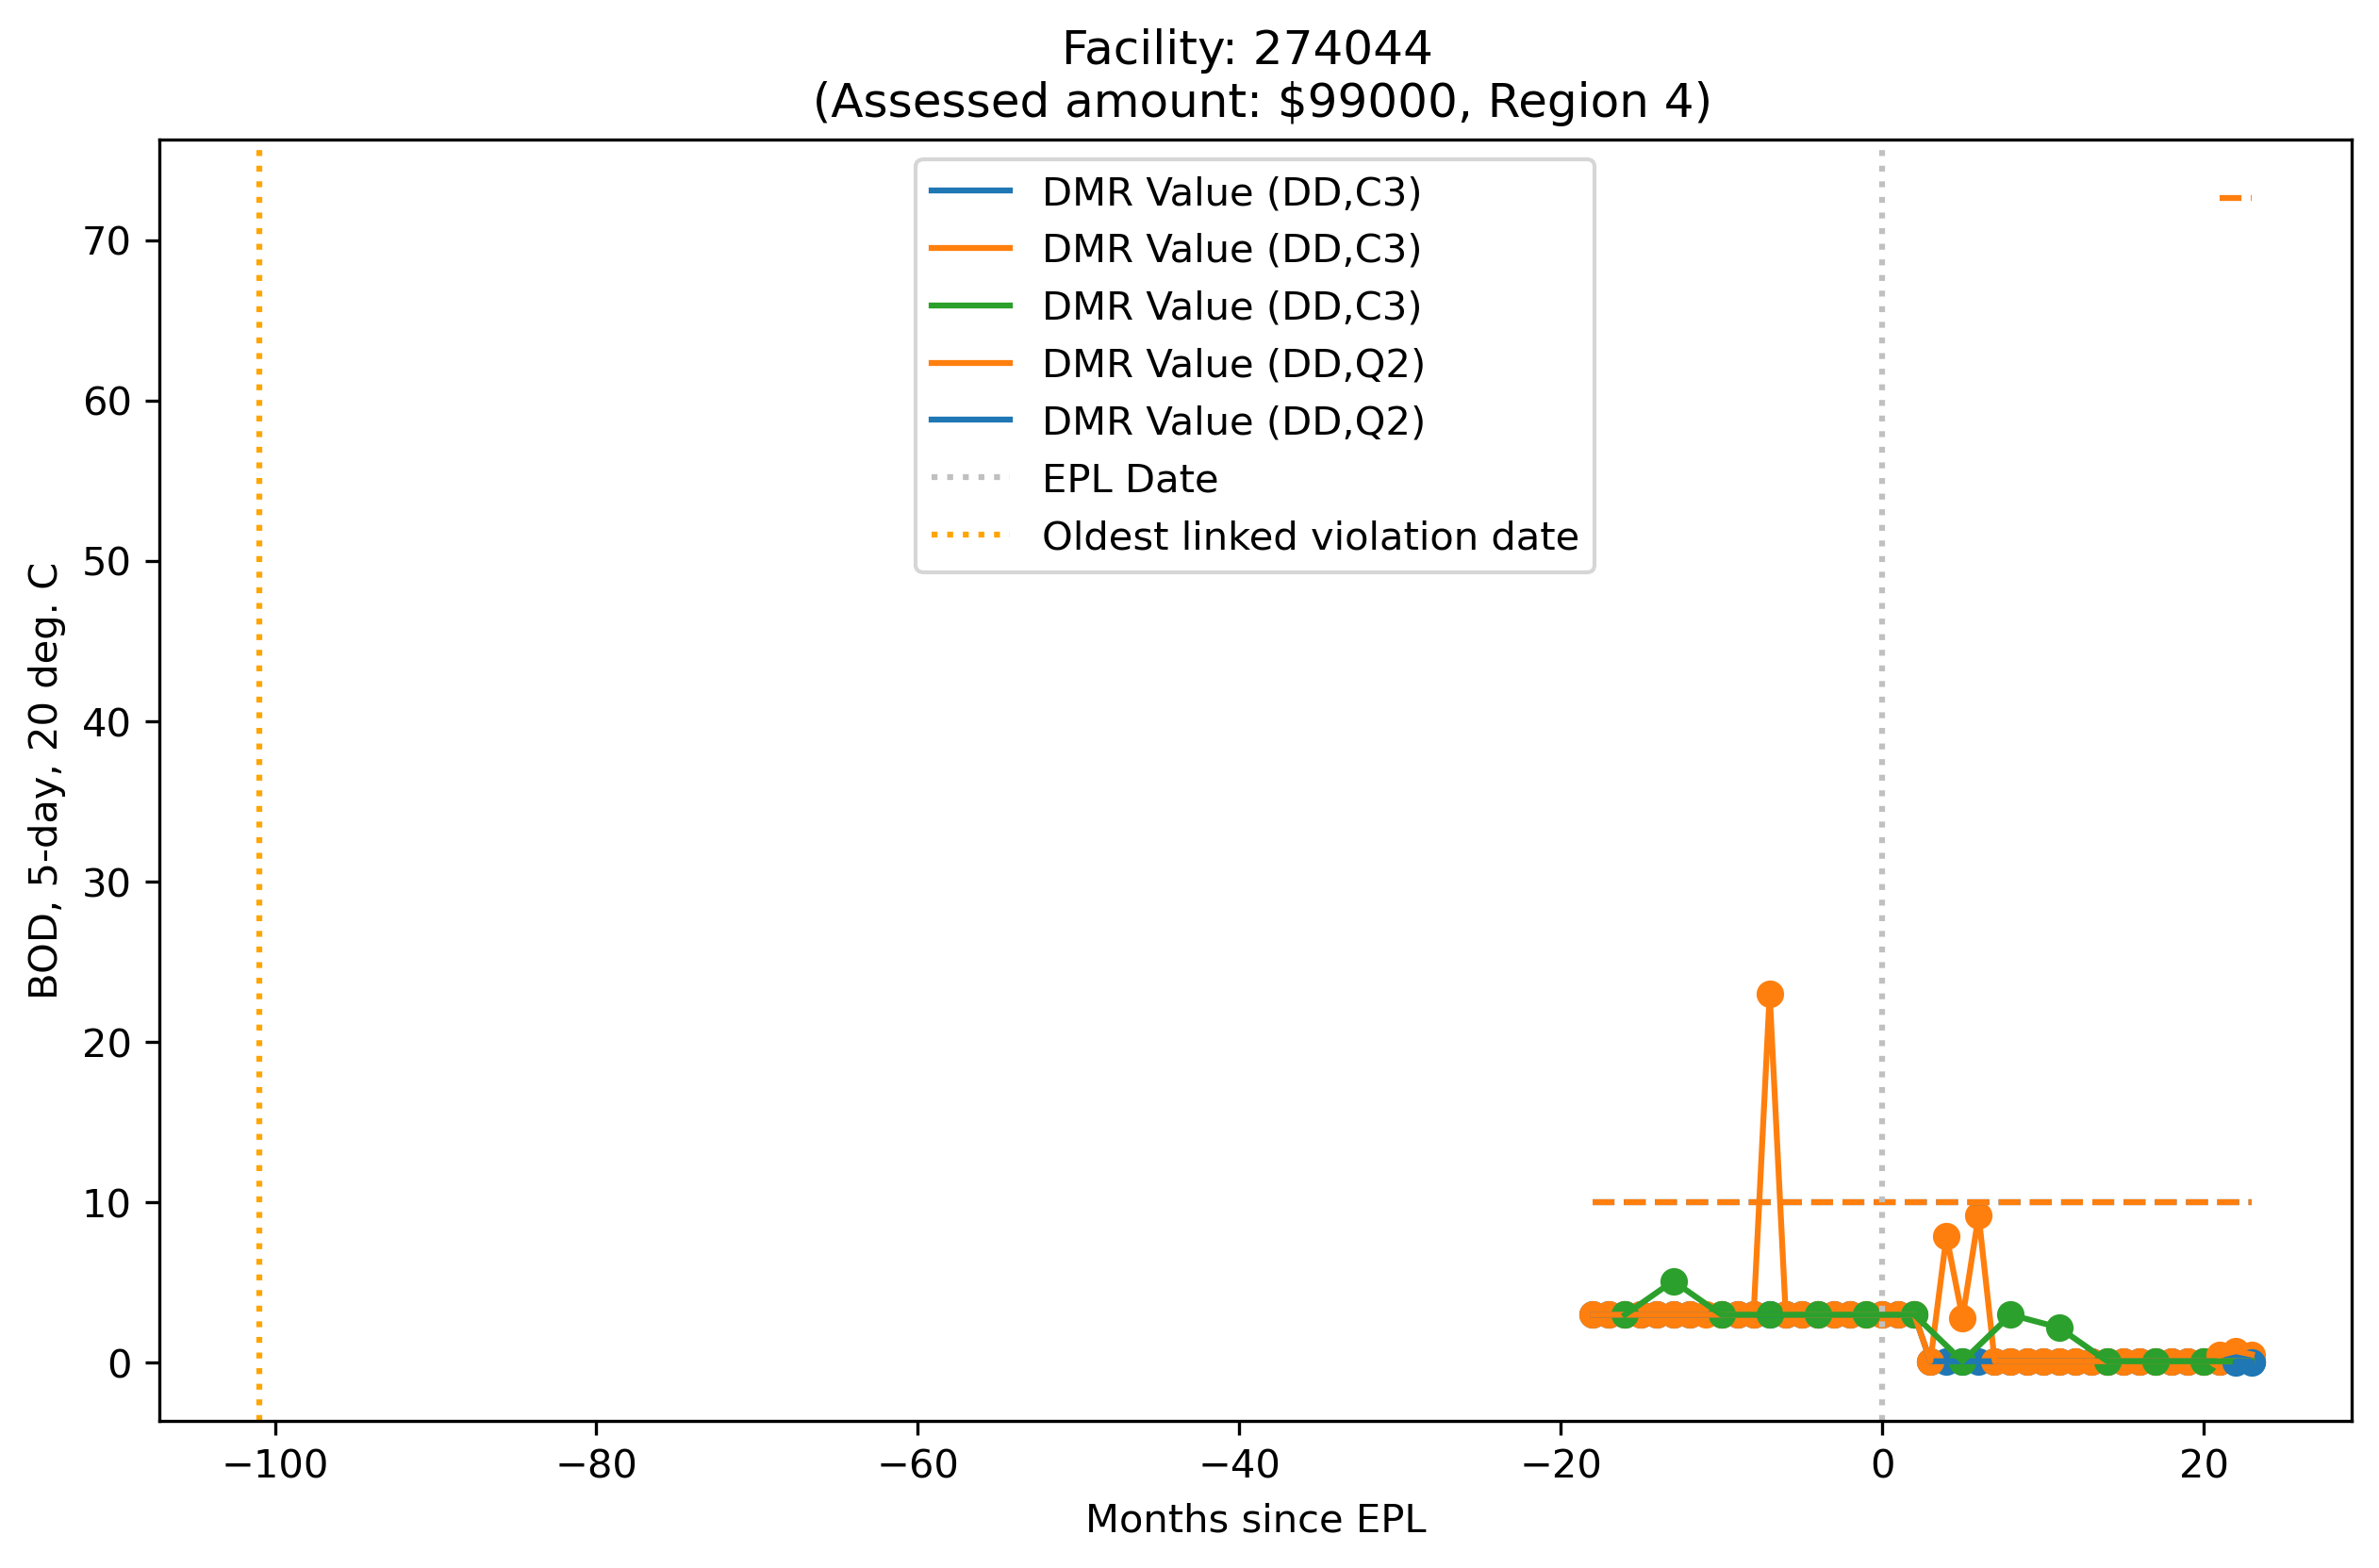

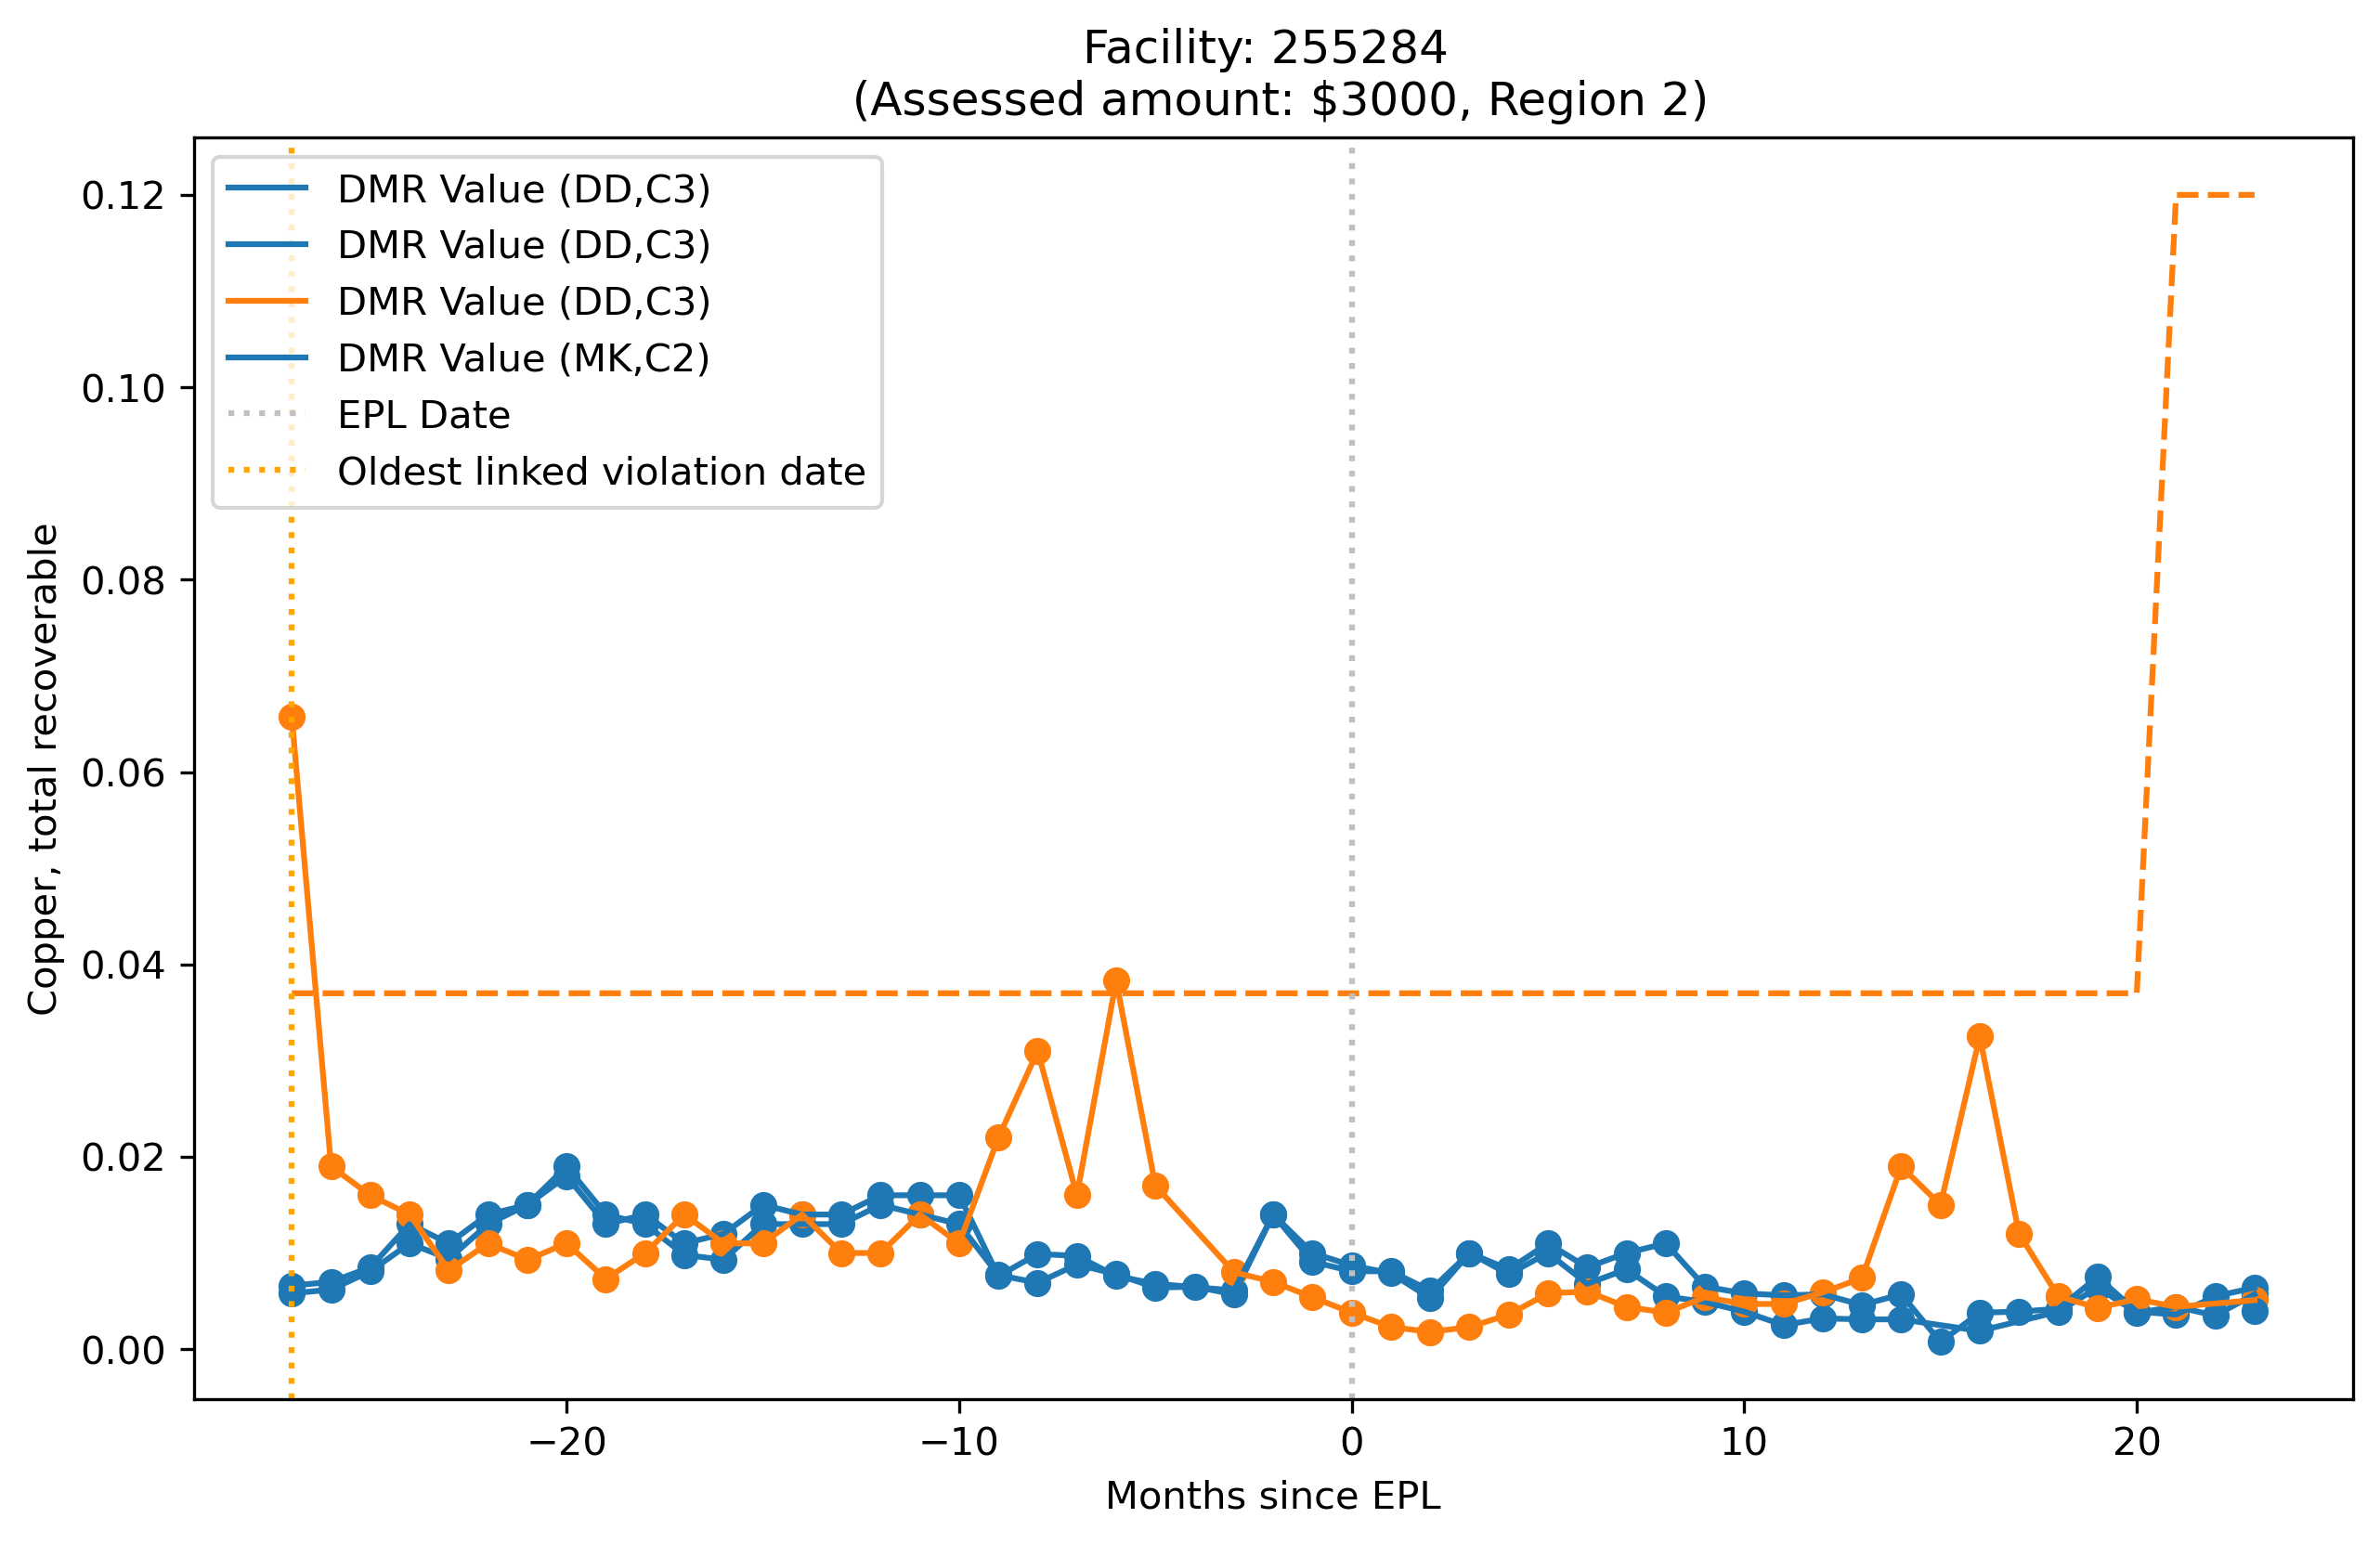

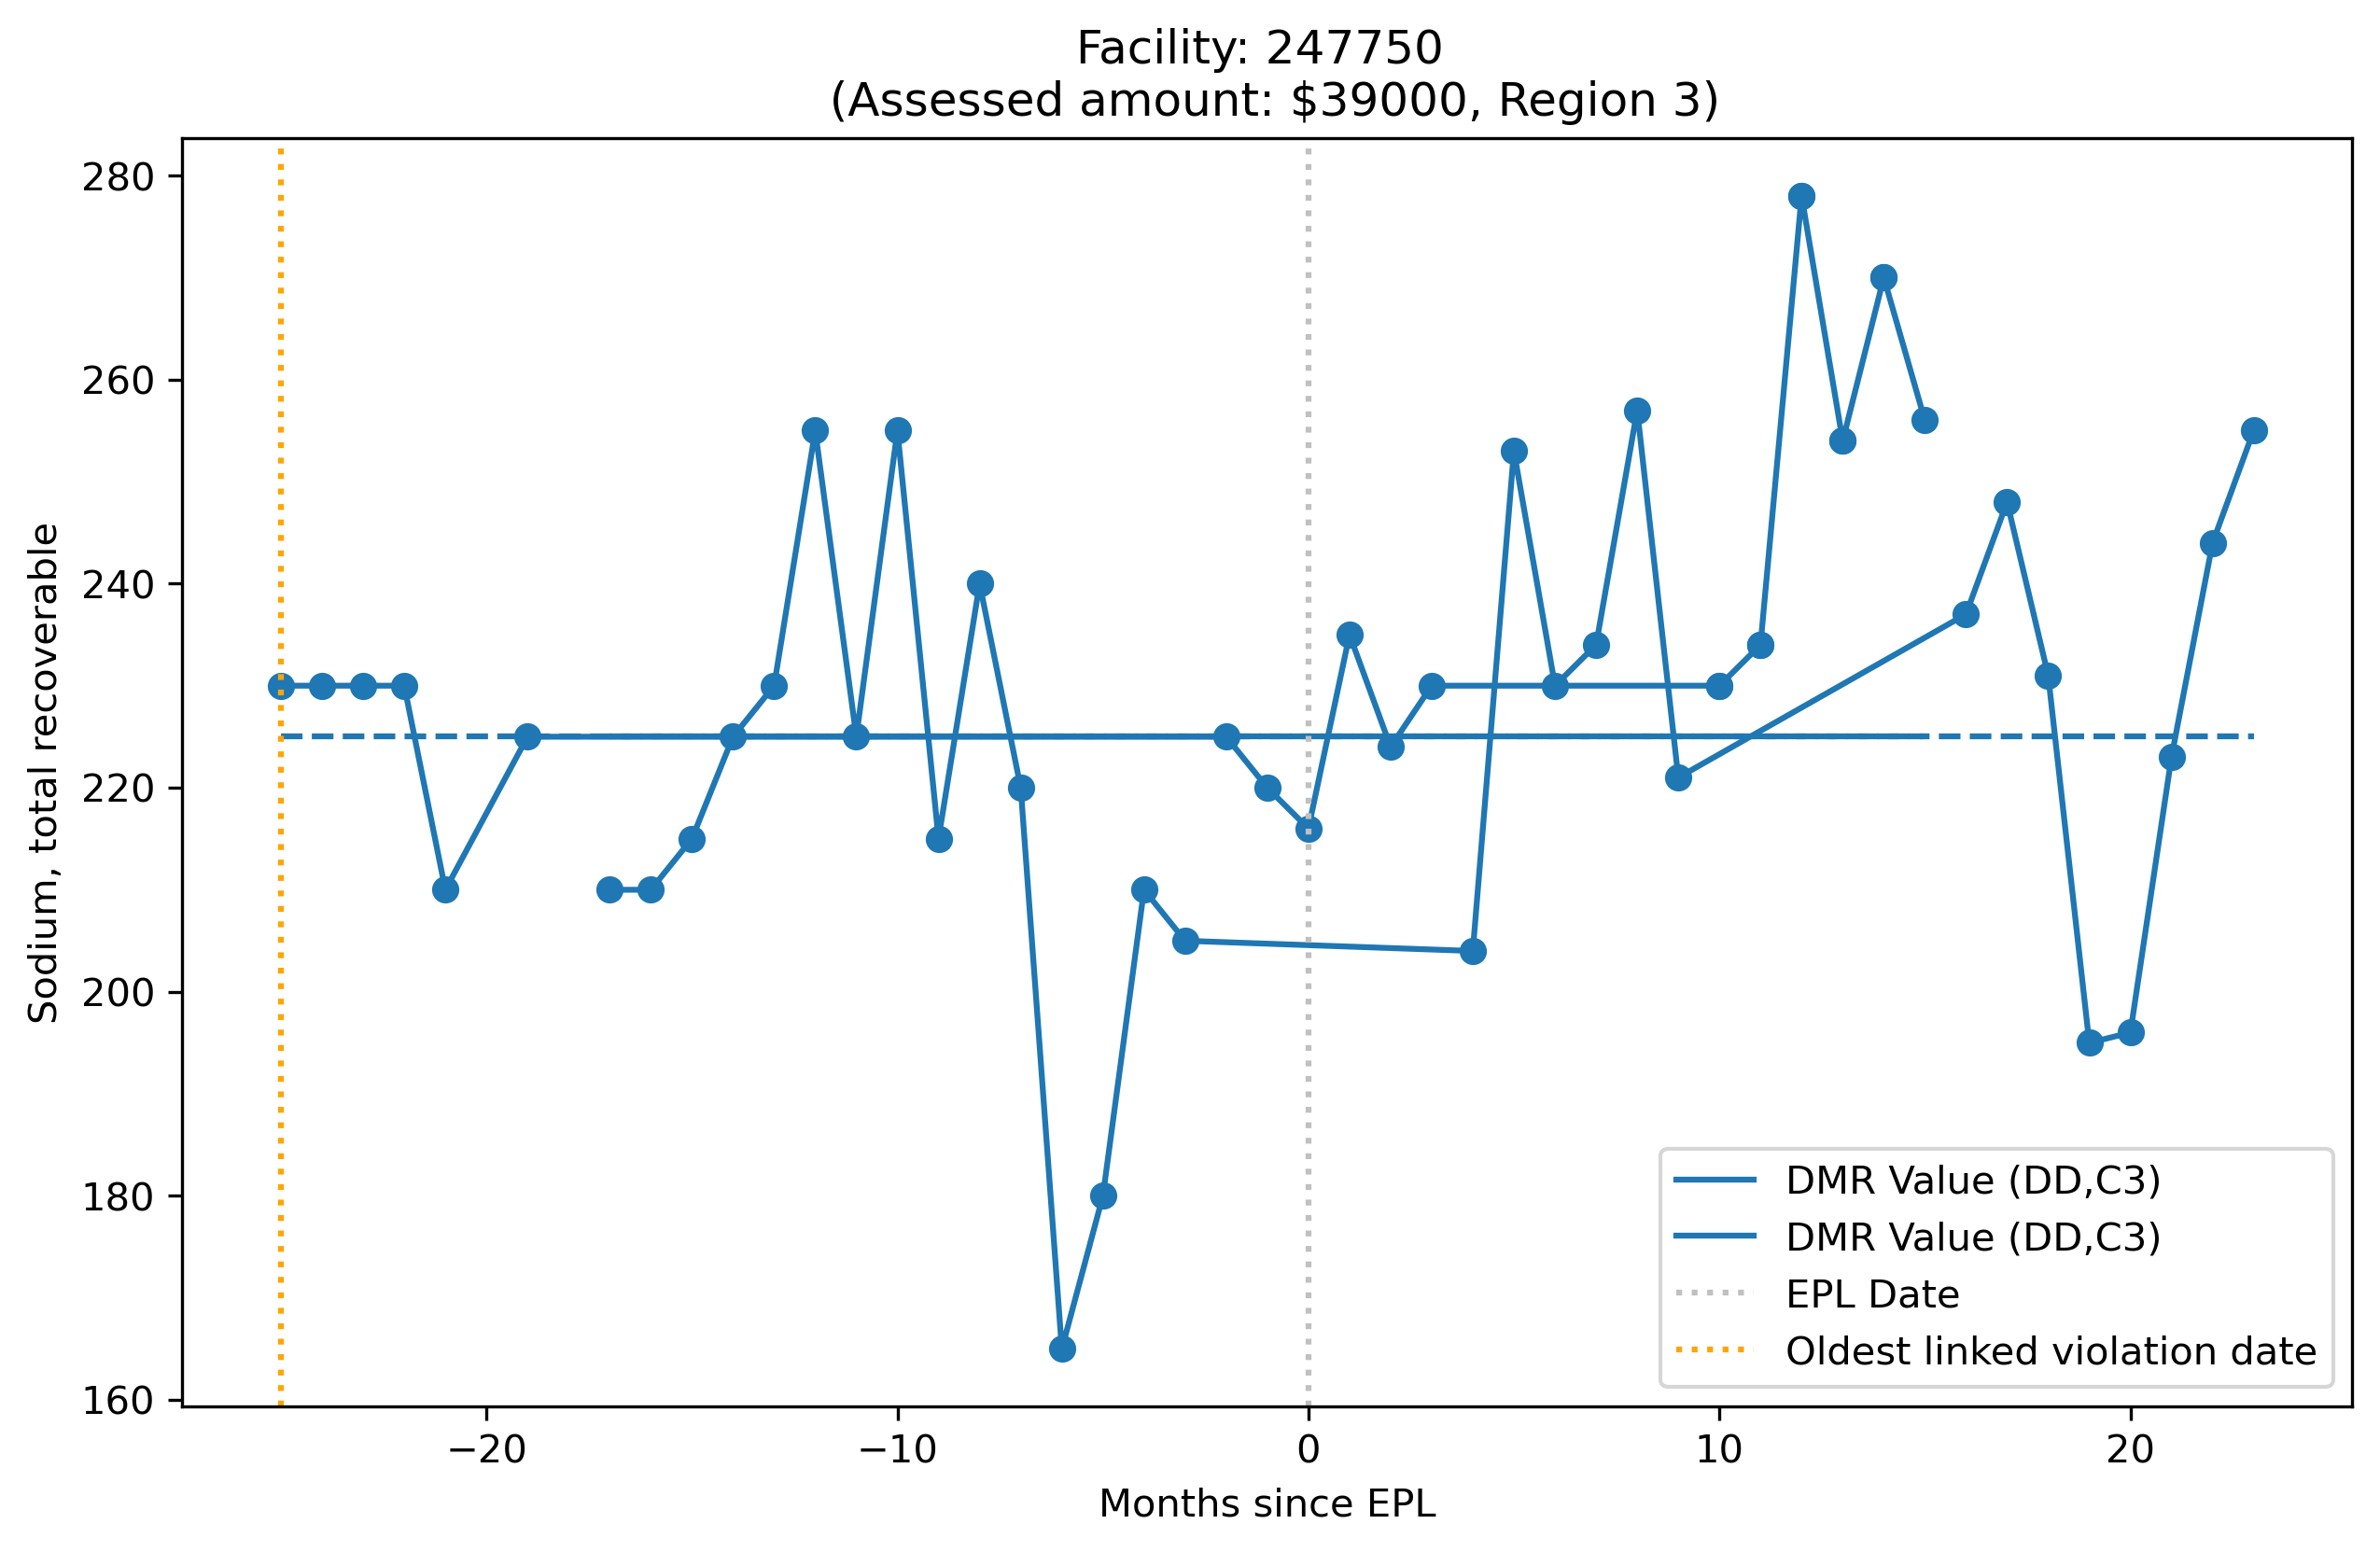

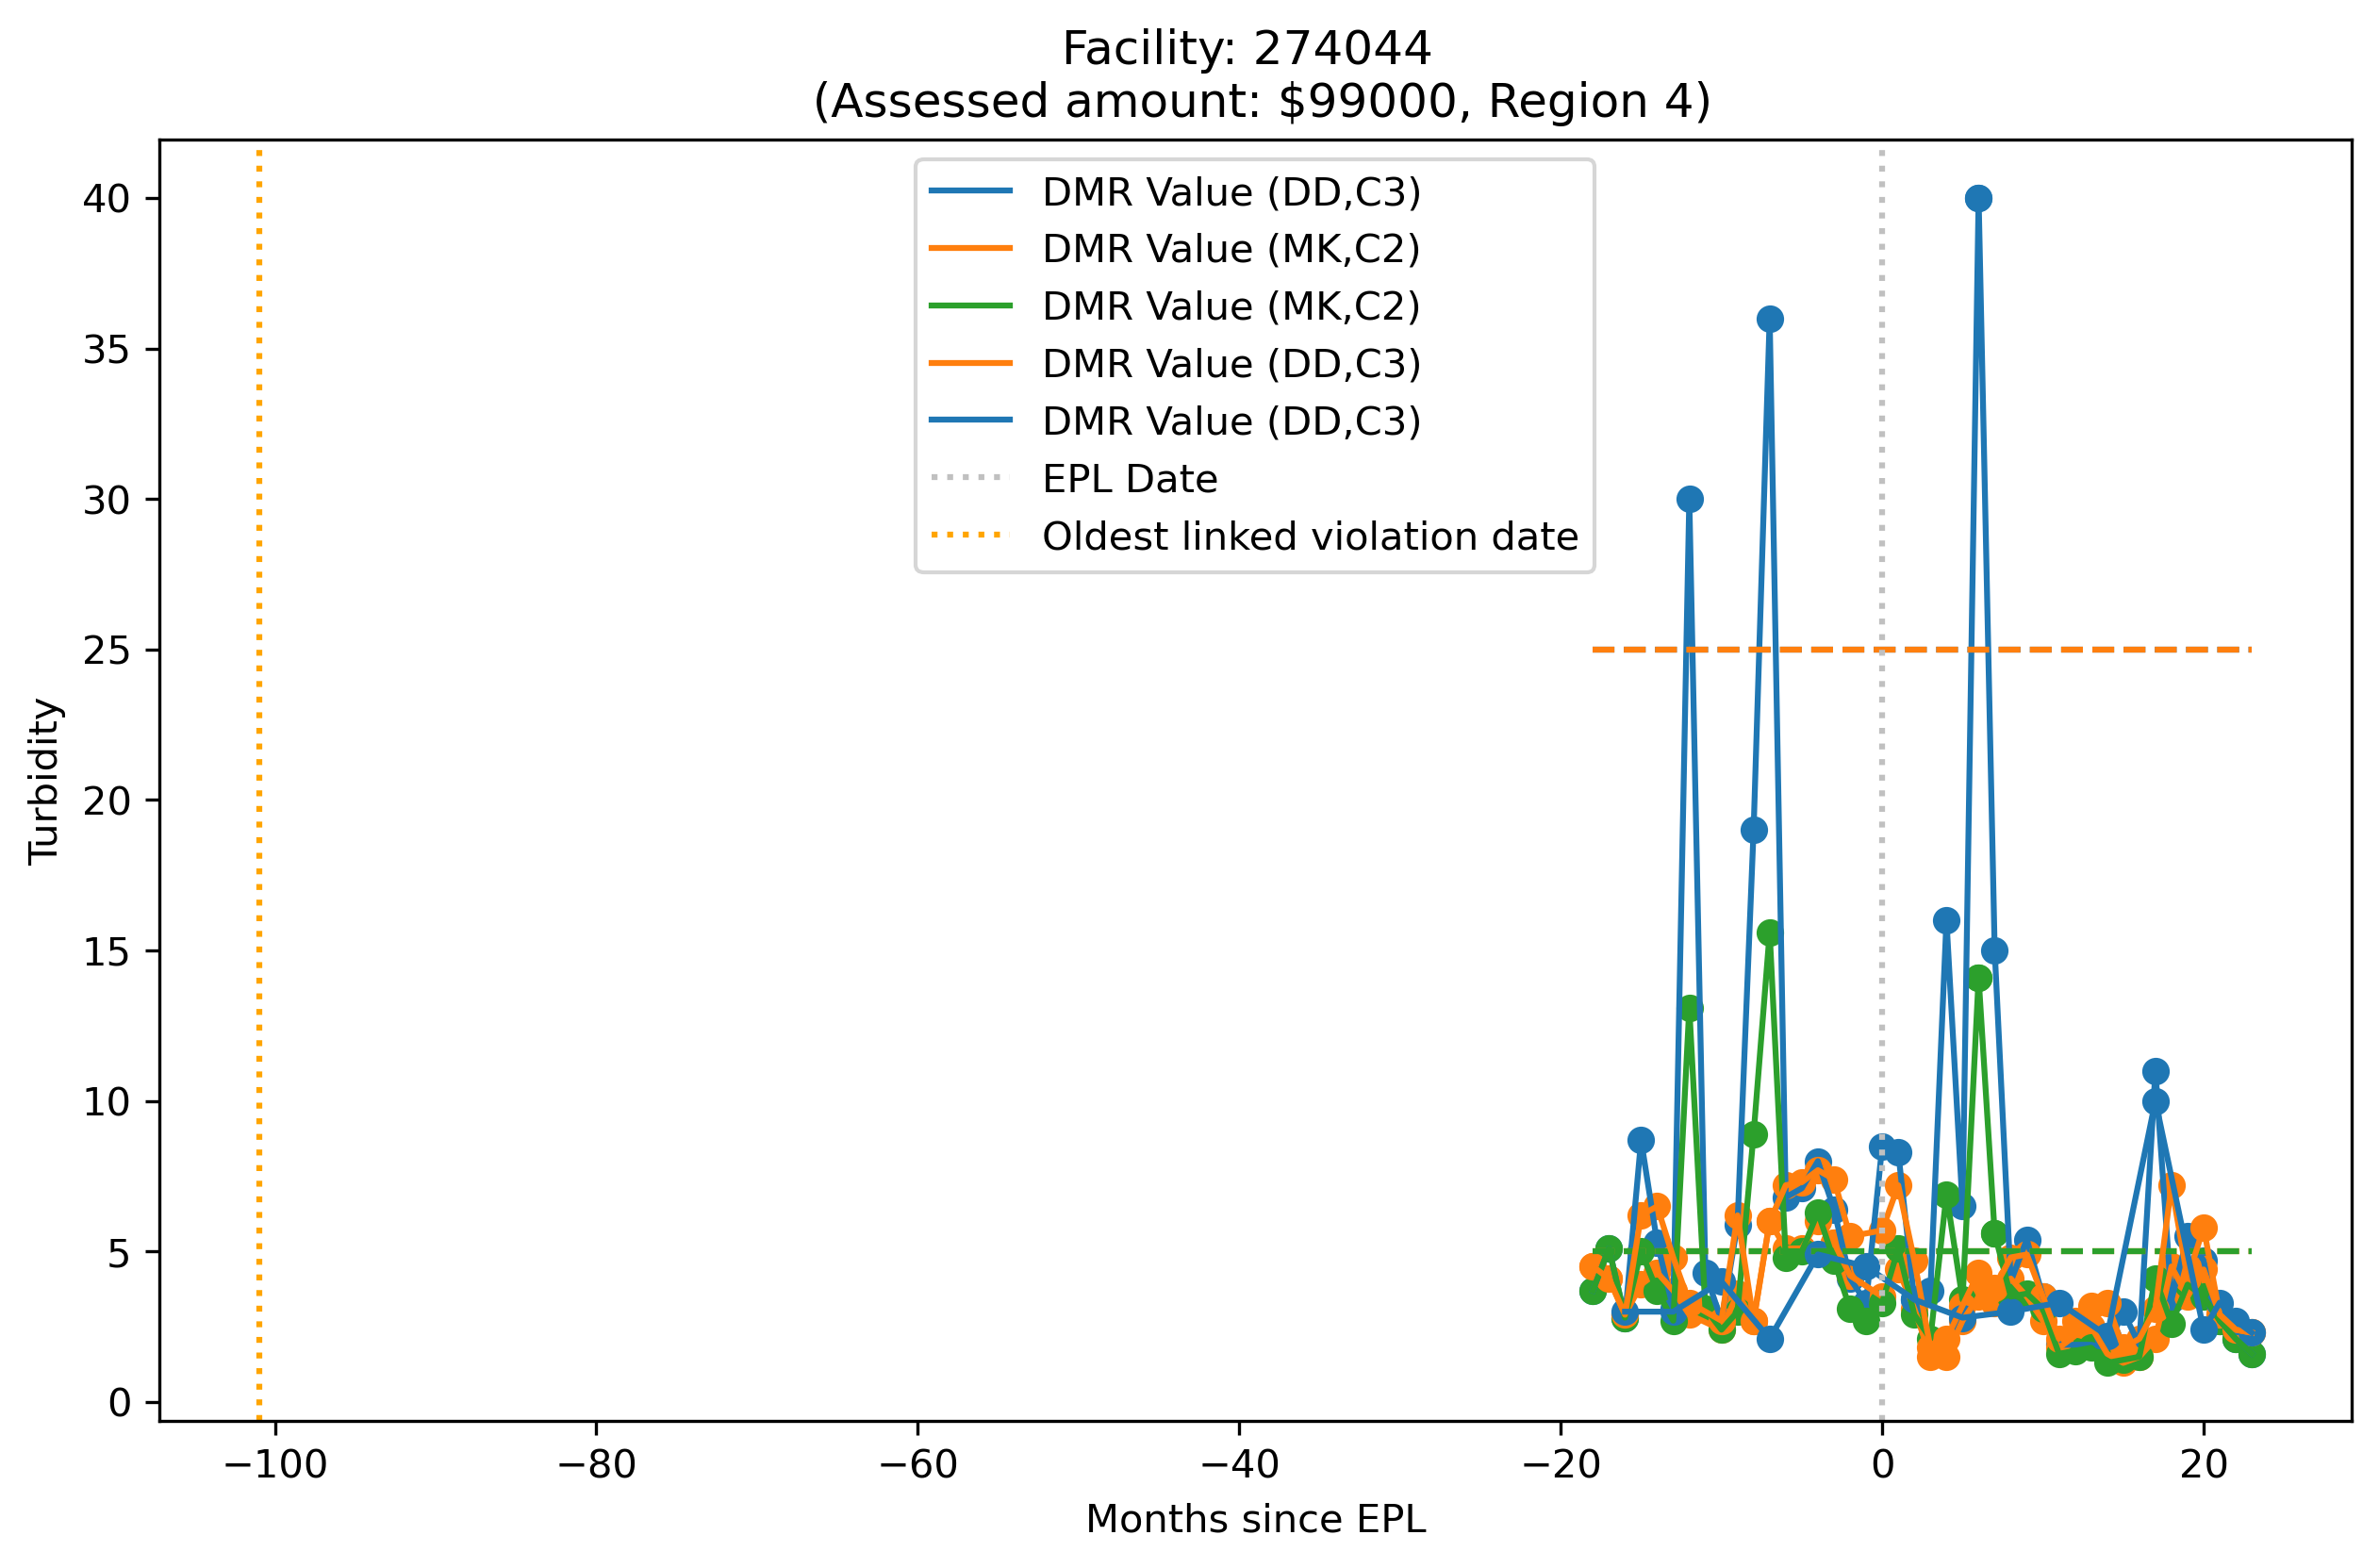

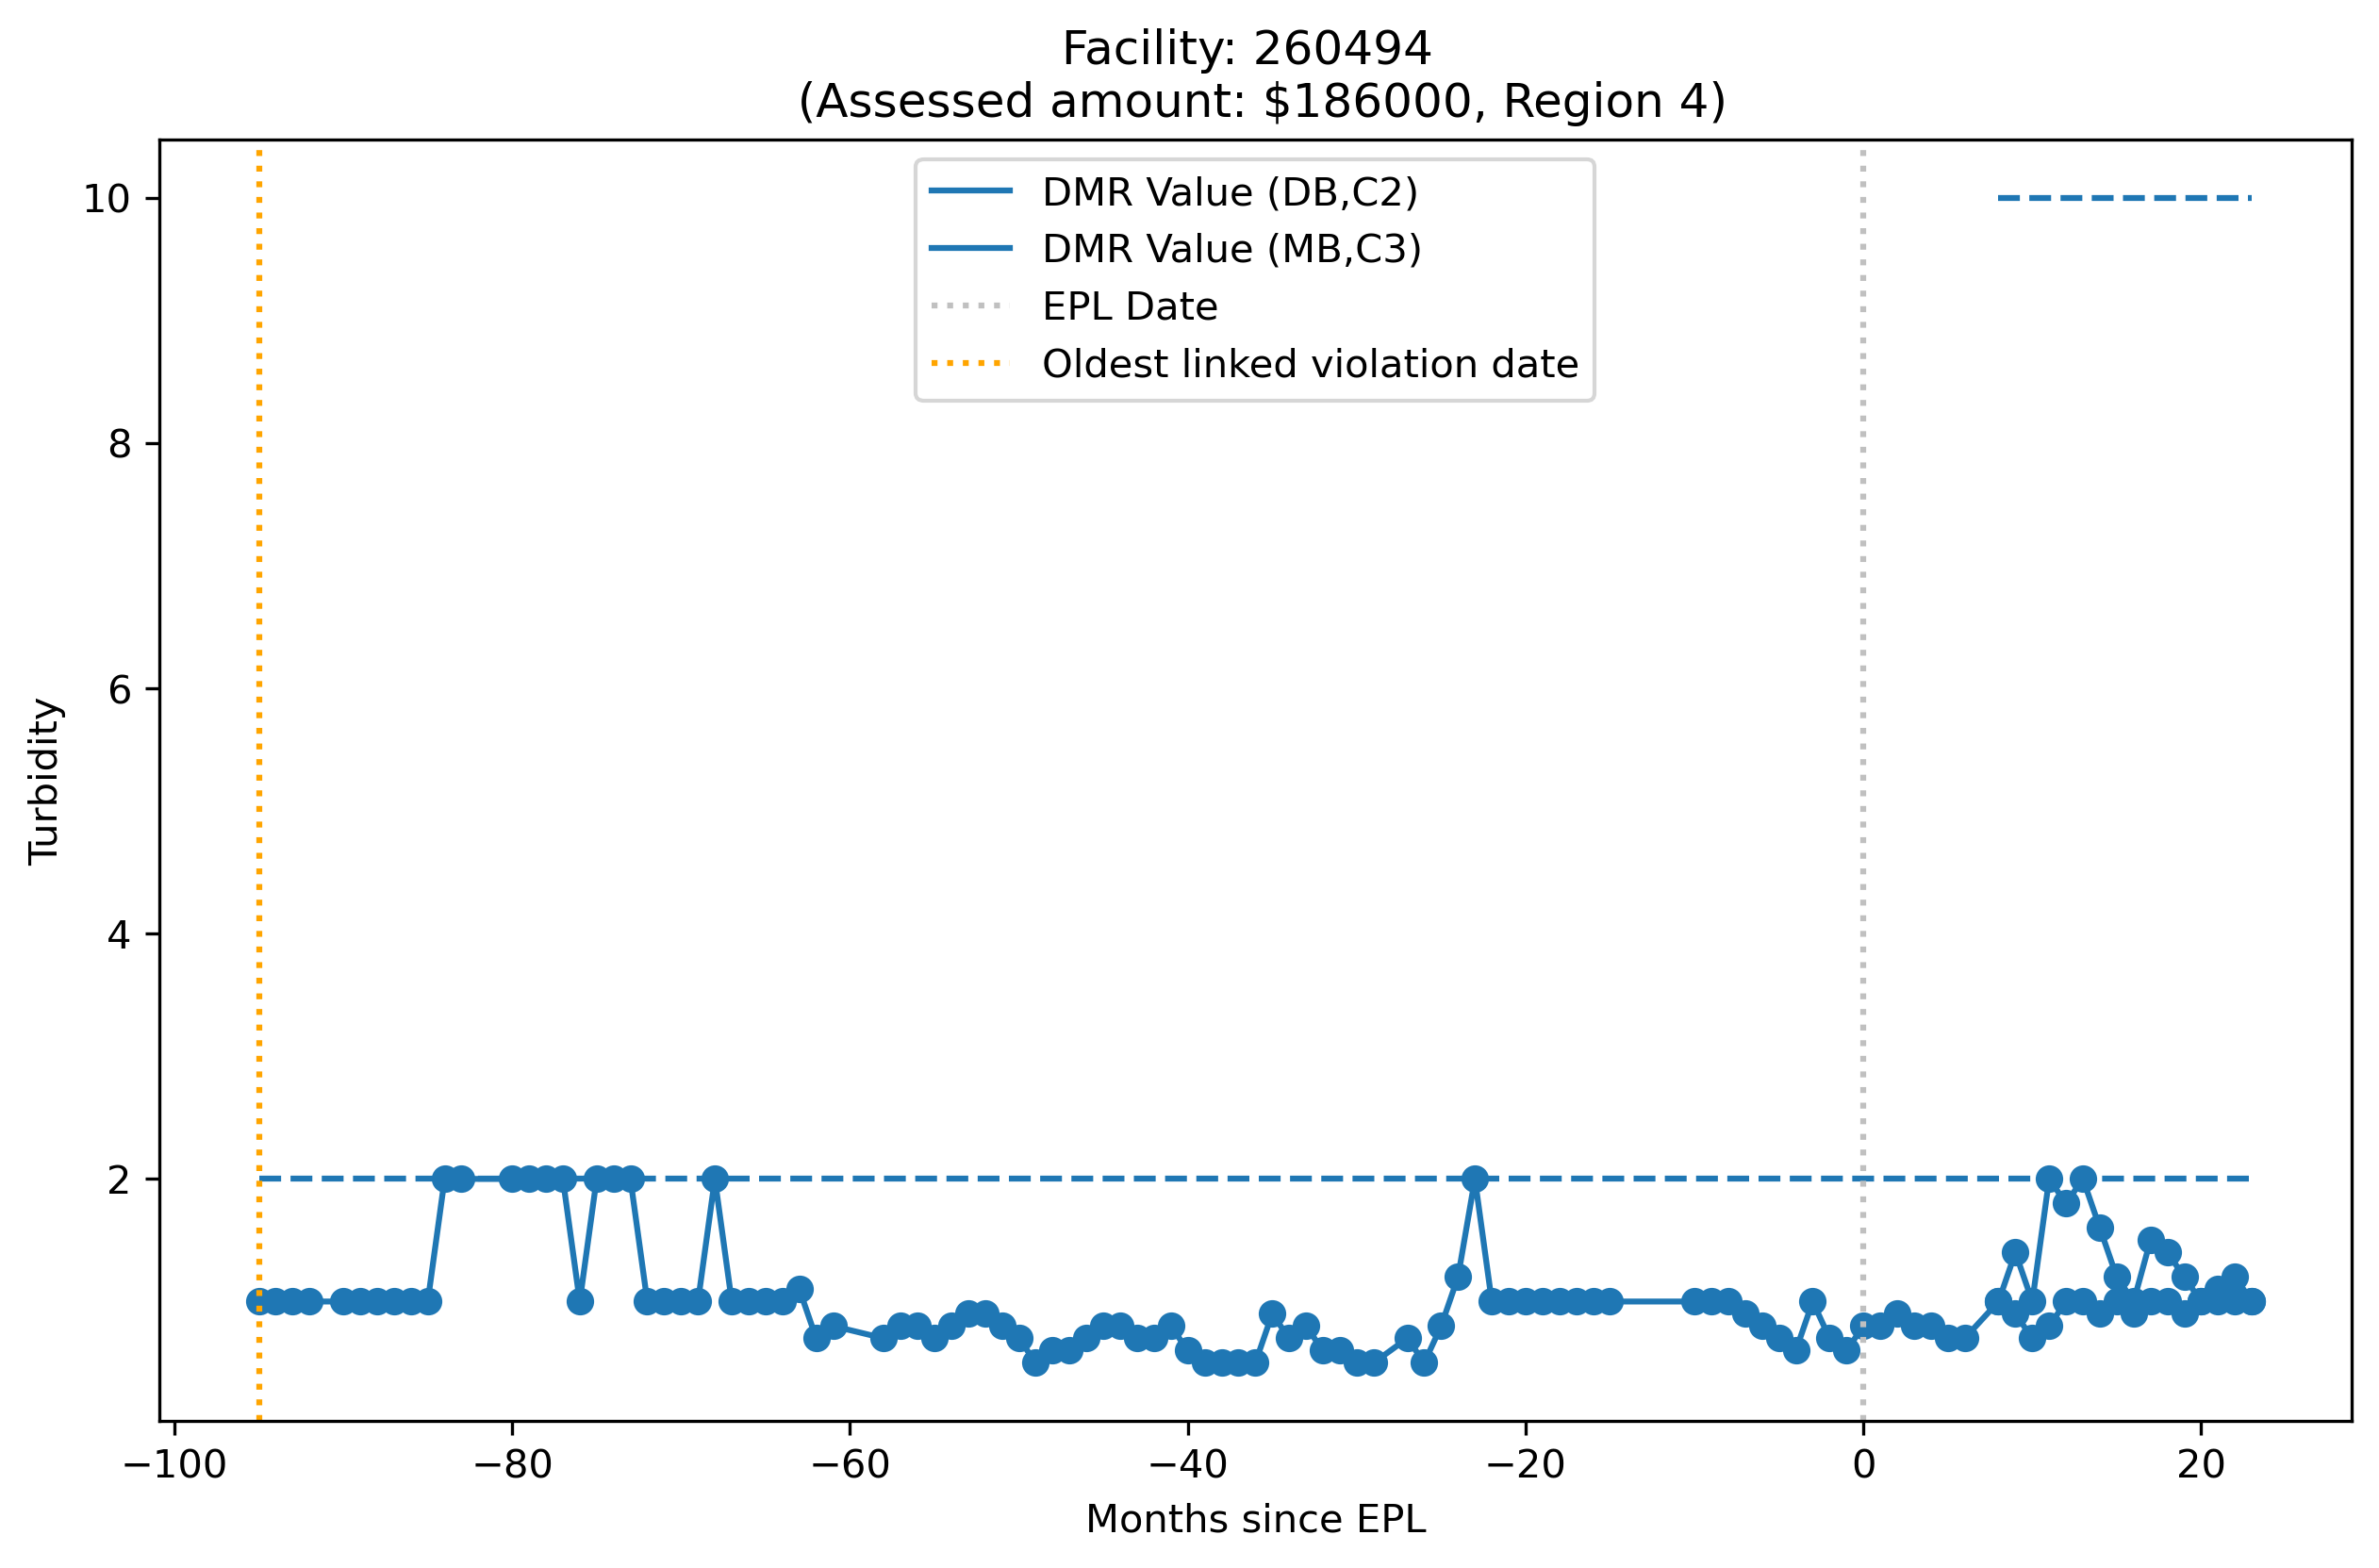

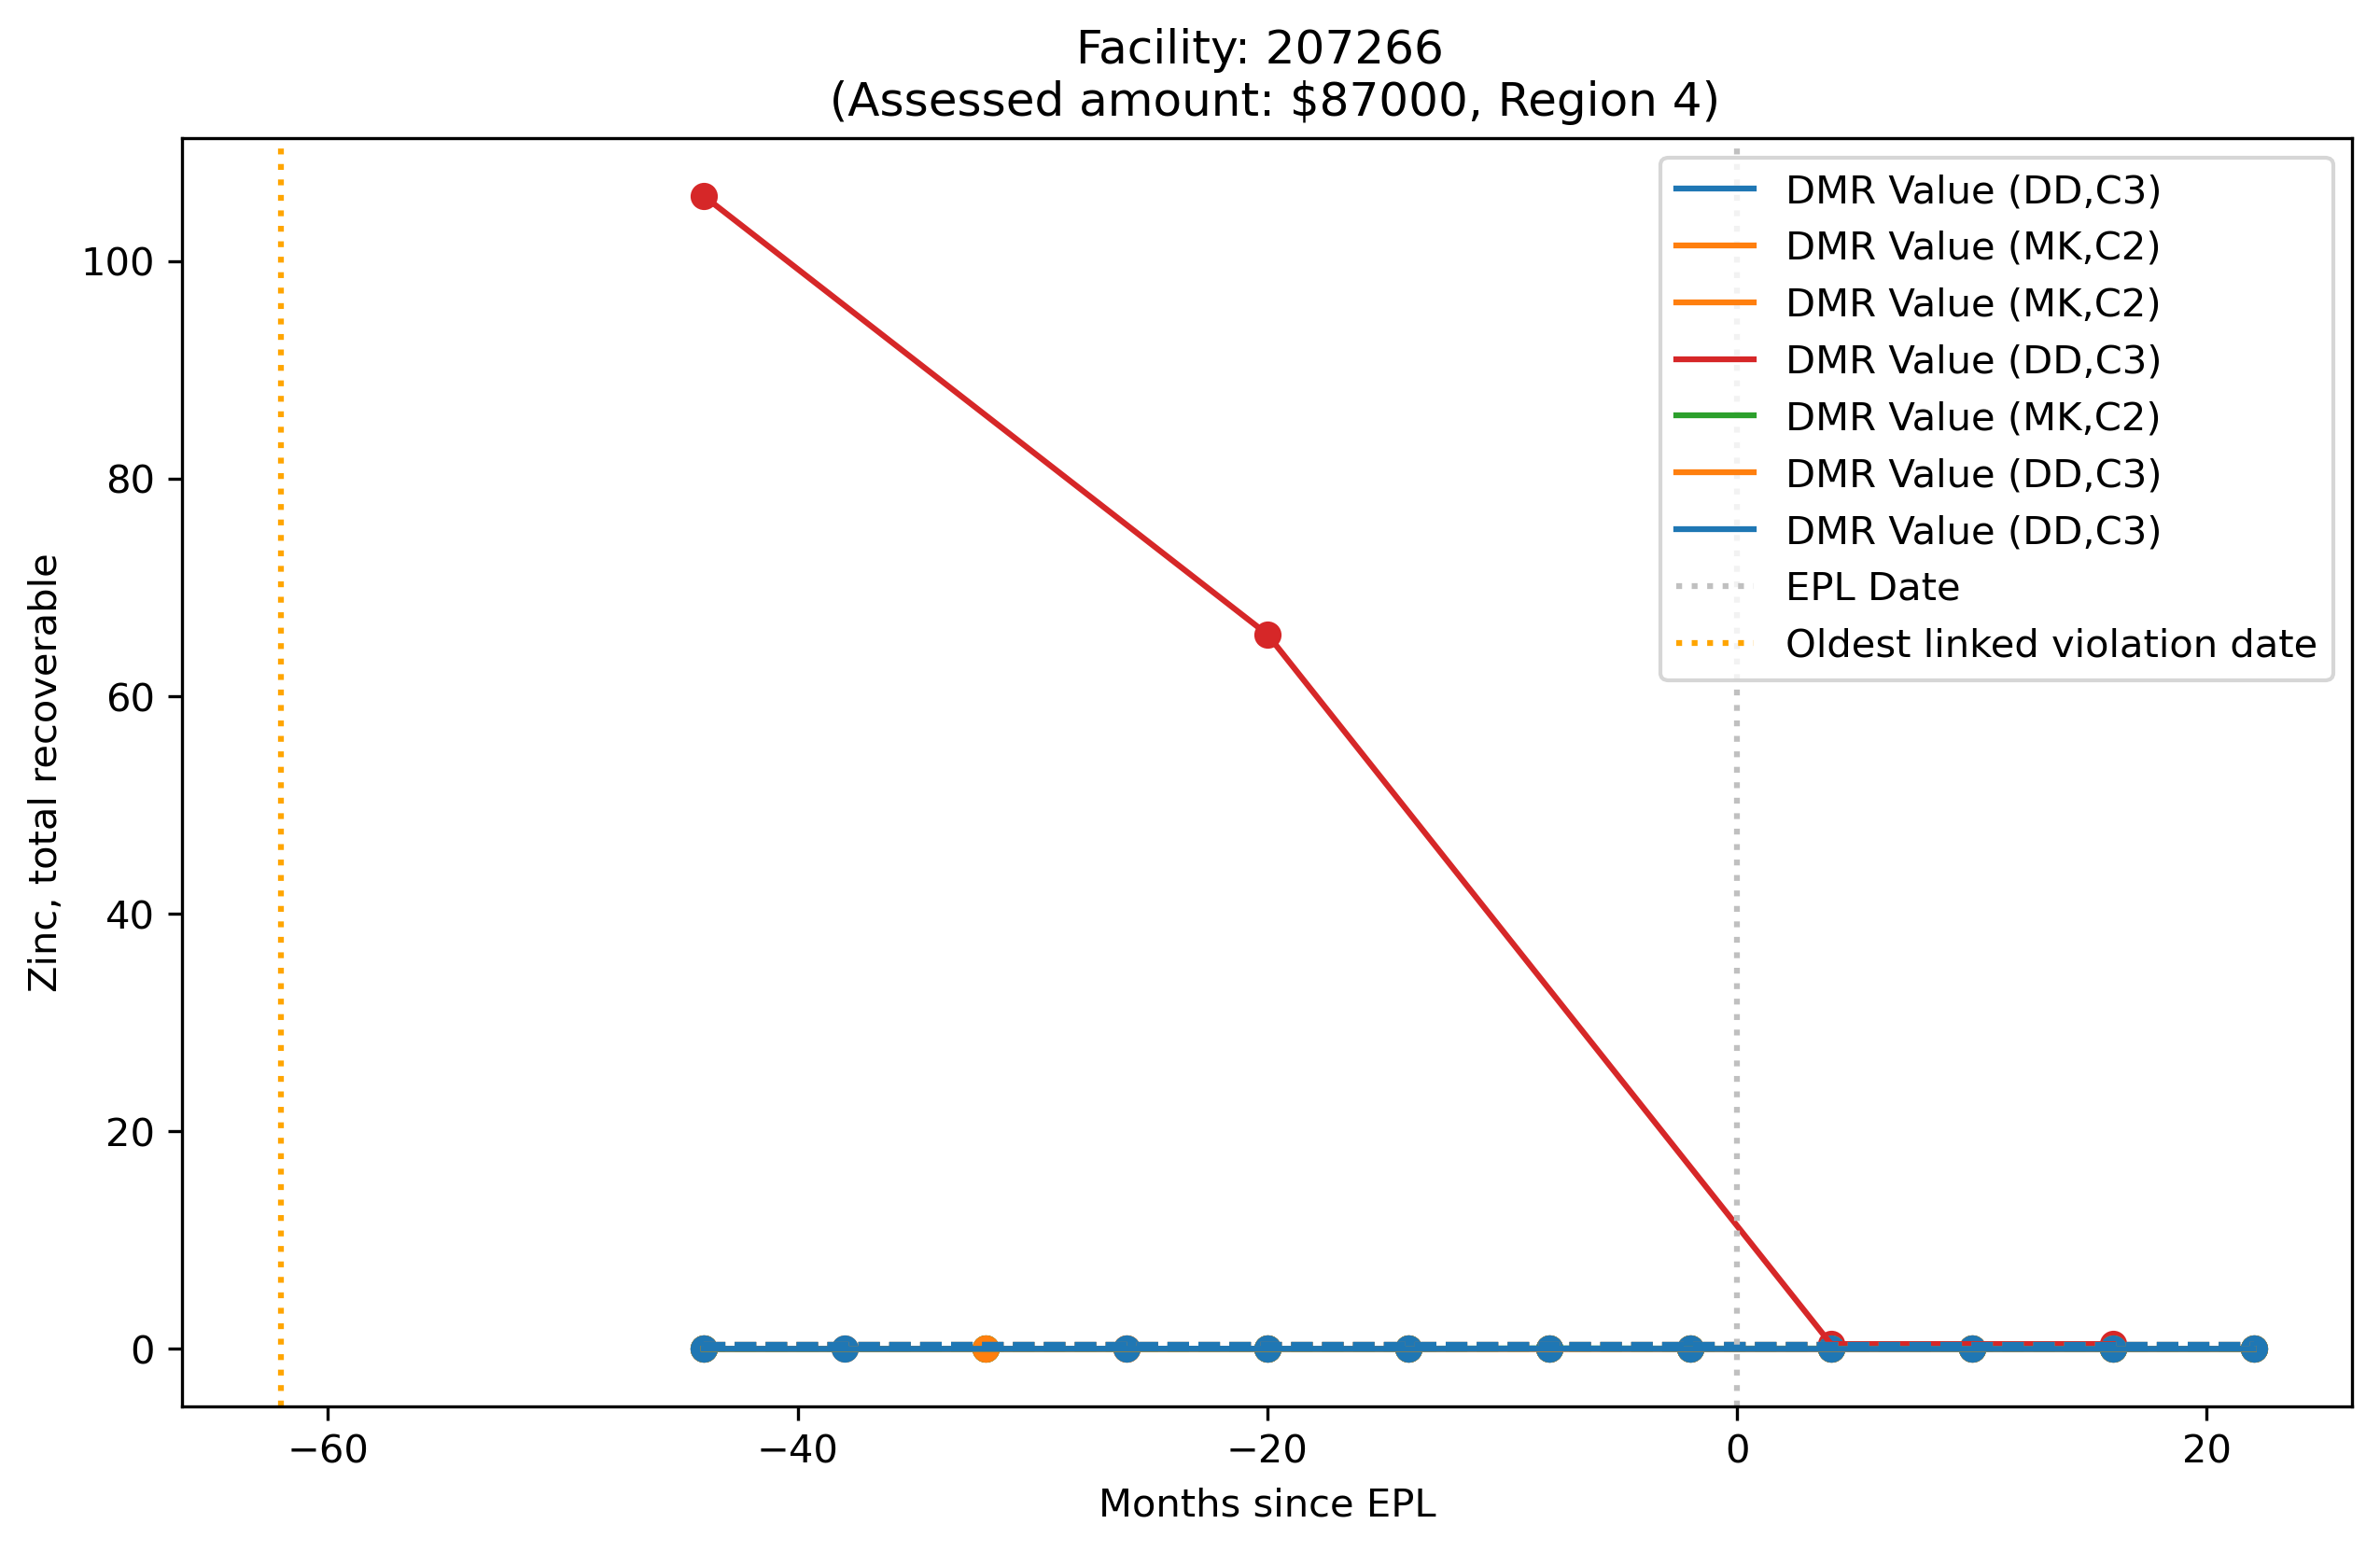

In [11]:
plt.style.use('default')
i = 0
while i <= 20:
    vid = epl_viols_merged_dedupped['VIOLATION ID (VID)'].sample(1).reset_index(drop=True)[0]
    plot_epl(matches_dict, vid, epl_viols_merged)
    i += 1

TODO: change code in above plots so quantity and concentration value types aren't plotted on the same graph

### Do EPLs trigger infrastructure changes?

In [12]:
# Read in schedule data
permit_schedule_data = pd.read_csv('/Users/rtreves/Documents/DMR work/DMR Python projects/dmr-permit-limit-changes/permit_schedules.csv',
                                   parse_dates=['SCHEDULE_DATE', 'ACTUAL_DATE', 'REPORT_RECEIVED_DATE'],
                                   date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
compliance_schedule_data = pd.read_csv('/Users/rtreves/Documents/DMR work/DMR Python projects/dmr-permit-limit-changes/compliance_schedules.csv',
                                       dtype={'COMP_SCHEDULE_EVENT_ID': object, 'ACTIVITY_ID': object},
                                       parse_dates=['SCHEDULE_DATE', 'ACTUAL_DATE'],
                                       date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
schedule_data = pd.concat([permit_schedule_data, compliance_schedule_data], axis=0)
# Filter out schedule events in the future
schedule_data = schedule_data[schedule_data['SCHEDULE_DATE'] < pd.to_datetime(pd.datetime.today())]

# We're looking for infrastructure changes - so we can eliminate any schedule events that were not achieved:
schedule_data.dropna(subset=['ACTUAL_DATE'], inplace=True)
# Read in schedule code dictionary
schedule_code_dict = pd.read_excel('/Users/rtreves/Documents/DMR work/DMR Python projects/dmr-permit-limit-changes/REF_SCHEDULE_EVENT_06.27.22.xlsx').rename(
    columns={'SCHEDULE_EVENT_CODE': 'schedule_event_code'})

Rows 0 - 72 in schedule code dictionary represent schedule codes that are plausibly associated with an infrastructure change, according to Courtney at the EPA. Filtering down to schedule events with these codes:

In [13]:
inf_codes = list(schedule_code_dict.iloc[0:73]['schedule_event_code'])
# Filter down to infrastructure-related schedule events
schedule_data = schedule_data[schedule_data['SCHEDULE_EVENT_CODE'].apply(lambda x: x in inf_codes)]
# Filter down to CA permittees
schedule_data = schedule_data[schedule_data['PGM_SYS_ID'].apply(lambda x: x[0:2]=='CA')]

In [14]:
schedule_data.head()

PGM_SYS_ID  VERSION_NMBR SCHEDULE_EVENT_CODE  \
55705   CA0005282           0.0               CS032   
55707   CA0038067           2.0               CS017   
174093  CA0054313           4.0               CS031   
202281  CA0054216           4.0               CS031   
23      CA0038024           NaN               CS017   

                                      SCHEDULE_EVENT_DESC SCHEDULE_DATE  \
55705                                Other (See Comments)    1988-10-15   
55707   Achieve Final Compliance With Emission or Disc...    2007-12-31   
174093  Achieve Final Compliance With All Obligations ...    2019-07-01   
202281  Achieve Final Compliance With All Obligations ...    2019-07-01   
23      Achieve Final Compliance With Emission or Disc...    2013-02-28   

       ACTUAL_DATE REPORT_RECEIVED_DATE ENF_IDENTIFIER  ENF_CONCLUSION_NMBR  \
55705   1989-07-01           1989-07-01            NaN                  NaN   
55707   2009-03-31           2009-03-31            NaN                  NaN   
174093  2019-05-09           2019-05-09            NaN                  NaN   
202281  2019-05-09           2019-05-09            NaN                  NaN   
23      2013-03-01                  NaT   CA-2009-1090                  1.0   

        COMP_SCHEDULE_NMBR ACTIVITY_ID COMP_SCHEDULE_EVENT_ID  
55705                  NaN         NaN                    NaN  
55707                  NaN         NaN                    NaN  
174093                 NaN         NaN                    NaN  
202281                 NaN         NaN                    NaN  
23                     1.0  1400041996             1400003501

In [15]:
schedule_data_merged = schedule_data.merge(epl_viols_merged[['NPDES# CA#', 'estimated_EPL_date', 'ENFORCEMENT ID (EID)']], left_on='PGM_SYS_ID', right_on='NPDES# CA#', how='inner')
schedule_data_merged['months_since_EPL'] = schedule_data_merged['ACTUAL_DATE'].dt.to_period('M').astype('int')-schedule_data_merged['estimated_EPL_date'].dt.to_period('M').astype('int')
schedule_data_merged.drop_duplicates(inplace=True)

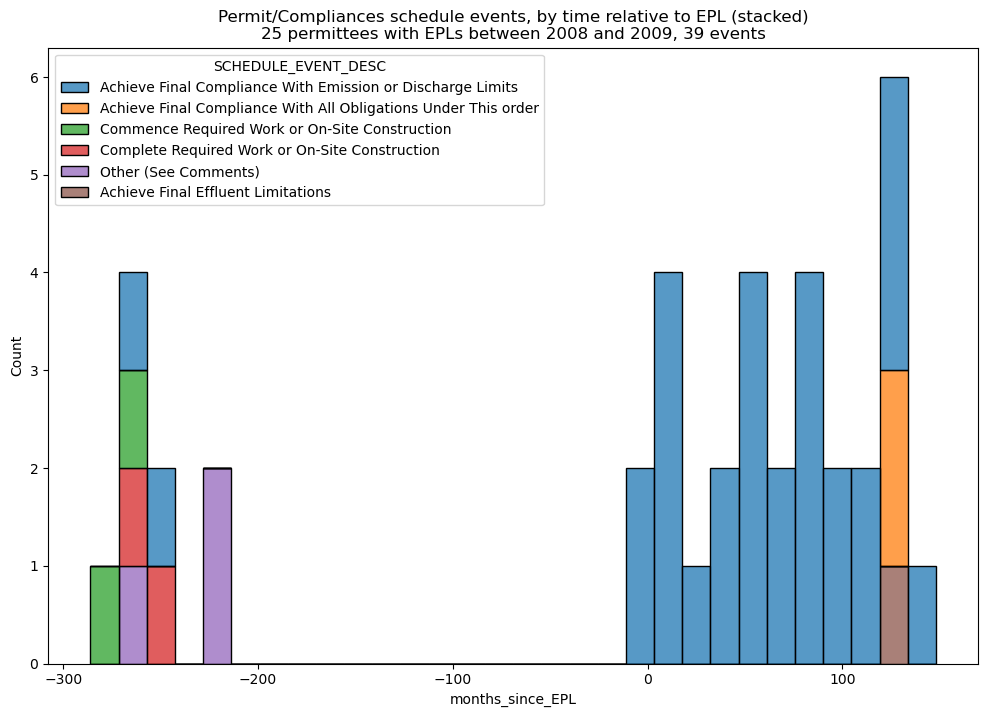

In [16]:
plt.style.use('default')
plt.figure(figsize=(12,8))
sns.histplot(schedule_data_merged, x='months_since_EPL', hue='SCHEDULE_EVENT_DESC', multiple='stack', bins=30)
plt.title('Permit/Compliances schedule events, by time relative to EPL (stacked)' + '\n' + str(len(schedule_data_merged['PGM_SYS_ID'].unique())) + ' permittees with EPLs between 2008 and 2009, 39 events')
plt.savefig('EPL_infr_events.png', dpi=300)

In [17]:
schedule_data_merged_2 = schedule_data.merge(valid_epl_enforcements_npdes[['NPDES # CA#', 'estimated_EPL_date', 'ENFORCEMENT ID (EID)']], left_on='PGM_SYS_ID', right_on='NPDES # CA#', how='inner')
schedule_data_merged_2['months_since_EPL'] = schedule_data_merged_2['ACTUAL_DATE'].dt.to_period('M').astype('int')-schedule_data_merged_2['estimated_EPL_date'].dt.to_period('M').astype('int')
schedule_data_merged_2.drop_duplicates(inplace=True)

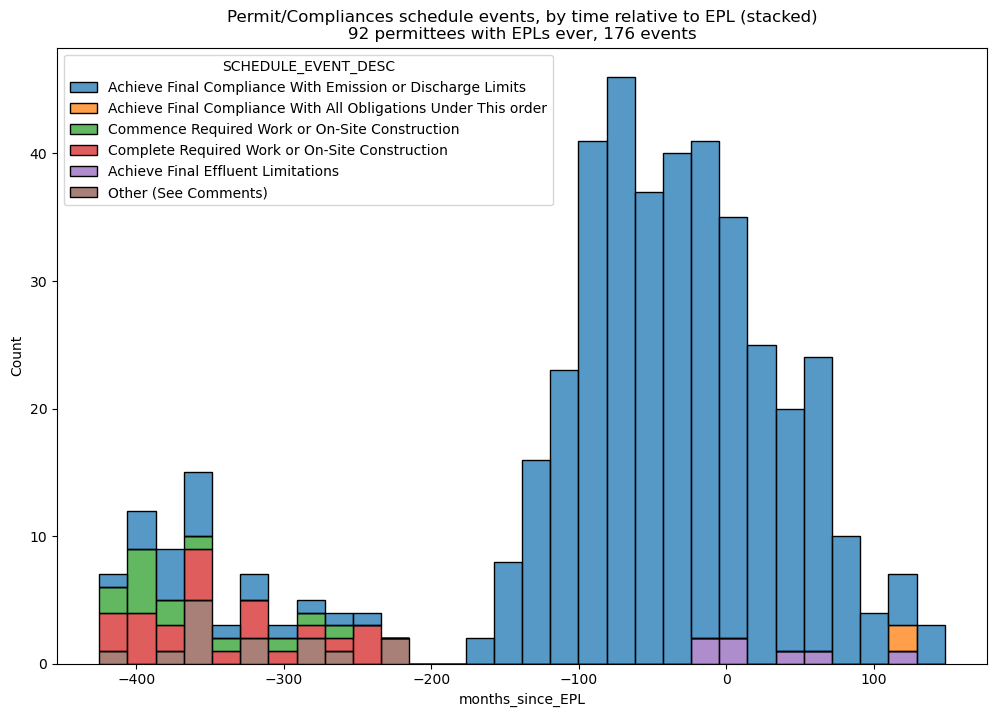

In [18]:
plt.style.use('default')
plt.figure(figsize=(12,8))
sns.histplot(schedule_data_merged_2, x='months_since_EPL', hue='SCHEDULE_EVENT_DESC', multiple='stack', bins=30)
plt.title('Permit/Compliances schedule events, by time relative to EPL (stacked)' + '\n' + str(len(schedule_data_merged_2['PGM_SYS_ID'].unique())) + ' permittees with EPLs ever, ' + str(len(schedule_data_merged_2.drop_duplicates('COMP_SCHEDULE_EVENT_ID'))) + ' events')
plt.savefig('EPL_infr_events_2.png', dpi=300)